In [1]:
#%matplotlib notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
from plotly.subplots import make_subplots
from sklearn.neighbors import KNeighborsClassifier

from keras.datasets import mnist
import seaborn as sns
import pandas as pd
from collections import Counter, OrderedDict

from sklearn.mixture import GaussianMixture
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import random
from sklearn.cluster import KMeans
from itertools import chain

from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats

Using TensorFlow backend.


In [2]:
X_train = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST4_new_train_x.npy')
Y_train = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST4_new_train_y.npy')
X_test = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST4_new_test_x.npy')
Y_test = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST4_new_test_y.npy')
print(X_train.shape, Y_train.shape);print(X_test.shape, Y_test.shape)

(24745, 784) (24745,)
(4134, 784) (4134,)


In [3]:
latent_space_train = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST4_train_latent_space_z5.npy')
print(latent_space_train.shape, Y_train.shape)

(24745, 5) (24745,)


In [4]:
latent_space_test = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST4_test_latent_space_z5.npy')
print(latent_space_test.shape,Y_test.shape)

(4134, 5) (4134,)


In [5]:
tuned_parameters = [{'kernel': ['rbf'], 'C' : [0.1, 1, 10, 100]},
                    {'kernel': ['linear'], 'C' : [0.1, 1, 10, 100]}]
# ,
#                    {'kernel': ['poly'], 'C' : [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001]},
#                    {'kernel': ['sigmoid'], 'C' : [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}]
score = 'accuracy'
clf = GridSearchCV(SVC(), tuned_parameters, scoring=score, n_jobs=-1,refit=True,verbose=2)

# z=5

In [6]:
uniform_is = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_rs_MNIST4_input_space.npy')
uniform_is_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_rs_MNIST4_input_space.npy')

uniform_ls = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_rs_MNIST4_z5.npy')
uniform_ls_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_rs_MNIST4_z5.npy')

random_coreset_is20 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_cs_MNIST4_input_space_K20.npy')
random_coreset_is20_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_cs_MNIST4_input_space_K20.npy')

random_coreset_ls20 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_cs_MNIST4_z5_K20.npy')
random_coreset_ls20_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_cs_MNIST4_z5_K20.npy')

sensitivity_ls20 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_Kraus_cs1000_MNIST4_z5_K20.npy')
sensitivity_ls20_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_Kraus_cs1000_MNIST4_z5_K20.npy')


In [ ]:
uniform_ls

In [ ]:
[uniform_ls[4*i+3] for i in range(5)]

Text(0.5, 1.0, 'Accuracy comparison for 500 labeled points')

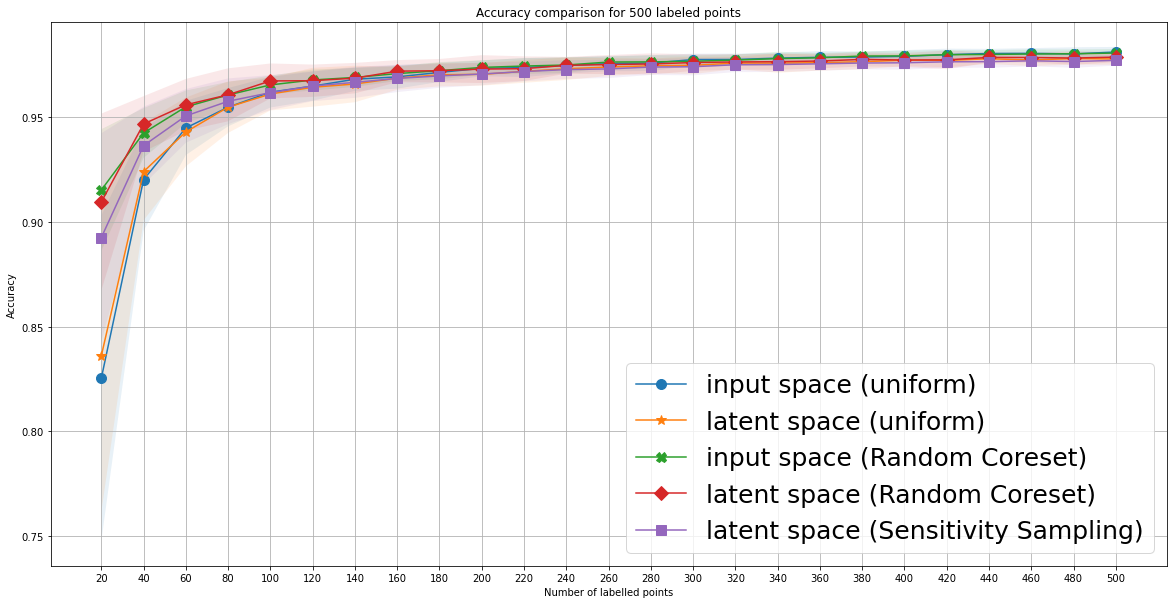

In [7]:
number_of_labeled_data = range(20,501,20)
plt.figure(figsize=(20,10))

plt.plot(number_of_labeled_data,uniform_is, marker='o', markersize=10)
plt.plot(number_of_labeled_data,uniform_ls, marker='*', markersize=10)
plt.plot(number_of_labeled_data,random_coreset_is20, marker='X', markersize=10)
plt.plot(number_of_labeled_data,random_coreset_ls20, marker='D', markersize=10) 
plt.plot(number_of_labeled_data,sensitivity_ls20, marker='s', markersize=10)


plt.fill_between(number_of_labeled_data, (uniform_is - uniform_is_sd), (uniform_is + uniform_is_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (uniform_ls - uniform_ls_sd), (uniform_ls + uniform_ls_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (random_coreset_is20 - random_coreset_is20_sd), (random_coreset_is20 + random_coreset_is20_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (random_coreset_ls20 - random_coreset_ls20_sd), (random_coreset_ls20 + random_coreset_ls20_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (sensitivity_ls20 - sensitivity_ls20_sd), (sensitivity_ls20 + sensitivity_ls20_sd), alpha=.1)





plt.legend(['input space (uniform)',         
            'latent space (uniform)',
          'input space (Random Coreset)',
            'latent space (Random Coreset)'\
           ,'latent space (Sensitivity Sampling)'
           ], loc = 4, fontsize=25)
plt.grid()
plt.xticks(number_of_labeled_data)
plt.xlabel("Number of labelled points")
plt.ylabel("Accuracy")
plt.title("Accuracy comparison for 500 labeled points")

# UT

# Z=7

In [ ]:
n_components = np.arange(1, 81)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(latent_space_train) #z=7
          for n in n_components]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(n_components, [m.bic(latent_space_train) for m in models], label='BIC')
plt.plot(n_components, [m.aic(latent_space_train) for m in models], label='AIC')
plt.legend(loc='best')

plt.xlabel('n_components');

In [ ]:
np.argmin([m.bic(latent_space_train) for m in models])

In [ ]:
np.argmin([m.aic(latent_space_train) for m in models])

# GMM + UT

In [6]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats

In [125]:
# gmm = GaussianMixture(n_components=20).fit(latent_space_train)
gmm = GaussianMixture(n_components=80).fit(latent_space_train)
labels = gmm.predict(latent_space_train)

In [126]:
print(Counter(labels))

Counter({4: 670, 47: 624, 19: 595, 43: 549, 70: 549, 68: 516, 5: 490, 51: 468, 42: 456, 66: 444, 11: 428, 12: 426, 7: 421, 10: 416, 26: 413, 22: 406, 27: 406, 9: 404, 48: 398, 18: 397, 8: 387, 14: 376, 6: 373, 21: 366, 74: 361, 24: 353, 62: 352, 67: 348, 55: 342, 31: 342, 72: 335, 2: 330, 52: 318, 13: 317, 23: 316, 34: 315, 60: 310, 58: 303, 61: 295, 64: 294, 17: 289, 75: 284, 63: 275, 77: 274, 46: 272, 45: 272, 59: 263, 50: 260, 36: 256, 20: 245, 28: 243, 57: 243, 40: 239, 69: 237, 0: 237, 38: 237, 29: 233, 44: 231, 33: 228, 76: 223, 78: 223, 3: 215, 41: 214, 49: 213, 15: 208, 16: 206, 65: 203, 73: 199, 35: 196, 25: 195, 56: 189, 30: 179, 1: 169, 39: 167, 54: 143, 53: 142, 37: 125, 32: 118, 71: 100, 79: 91})


In [127]:
gmm.covariances_.shape

(80, 5, 5)

In [128]:
gmm.means_.shape

(80, 5)

In [129]:
all_sigmas = []
for i in range(80):#range(20):
    mean = gmm.means_[i]
    p = gmm.covariances_[i]
    points = MerweScaledSigmaPoints(n=5, alpha=0.1, beta=2., kappa=(3-5))
    sigmas = points.sigma_points(mean, p)
    all_sigmas.append(sigmas)
    #print(sigmas)

In [130]:
points

MerweScaledSigmaPoints object
n = 5
alpha = 0.1
beta = 2.0
kappa = -2
Wm = [-165.66666667   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667]
Wc = [-162.67666667   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667]
subtract = <ufunc 'subtract'>
sqrt = <function cholesky at 0x2aaaf5aa6670>

In [131]:
all_sigmas = np.array(all_sigmas, dtype=np.float32)
all_sigmas.shape

(80, 11, 5)

In [132]:
sigma_points = all_sigmas.reshape(80*11,5)
sigma_points.shape

(880, 5)

In [133]:
# REMOVE DUPLICATE SIGMA POINTS
sigma_points = np.unique(sigma_points, axis=0)
sigma_points.shape

(880, 5)

In [134]:
# fig = go.Figure()

# fig.add_trace(go.Scatter3d(x=sigma_points[:,0], y=sigma_points[:,1], \
#                                    z=sigma_points[:,2], mode='markers',\
#                                   marker=dict(
#         size=2,
#         color='black',                # set color to an array/list of desired values
#        # colorscale='Viridis',   # choose a colorscale
#         opacity=1.0
#     )))

# fig.add_trace(go.Scatter3d(x=latent_space_train[:,0], y=latent_space_train[:,1], z=latent_space_train[:,2], mode='markers',\
#                                   marker=dict(
#         size=1,
#         color='yellow',#kmeans.labels_,                # set color to an array/list of desired values
#        # colorscale='Viridis',   # choose a colorscale
#         opacity=0.5
#     )))


# fig.update_layout(
#     autosize=False,
#     width=1000,
#     height=1000)

# fig.show()

In [135]:
# def closest_node(node, nodes):
#     dist_2 = np.sum((nodes - node)**2, axis=1)
#     return np.argmin(dist_2)

## Find class of sigma point
In order to find the class of sigma points we use KNN with Squared Euclidean Distance.

In [136]:
neigh = KNeighborsClassifier(n_neighbors=1,weights='distance')
neigh.fit(latent_space_train, Y_train)

KNeighborsClassifier(n_neighbors=1, weights='distance')

In [137]:
prediction = neigh.predict(sigma_points)

In [138]:
print(Counter(prediction))

Counter({3: 236, 0: 220, 1: 220, 9: 204})


# Random

In [139]:
mean_random = []
sd_random = []


for coreset_size in range(40,501,40):
    print("*********************** Training on {} points ***********************".format(coreset_size))
    accuracy = [] # calculate accuracy of 500 iterations
    c = list(zip(sigma_points,prediction))
    iterations = 0
    while iterations < 500: # run 500 simulations and take average 
        train_data = []
        train_labels = []
        for (data,label) in random.sample(c,coreset_size):
            train_data.append(data)
            train_labels.append(label)  
        train_x = np.array(train_data)
        train_y = np.array(train_labels)
        
        print()
        print("Distribution of data in the training points")
        print(Counter(train_y)) 

        clf.fit(train_x, train_y)
        print("Best parameters set found on {} data points:".format(coreset_size))
        print(clf.best_params_)
        print()
        y_true, y_pred = Y_test, clf.predict(latent_space_test)
        accuracy.append(accuracy_score(y_true, y_pred))
        iterations += 1
    accuracy = np.asarray(accuracy)
    mean_accuracy = accuracy.mean()
    sd_accuracy = accuracy.std()
    
    mean_random.append(mean_accuracy)
    sd_random.append(sd_accuracy)
    
mean_random = np.array(mean_random)
sd_random = np.array(sd_random)

*********************** Training on 40 points ***********************

Distribution of data in the training points
Counter({1: 13, 0: 11, 9: 8, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 1: 11, 9: 9, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 9: 11, 0: 10, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 17, 3: 8, 1: 8, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 3: 11, 9:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 16, 0: 9, 9: 8, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 13, 9: 13, 0: 7, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 11, 9: 10, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 3: 9, 9: 9, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 13, 3: 11

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 9: 11, 0: 10, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 0: 12, 1: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 3: 12, 0: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 1: 11, 3: 8, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 10, 9: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 1: 11, 3: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 12, 1: 8

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({9: 12, 1: 11, 0: 10, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 17, 3: 9, 1: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 11, 1: 11, 0: 11, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 1: 12, 3: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 1: 12, 0: 11, 9: 5})
Fitting 5 folds for each of 8 candidates, totallin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 9: 11, 1: 8, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 12, 9: 8, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 16, 1: 12, 3: 7, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 1: 12, 0: 10, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 9: 1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 12, 0: 12, 3: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 9: 12, 0: 9, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 13, 9: 12, 3: 8, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 9: 10, 0: 10, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 9: 11, 3: 10, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Be

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({9: 14, 0: 12, 3: 9, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 0: 12, 3: 10, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 0: 10, 9: 9, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 3: 11, 9: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 11, 1: 11, 0: 10, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Counter({0: 16, 3: 9, 9: 8, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 1: 11, 0: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 16, 1: 9, 3: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 9: 14, 0: 10, 1: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 0: 14, 1: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)


Distribution of data in the training points
Counter({3: 17, 9: 9, 1: 8, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 1: 11, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 11, 0: 10, 1: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 9: 10, 1: 10, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 16, 0: 10, 1: 9, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 9: 10, 1: 9, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 9: 11, 1: 10, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 0: 12, 1: 12, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 9: 12, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 9: 10, 0: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 9: 12, 0: 10, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 9: 13, 1: 9, 0: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 12, 9: 11, 3: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distr

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 11, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 17, 0: 13, 1: 6, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 0: 9, 1: 8, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 3: 9, 1: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 1: 11, 0: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 3: 10, 0: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 1: 10, 9: 10, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 1: 11, 9: 10, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 15, 3: 13, 0: 7, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 11, 1: 9

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 9: 10, 1: 10, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 15, 3: 10, 9: 8, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 11, 9: 9, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 17, 9: 10, 0: 8, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 15, 9: 1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 16, 0: 10, 1: 8, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 0: 11, 9: 9, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 0: 10, 9: 10, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 0: 11, 3: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 11, 3: 11, 9: 10, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 15, 0: 11, 1: 9, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 0: 10, 1: 9, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 0: 11, 9: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 10, 1: 10, 0: 10, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 15, 3: 13, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 0: 13, 1: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 0: 11, 1: 10, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 3: 10, 9: 8, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 9: 11, 3: 10, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 3: 11, 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 1: 11, 9: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 3: 11, 9: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 15, 1: 9, 3: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 12, 0: 12, 3: 8, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 3: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 12, 1: 12, 3: 11, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 9: 10, 3: 9, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 1: 11, 9: 10, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 0: 10, 9: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 0: 11, 1: 9, 3: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Be

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/skle

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 11, 0: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 1: 9, 3: 8, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 16, 0: 10, 1: 9, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 9: 12, 0: 8, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 1: 10, 3: 10, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 9: 11, 1: 8, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 0: 11, 1: 9, 3: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 0:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 11, 9: 10, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 0: 10, 9: 9, 3: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 0: 11, 9: 8, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 1: 12, 0: 10, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 11, 3: 11, 0: 10,

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 0: 12, 9: 9, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 1: 11, 9: 10, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 1: 12, 9: 10, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 0: 12, 1: 10, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 1: 10, 9

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 20, 3: 10, 0: 6, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 14, 0: 11, 1: 10, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 15, 0: 10, 3: 10, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 3: 11, 0: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 15, 3: 14

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/skle

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 13, 1: 10, 0: 9, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 1: 11, 3: 11, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 3: 11, 1: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 12, 1: 11, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 1: 11, 0:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 10, 0: 10, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 18, 0: 13, 1: 5, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 3: 11, 9: 10, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 16, 0: 10, 9: 7, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 0: 11, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs


Distribution of data in the training points
Counter({0: 11, 9: 10, 1: 10, 3: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 9: 10, 1: 10, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 16, 3: 9, 9: 8, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 9: 11, 3: 10, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 17, 9: 11, 1: 6, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Be

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 13, 1: 12, 3: 9, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 0: 10, 9: 8, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 13, 9: 12, 3: 10, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 11, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 0:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 16, 3: 10, 0: 9, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 9: 11, 0: 10, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 0: 12, 3: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 13, 1: 12, 3: 9, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 9: 10, 1: 10, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 1: 10, 3: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 11, 1: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 1: 12, 9: 8, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 3: 13, 1: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 1: 12, 9: 10, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 0: 14, 9: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 9: 11, 0: 9, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 14, 3: 11, 0: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 0: 11, 9: 8, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 9: 10, 1: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 1: 11, 9: 1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 16, 1: 9, 9: 9, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 9: 11, 0: 8, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 1: 11, 9: 10, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 9: 10, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 15, 9: 10, 0: 9, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 0: 11, 9: 8, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 1: 12, 9: 8, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 15, 3: 10, 9: 10, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 16, 0: 9, 1: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 3: 11, 1: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 3: 13, 1: 9, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 11, 9: 8, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 16, 3: 11

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({9: 13, 3: 10, 0: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 16, 0: 13, 1: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 0: 13, 3: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 9: 11, 1: 9, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 11, 3: 10, 9: 10, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 9: 12, 0: 10, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 0: 12, 9: 10, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 3: 11, 0: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 1: 10, 3: 10, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


D

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 9: 10, 3: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 9: 11, 3: 10, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 0: 9, 9: 8, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 15, 0: 11, 9: 9, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 9: 9, 1: 8, 3

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({1: 17, 0: 10, 9: 8, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 1: 12, 3: 9, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 0: 10, 9: 8, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 9: 10, 1: 8, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 0: 11, 1: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({0: 12, 1: 12, 3: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 3: 11, 1: 10, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 13, 3: 12, 0: 11, 1: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 9: 11, 3: 10, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 16, 1: 10, 9: 7, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fit

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(


Distribution of data in the training points
Counter({1: 13, 0: 13, 9: 8, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 3: 11, 1: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 13, 3: 12, 0: 8, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 15, 0: 10, 1: 8, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 15, 3: 10, 0: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Be

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 13, 3: 12, 1: 11, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 11, 1: 8, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 14, 1: 10, 3: 9, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 12, 3: 11, 9: 10, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 1: 11, 3: 11, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 1: 10, 9: 10, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 10, 0: 10, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 9: 11, 3: 10, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 0: 12, 1: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 12, 3: 11, 9: 11, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 0: 12, 3: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 9: 9, 1: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 9: 11, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 11, 9: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 12, 3: 12, 0: 11, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 0: 12, 9: 10, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 12, 9: 10, 3: 9, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 14, 0: 9, 3: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 11, 9: 10, 3: 10, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 1: 12, 9: 8, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 15, 0: 11, 9: 8, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 10, 9: 9

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 11, 0: 11, 3: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 16, 3: 11, 1: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 1: 12, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 3: 11, 9: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 1: 11

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 12, 3: 11, 9: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 1: 10, 3: 10, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 1: 9, 3: 8, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 9: 12, 1: 8, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 1: 12, 3: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 12, 0: 11, 3: 10, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 3: 11, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 1: 12, 3: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 1: 11, 0: 11, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 10, 9

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 10, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 1: 10, 9: 10, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 3: 10, 9: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 0: 11, 9: 11, 1: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 0: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 9: 11, 1: 10, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 15, 0: 12, 1: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 3: 11, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 12, 0: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 13, 3: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 0: 11, 1: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 1: 10, 9: 9, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 3: 13, 1: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 9: 12, 3: 7, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 1: 11, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 0: 13, 3: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 13, 1: 9, 3: 9, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 3: 11, 1: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 0: 13, 9: 7, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 15, 0: 10, 9: 9, 3: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 17, 3: 11, 9: 9, 0: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 12, 1: 10, 3: 9, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 0: 10, 3: 10, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 16, 3: 11, 9: 8, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 14, 0: 9, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 13, 0: 11, 9: 10, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 11, 1: 11, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 17, 9: 9, 1: 8, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 9: 13, 1: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 9: 13, 0: 7, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Be

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 1: 11, 9: 11, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 10, 9: 10, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 0: 10, 3: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 0: 10, 1: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 0: 12, 1: 8, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 3: 12, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 3: 10, 0: 10, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 16, 3: 9, 0: 8, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 3: 11, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 13, 0: 11, 3: 9

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 9: 10, 0: 9, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 12, 3: 12, 0: 10, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 1: 10, 9: 9, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 9: 10,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 0: 11, 1: 10, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 3: 11, 0: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 0: 11, 1: 10, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 11, 9: 11, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 1: 10, 3: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 12, 0: 10, 9: 10, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 17, 0: 11, 3: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 11, 9: 10, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 17, 3: 10, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 9: 1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 14, 3: 10, 1: 9, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 0: 11, 9: 11, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 13, 1: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 1: 11, 3: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 3: 10, 1: 10, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 1: 9, 9: 9, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 9: 12, 1: 11, 0: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 12, 1: 11, 3: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 3: 10,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 1: 11, 9: 10, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 1: 12, 9: 8, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 15, 1: 9, 0: 9, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 14, 1: 11, 3: 8, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 13, 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 9: 11, 0: 8, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 3: 11, 9: 8, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 1: 11, 9: 8, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 3: 13, 9: 7, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 3: 10, 9: 1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 3: 11, 0: 11, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 0: 9, 3: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 3: 10, 9: 10, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 0: 12, 3: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 1: 10, 9: 8

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 1: 10, 3: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 9: 12, 3: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 12, 0: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 9: 11, 0: 8, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 9: 10, 0: 8,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 13, 0: 12, 1: 8, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 16, 3: 9, 9: 8, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 9: 11, 3: 8, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 11, 9: 11, 3: 10, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 9: 11, 1: 10, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 10, 1: 9, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 17, 9: 11, 0: 7, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 11, 1: 10, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 16, 3: 11, 9

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 16, 1: 11, 0: 9, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 1: 11, 9: 8, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 16, 9: 9, 1: 9, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 3: 12, 0: 11, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 14, 0: 10

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated cl


Distribution of data in the training points
Counter({3: 12, 0: 12, 9: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 18, 1: 10, 3: 9, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 15, 1: 9, 9: 8, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 9: 10, 3: 10, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 13, 1: 12, 3: 8, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 1: 11, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 16, 0: 11, 1: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 15, 0: 11, 3: 7, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 1: 11, 9: 8, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 11, 3: 10, 9: 10, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 17, 0: 9, 1: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 9: 11, 3: 10, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 1: 10, 3: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 1: 11, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 9: 11, 1: 9, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 18, 3: 9, 1: 9, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 15, 0: 11, 1: 9, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 14, 0: 10, 3: 10, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 0: 10, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 13, 0: 11, 9: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 12, 1: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 13, 0: 13, 3: 9, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 11, 0: 11, 9: 11, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 11, 9: 11, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated cl

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 16, 3: 11, 1: 10, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 1: 12, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 9: 10, 1: 9, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 1: 12, 0: 11, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 12, 3: 11

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 13, 3: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 17, 1: 11, 3: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 0: 10, 3: 8, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 1: 11, 3: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 1: 12, 0: 10, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 1: 14, 0: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 12, 1: 11, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 1: 9, 9: 8, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 1: 10, 9: 9, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 1: 11, 0: 10,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 12, 0: 10, 1: 9, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 15, 1: 14, 9: 7, 0: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 1: 11, 0: 9, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 9: 11, 3: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 9: 10, 0: 10, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
B

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 11, 9: 10, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 3: 11, 0: 8, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 11, 1: 11, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 15, 0: 11, 9: 9, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 12, 0: 11, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 3: 10, 0: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 1: 10, 9: 6, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 13, 3: 10, 1: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 3: 10, 9: 9, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 1: 10, 9: 8, 0

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 0: 11, 1: 10, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 1: 10, 9: 10, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 15, 0: 9, 3: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 12, 1: 9, 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 12, 9: 11, 0: 9, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 14, 1: 10, 3: 10, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 0: 12, 1: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 11, 0: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 13, 9: 9, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 11, 1: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 14, 1: 11, 0: 9, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 1: 12, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 13, 0: 12, 1: 8, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 1: 9, 0:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 1: 10, 9: 10, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 11, 9: 9, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 9: 10, 0: 10, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 1: 11, 9: 8, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 1: 11, 3

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 3: 10, 9: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 11, 0: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 11, 9: 10, 3: 10, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 14, 0: 12, 1: 8, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 11, 1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 14, 0: 11, 3: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 11, 0: 10, 9: 10, 3: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 3: 11, 1: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 11, 1: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 16, 3: 10, 1: 8, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 1: 12, 0: 10, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 16, 9: 9, 0: 9, 1: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 16, 0: 11, 9: 8, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 9: 10, 1: 9, 0

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({1: 10, 3: 10, 9: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 13, 3: 11, 9: 8, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 11, 9: 10, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 9: 11, 1: 9, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 15, 9: 9, 0: 8, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 15, 3: 9, 0: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 10, 1: 9, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 0: 11, 1: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 3: 12, 9: 9, 1: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 1: 11, 3: 8

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 3: 11, 9: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 9: 11, 0: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 12, 0: 12, 1: 9, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 12, 1: 9, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 1:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 12, 0: 11, 3: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 1: 11, 0: 9, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 15, 3: 9, 9: 8, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 1: 12, 9: 8, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 1: 12

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Counter({0: 13, 9: 11, 3: 9, 1: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 14, 0: 12, 9: 8, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 11, 0: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 15, 1: 9, 3: 9, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 11, 1: 9, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 16, 9: 8, 0: 8, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 0: 12, 9: 11, 1: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 80 points ***********************

Distribution of data in the training points
Counter({1: 23, 3: 23, 0: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 26, 3: 19, 9: 18, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 0: 22, 9: 20, 1: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 25, 9: 21, 3: 17, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 30, 9: 20, 0: 15, 3: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 25, 3: 24, 1: 17, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 23, 9: 21, 3: 21, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 0: 21, 3: 19, 1: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 1: 24, 9: 16, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 9: 21, 1: 19, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 3: 24, 9: 17, 1: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 23, 1: 19, 9: 19, 0: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 27, 3: 23, 0: 15, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 3: 22, 0: 20, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 0:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 25, 9: 21, 3: 17, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 1: 23, 9: 19, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 9: 20, 3: 19, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 0: 19, 1: 19, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 25, 1: 20, 9: 19, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 0: 24, 1: 20, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 1: 21, 9: 18, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 25, 3: 20, 9: 18, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 9:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 3: 22, 9: 19, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 9: 20, 0: 19, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 25, 0: 20, 9: 18, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 27, 3: 22, 9: 19, 0: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 26, 9: 20, 1: 18, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 3: 21, 1: 19, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 23, 0: 20, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 2

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 22, 1: 21, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 3: 21, 9: 19, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 1: 22, 0: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 26, 0: 22, 9: 19, 1: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 0

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 26, 3: 22, 0: 21, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 9: 21, 1: 19, 3: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 23, 1: 18, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 9: 20, 3: 20, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 23, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 22, 9: 21, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 27, 1: 21, 3: 17, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 25, 3: 20, 9: 18, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 23, 9: 21, 0: 19, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 23, 3: 21, 0: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 24, 1: 23, 3: 17, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 26, 1: 20, 3: 18, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 1: 21, 9: 21, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 3: 23, 0: 23, 9: 11})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 9: 23, 1: 23, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 3: 22, 1: 18, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 26, 3: 21, 0: 17, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 9: 20, 1: 19, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 0: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 1: 22, 3: 21, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 24, 3: 23, 9: 17, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 9: 19, 1: 18, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 26, 1: 21, 9: 19, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 2

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 24, 1: 24, 9: 16, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 3: 24, 9: 17, 1: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 26, 3: 23, 0: 16, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 1: 23, 0: 18, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 3: 21, 0: 21, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 29, 1: 19, 9: 17, 3: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 22, 1: 21, 9: 19, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 21, 1: 19, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 22, 3: 21, 0: 20, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 1: 22, 0: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 22, 3: 21, 0: 20, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 21, 0: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 21, 3: 21, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 3: 22, 0: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 3: 21, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 1: 18, 9: 18, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 26, 0: 21, 9: 17, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 9

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 9: 23, 1: 18, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 28, 0: 21, 3: 18, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 25, 3: 24, 0: 16, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 23, 0: 18, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 24, 9: 16, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 0: 22, 9: 18, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 25, 3: 20, 9: 18, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 0: 21, 1: 18, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 27, 1: 20, 0: 20, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0: 21, 9: 16, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 25, 3: 22, 0: 22, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 24, 9: 21, 0: 19, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 0: 20, 1: 20, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 26, 0: 23, 3: 17, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 3: 22, 0: 20, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 24

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 22, 9: 18, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 25, 3: 24, 0: 17, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 30, 9: 18, 0: 16, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 9: 20, 3: 20, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 9: 22, 1: 17, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 26, 3: 21, 1: 18, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 23, 1: 21, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 9: 20, 1: 17, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 27, 3: 20, 1: 17, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 3: 22, 0: 18, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 26, 0: 22, 9: 17, 3: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 1: 19, 9: 18, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 9: 19, 0: 19, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 9: 22, 1: 16, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 23, 0:

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0: 22, 9: 16, 1: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 0: 20, 3: 20, 1: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 22, 1: 21, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 9: 21, 3: 20, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 3: 21, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 23, 1: 20, 0: 20, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 9: 21, 0: 18, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 9: 22, 1: 20, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 21, 9: 21, 3: 19, 0: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 30, 1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 30, 9: 18, 0: 17, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 3: 21, 1: 20, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 9: 21, 0: 20, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 3: 22, 1: 21, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 20, 9: 20, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 9: 19, 1: 19, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 25, 0: 22, 9: 18, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 0: 21, 9: 19, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 26

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 27, 1: 20, 3: 17, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 1: 19, 9: 16, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 0: 23, 9: 21, 1: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 9: 20, 1: 18, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23,

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 0: 21, 1: 18, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 0: 22, 3: 21, 1: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 21, 9: 20, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 1: 20, 3: 20, 0: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 0: 19, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 23, 9: 20, 0: 19, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 3: 19, 9: 18, 1: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 22, 0: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 1: 22, 3: 17, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 9

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 0: 22, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 25, 3: 21, 9: 17, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 28, 0: 20, 3: 17, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 28, 1: 18, 9: 18, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 22

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 9: 19, 0: 18, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 0: 21, 3: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 22, 1: 17, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 26, 9: 19, 3: 19, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 1:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 1: 19, 0: 17, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 1: 20, 9: 18, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 25, 3: 24, 0: 17, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 26, 3: 26, 9: 18, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 9: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 0: 23, 9: 20, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 0: 23, 1: 17, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 26, 3: 21, 0: 18, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 25, 1: 23, 0: 18, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 9: 20, 1: 20, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 24, 3: 19, 0: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 21, 0: 21, 1: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 0: 20, 9: 19, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 2

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 23, 9: 22, 0: 21, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 3: 21, 1: 20, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 22, 3: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 3: 22, 9: 16, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 24, 1: 20, 9: 18, 3: 18})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 9: 21, 1: 19, 0: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 3: 23, 1: 16, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 20, 9: 17, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 21, 9: 20, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 28, 3:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 9: 19, 0: 19, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 23, 3: 22, 0: 22, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 25, 3: 20, 9: 18, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 21, 0: 20, 1: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 25, 0: 22, 3: 18, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 1: 24, 0: 17, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 26, 9: 24, 0: 15, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 21, 3: 21, 0: 19, 1: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 21, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 27, 9: 20, 3: 19, 0: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 24, 9: 22, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 28, 9: 19, 1: 17, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 2

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 0: 23, 9: 18, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 9: 21, 3: 20, 1: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 23, 9: 21, 1: 20, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 1: 24, 3: 18, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 26, 0:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 9: 21, 3: 21, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 23, 9: 15, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 3: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 9: 20, 1: 18, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 1: 22, 0: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 9: 22, 0: 19, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 26, 3: 18, 1: 18, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 1: 21, 0: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 9: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 3: 22, 9: 22, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 23, 9: 20, 1: 20, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 1: 24, 3: 20, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 25, 9: 20, 0: 18, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 1: 20, 0: 17, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 1: 21, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 21, 1: 18, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0: 22, 1: 16, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 3: 20, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 9: 20, 3: 19, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 1: 21, 3: 20, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 21, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 27, 3: 22, 1: 16, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 0:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 0: 21, 9: 19, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 9: 22, 1: 20, 3: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 25, 9: 21, 0: 19, 3: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 21, 9: 20, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 9: 21, 1: 18, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 28, 9: 23, 0: 15, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 20, 1: 19, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 23, 9: 23, 3: 19, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 9:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 24, 3: 24, 1: 17, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 20, 9: 20, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 22, 9: 21, 1: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 1: 22, 0: 17, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 30, 1: 18, 9: 16, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 0: 21, 9: 19, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 25, 9: 19, 3: 19, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 9: 24, 0: 18, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 1: 18, 9: 17, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 0: 20, 3: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 1: 2

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 23, 1: 18, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 21, 0: 21, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 9: 23, 1: 18, 0: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 9:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 1: 21, 0: 19, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 28, 9: 20, 1: 16, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 25, 3: 20, 9: 19, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 32, 0: 19, 9: 17, 1: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 23, 3: 21, 9: 20, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 21, 9: 19, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 22, 3: 21, 9: 19, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 23, 0: 22, 3: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 9: 21, 0: 21, 1: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 1: 20, 0: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 25, 3: 23, 0: 17, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 26, 3: 19, 0: 18, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 25, 9: 20, 0: 20, 3: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 0: 21, 3: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 9: 20, 1: 20, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 9: 21, 1: 19, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 25, 3:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 9: 22, 3: 18, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 27, 0: 19, 3: 17, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 26, 1: 23, 0: 17, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 3: 22, 9: 18, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 9

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 0: 23, 1: 17, 3: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 0: 24, 3: 19, 1: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 19, 9: 18, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 25, 0: 21, 3: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 25

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 23, 3: 23, 9: 17, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 1: 24, 0: 17, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 9: 21, 1: 21, 0: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 9: 22, 3: 18, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 25, 1: 22, 3: 20, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 1: 21, 9: 18, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 23, 0: 22, 1: 18, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 20, 1: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': '

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 23, 9: 21, 0: 19, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 0: 20, 3: 19, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 9: 20, 0: 20, 1: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 22, 9: 19, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 9: 21, 1: 17, 0: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 1: 21, 0: 17, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 9: 20, 0: 19, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 1: 23, 0: 21, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 1: 20, 9: 20, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 1: 21, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 26, 0: 20, 9: 18, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 0: 25, 1: 16, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 24, 9: 20, 3: 19, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 9: 20, 1: 19, 3: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 3: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 1: 21, 9: 19, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 20, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 9: 21, 1: 19, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 9: 20, 1: 18, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 1: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 25, 3: 21, 0: 19, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 25, 3: 21, 9: 21, 1: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 3: 22, 0: 21, 1: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 3: 23, 0: 17, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 19, 1: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 21, 1: 18, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 9: 20, 0: 19, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 3: 21, 0: 18, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 3: 22,

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 9: 24, 3: 18, 1: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 1: 21, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 3: 18, 9: 17, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 22, 9: 20, 1: 20, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 3: 24, 1: 17, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 0: 20, 9: 20, 1: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 1: 21, 0: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 1: 21, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 9: 19, 0: 18, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 9: 20, 0: 19, 1: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 9: 21, 1: 18, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 24, 0: 20, 9: 20, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 3: 20, 1: 19, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 22, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 0: 22, 9: 21, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 1: 21, 3: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 0: 20, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 1: 21, 0: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 1: 25, 9: 17, 0: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 22, 9: 18, 1: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 0: 23, 3: 17, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 1: 20, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 9: 20, 1: 19, 0: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 1: 23, 0: 18, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 1: 20, 9: 17, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 1: 21, 9: 21, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 3:

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 1: 20, 0: 18, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 0: 21, 3: 19, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 1: 23, 3: 20, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 23, 9: 21, 1: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 9:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 26, 0: 19, 9: 19, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 21, 3: 21, 9: 20, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 25, 9: 19, 3: 18, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 0: 22, 9: 19, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 0: 21, 1: 20, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 1: 21, 3: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 17, 1: 15, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 25, 9: 23, 3: 17, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 0:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 9: 21, 0: 19, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 26, 1: 23, 3: 16, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 30, 1: 18, 9: 17, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 20, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 19, 1: 19, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 27, 9: 23, 0: 18, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 3: 21, 0: 21, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 24, 3:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 3: 20, 9: 18, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 27, 0: 22, 9: 17, 1: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 25, 9: 22, 0: 17, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 1: 21, 0: 18, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 26, 3: 21, 0: 17, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 0: 19, 3: 19, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 1: 21, 3: 21, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 1: 20, 9: 19, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 1: 22

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 1: 22, 3: 17, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 0: 19, 9: 19, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 9: 22, 0: 19, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 9:

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 1: 20, 9: 20, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 23, 9: 18, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 3: 23, 9: 17, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 0: 20, 3: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 3:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 22, 3: 21, 9: 20, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 0: 18, 1: 16, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 22, 3: 20, 9: 20, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 21, 9: 19, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 20, 9: 19, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 21, 9: 20, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 23, 1: 23, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 26, 0: 21, 9: 17, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 1: 21, 9: 15, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 1: 22, 9: 21, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 23, 1: 16, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 22, 9: 20, 1: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 0: 20

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 9: 19, 3: 19, 1: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 22, 1: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 1: 18, 0: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 19, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 26, 9: 20, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 22, 1: 21, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 21, 3: 21, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 1: 22, 0: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 3: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 3: 23, 9: 18, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 0: 22, 9: 17, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 3: 23, 9: 19, 1: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 2

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 3: 21, 1: 19, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 9: 22, 0: 20, 1: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 26, 9: 24, 1: 15, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 22, 1: 17, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 1: 22, 0: 21, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 1: 21, 9: 19, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 1: 21, 3: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 9: 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 24, 3: 22, 0: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 19, 9: 19, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 1: 21, 9: 20, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 0: 21, 1: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 24, 0: 20, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 3: 20, 9: 20, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 0: 20, 1: 19, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 0: 22, 1: 20, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 0: 22, 3: 18, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 23, 3: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 23, 0: 23, 3: 22, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 1: 22, 3: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 9: 19, 1: 19, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 3: 22, 0: 22, 1: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 9:

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 1: 21, 9: 17, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 18, 1: 18, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 24, 1: 20, 0: 18, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 1: 21, 9: 20, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 20, 9: 19, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 23, 0: 21, 3: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 0: 22, 9: 20, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 28, 3: 24, 0: 15, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 2

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 24, 3: 23, 0: 17, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 23, 3: 23, 0: 21, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 1: 24, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 1: 22, 0: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 1: 22, 0: 19, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 9: 20, 3: 18, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 27, 0: 22, 3: 20, 1: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0: 20, 9: 16, 1: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 28, 3: 19, 9: 18, 0: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 27, 3: 25, 9: 18, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 20, 1: 19, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 23, 1: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 22, 0: 22

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 23, 1: 20, 9: 19, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 26, 9: 19, 3: 18, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 120 points ***********************

Distribution of data in the training points
Counter({3: 35, 9: 30, 1: 28, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 36, 1: 26, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel'

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 1: 35, 3: 25, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 41, 0: 30, 1: 25, 3: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 34, 3: 32, 9: 29, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 1: 31, 9: 28, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 33, 1: 31, 0: 28, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 33, 1: 26, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 33, 1: 32, 0: 28, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 1: 31, 3: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 33, 3: 32, 1: 30, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 33, 1: 31, 3: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 36, 3: 32, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 34, 3: 32, 1: 30, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 1: 32, 9: 29, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 1: 33, 3: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 1: 32, 9: 25, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 36, 1: 29, 0: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 3

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 33, 1: 32, 3: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 9: 32, 1: 28, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 9: 30, 1: 30, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 9: 33, 0: 28, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 32, 1: 25, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 9: 33, 1: 30, 0: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 35, 3: 31, 9: 27, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 36, 9: 30, 0: 29, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 34, 3: 31, 1: 29, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 1: 32, 0: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 3: 32, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 28, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({9: 34, 0: 30, 1: 29, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 32, 3: 31, 1: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 0: 31, 3: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 39, 0: 31, 1: 25, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 34, 9: 32, 1: 30, 3: 24})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 32, 9: 27, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 34, 1: 33, 0: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 32, 1: 27, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 32, 9: 31, 0: 29, 1: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 32, 9: 30, 1: 30, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 38, 9: 29, 3: 29, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 32, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 1: 28, 9: 27, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 39, 0: 31, 3: 26, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 29, 9: 28, 1: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 36, 0: 33, 9: 26, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 32, 9: 27, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 38, 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 38, 9: 29, 3: 28, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 35, 3: 32, 1: 28, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 1: 28, 9: 28, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 36, 3: 30, 9: 28, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 31, 9: 28, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 43, 1: 30, 3: 25, 0: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 1: 31, 0: 30, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 1: 29, 9: 28, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 0: 33, 9: 28, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 0: 31, 1: 31, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 30, 1: 27, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 35, 3: 31, 0: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 9: 30, 0: 28, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 0: 28, 1: 26, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 33, 3: 31, 1: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 9: 30, 3: 27, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 3

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 1: 31, 0: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 35, 0: 32, 3: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 35, 9: 35, 3: 25, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 37, 0: 30, 3: 29, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 1: 31, 3: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 3: 32, 9: 29, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 1: 32, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 37, 3: 36, 0: 26, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 32, 3: 30, 1: 29, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 1: 32, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 0: 31, 3: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 37, 0: 30, 3: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 31, 9: 26, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 9: 32, 3: 26, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 41, 9: 30, 0: 25, 3: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 3: 32, 9: 31, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 34, 3: 33, 0: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 9: 30, 0: 29, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 35, 9: 28, 1: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 33, 1: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 34, 0: 32, 9: 29, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 32, 0: 31, 3: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 4

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 34, 3: 33, 0: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 34, 9: 32, 3: 28, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 9: 35, 3: 23, 1: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 39, 3: 30, 9: 27, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 32, 3: 31, 0: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 36, 1: 31, 0: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 30, 9: 29, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 39, 0: 31, 1: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 33, 0: 30, 1: 29, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 32, 3: 30, 0: 29, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 1: 33, 0: 27, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1:

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 1: 32, 0: 28, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 1: 30, 0: 28, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 33, 3: 33, 0: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 1: 31, 0: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 38, 9: 28, 3: 28, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 36, 0: 34, 1: 30, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 31, 9: 27, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 1: 31, 9: 27, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Coun

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 39, 1: 34, 0: 26, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 1: 30, 3: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 33, 0: 33, 3: 29, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 9: 30, 1: 29, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 31, 9: 27, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 3: 29, 9: 29, 1: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 39, 3: 31, 9: 27, 1: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 36, 3: 33, 1: 33, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 3: 30, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 32, 9: 30, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 38, 1: 32, 3: 31, 0: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 1: 33, 0: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 34, 9: 33, 0: 30, 1: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 0: 31, 3: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 0: 27, 9: 27, 1: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 1: 30, 3: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 1: 30, 9: 29, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 34, 9: 32, 3: 29, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 36, 1: 28, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 9: 29, 0: 29, 1: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 9:

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 35, 0: 32, 3: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 37, 3: 30, 1: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 35, 0: 35, 3: 30, 1: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 33, 1: 30, 0: 29, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 31, 0: 31, 9: 30, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 1: 31, 3: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 37, 3: 35, 0: 25, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 1: 32, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 9

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 3: 26, 9: 25, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 9: 32, 0: 29, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 1: 32, 9: 29, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 31, 9: 28, 1: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 29, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 9: 27, 0: 26, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 37, 3: 31, 9: 27, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 9: 33, 3: 30, 1: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 3

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 9: 29, 0: 28, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 1: 36, 3: 26, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 34, 1: 34, 3: 33, 0: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 34, 3: 33, 9: 29, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 1: 33, 0: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 9: 32, 3: 29, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 3: 33, 9: 30, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 30, 9: 29, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 1:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 9: 31, 0: 29, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 3: 30, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 36, 3: 31, 0: 31, 1: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 0: 32, 1: 26, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 35, 0: 30, 1: 29, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 1: 32, 3: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 1: 31, 9: 28, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 39, 0: 29, 1: 28, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 0: 30, 1: 30, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 9: 31, 1: 30, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 1: 35, 0: 28, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 33, 1: 31, 3: 29, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 37, 9: 29, 3: 27, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 36, 0: 34, 1: 26, 3: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 36, 0: 31, 1: 30, 3: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 41, 9: 34, 1: 26, 0: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 3: 31, 9: 29, 1: 27})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 34, 9: 31, 1: 30, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 0: 30, 9: 30, 1: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 31, 1: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 1: 33, 9: 30, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 30, 9: 27, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 9: 33, 0: 30, 1: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 32, 0: 31, 3: 29, 1: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 37, 3: 34, 1: 27, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 1: 33, 3: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 34, 1: 33, 3: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 42, 1: 27, 9: 26, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 1: 30, 9: 28, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Count

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 3: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 42, 0: 31, 1: 24, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 34, 9: 31, 1: 29, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 1: 29, 9: 26, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 34, 3: 33, 9: 29, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 9: 30, 0: 30, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 34, 1: 31, 3: 31, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 3

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 3: 33, 9: 28, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 35, 0: 35, 1: 27, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 9: 33, 0: 28, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 34, 1: 32, 3: 30, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 32, 0: 31, 3: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 40, 9: 34, 3: 28, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 35, 9: 25, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 33, 9: 33, 0: 30, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 36, 9: 32, 3: 29, 0: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 9: 32, 1: 26, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 9: 35, 0: 30, 1: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 1: 33, 9: 26, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 1: 32, 0: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 9: 34, 0: 28, 1: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 9: 31, 1: 27, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 1: 32, 0: 27, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 33, 9: 30, 3: 29, 1: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 1: 30, 9: 26, 0: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 40, 0: 31, 3: 27, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 36, 1: 31, 3: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 34, 0: 30, 3: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 35, 0: 29, 3: 28, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 0: 33, 9: 24, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 9: 30, 1: 29, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 3: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 1: 31, 0: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 40, 0: 33, 9: 26, 1: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 0: 29, 9: 28, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 35, 1: 27, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 1: 34, 0: 28, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 9: 32, 1: 31, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 34, 3: 34, 0: 27, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 34, 1: 30, 3: 29, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 34, 1: 33, 0: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 1: 31, 3: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 34, 1: 26, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 0: 30, 1: 29, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 32, 1: 27, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 9: 31, 3: 30, 1: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 32, 3: 30, 0: 29, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 29, 9: 29, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 1: 33, 3: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 36, 9: 36, 3: 25, 0: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 9: 31, 0: 28, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 1: 33, 3: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 35,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 32, 0: 30, 3: 30, 1: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 1: 30, 0: 26, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 9: 29, 3: 28, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 37, 1: 32, 0: 26, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 35, 9: 32, 3: 27, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 36, 1: 29, 9: 28, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 9: 32, 3: 26, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 36, 9: 29, 0: 28, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 31, 1: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 0: 31, 9: 30, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 9: 36, 0: 27, 1: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 31, 9: 28, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 9: 34, 1: 31, 0: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 1: 32, 3: 26, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 36, 0: 31, 3: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 40, 9: 29, 1: 27, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 36, 0: 35, 3: 26, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 9: 28, 1: 28, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 34, 1: 32, 9: 29, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 36, 9: 32, 3: 26, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 33, 1: 33, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 31, 3: 31, 1: 31, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 32, 3: 30, 9: 30, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 39, 0: 33, 3: 26, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({9: 32, 1: 30, 0: 29, 3: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 1: 30, 0: 26, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 9: 32, 0: 27, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 9: 31, 0: 28, 1: 20})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 38, 0: 31, 3: 29, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 0: 33, 9: 27, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 1: 30, 9: 29, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 32, 3: 32, 0: 30, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 1:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 32, 1: 31, 0: 31, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 1: 31, 0: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 34, 9: 33, 1: 28, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 37, 1: 26, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 3: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 35, 0: 31, 3: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 1: 33, 0: 27, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 0: 32, 9: 26, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 9: 33, 1: 27, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 9: 31, 3: 29, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 1: 30, 9: 27, 0: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 9: 34, 0: 28, 1: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 3

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 9: 32, 0: 29, 1: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 9: 32, 3: 30, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 9: 28, 1: 28, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 37, 0: 31, 9: 27, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 33, 1: 30, 9: 29, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 36, 1: 35, 9: 26, 0: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 33, 1: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 32, 1: 32, 0: 28, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 1: 30, 9: 29, 3: 27})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 34, 9: 27, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 1: 32, 0: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 36, 0: 30, 3: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 36, 1: 26, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 0: 28, 1: 27, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 31, 9: 31, 1: 31, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 9: 31, 3: 30, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 38, 3: 33, 1: 28, 0: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 0: 33, 9: 29, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 0: 32, 3: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 9: 31, 1: 29, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 1: 28, 3: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 33, 3: 32, 9: 29, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 0: 36, 1: 25, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 3: 32, 1: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 9: 33, 1: 27, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 3

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 9: 30, 0: 28, 1: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 39, 0: 37, 3: 27, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 1: 32, 9: 26, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 0: 29, 9: 26, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 31, 1:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 3: 34, 1: 27, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 9: 28, 1: 27, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 39, 9: 28, 3: 27, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 3: 31, 9: 29, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 35, 3: 33, 1: 30, 0: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 31, 9: 29, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 32, 0: 31, 9: 29, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 34, 1: 25, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 1: 29, 9: 28, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 37, 3: 33, 0: 29, 1: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 34, 9: 25, 1: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 33, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 43

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 1: 32, 9: 29, 3: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 35, 3: 33, 1: 28, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 37, 3: 36, 0: 24, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 32, 9: 27, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 31, 9: 29, 1: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 33, 1: 28, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 37, 0: 31, 3: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 35, 0: 29, 3: 28, 1: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 34, 3: 33, 0: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 1: 36, 0: 26, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 40, 9: 30, 1: 25, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 35, 1: 31, 0: 27, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 38, 3: 29, 0: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 1: 32, 9: 28, 3: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 3: 31, 1: 25, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 33, 1: 31, 9: 29, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 1: 28, 0: 27, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 1: 32, 3: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 1: 32, 0: 29, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 34, 3: 33, 0: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Count

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 35, 0: 31, 3: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 39, 0: 29, 1: 28, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 31, 1: 26, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 34, 3: 32, 9: 28, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 35, 0: 29, 9: 29, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 41, 3: 28, 0: 28, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 1: 31, 3: 29, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 37, 0: 33, 9: 27, 1: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 29, 1: 27, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 9: 33, 0: 31, 1: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 34, 3: 31, 9: 29, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 1: 30, 9: 29, 3: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 34, 3: 30, 0: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 37, 1: 34, 0: 28, 3: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 9: 31, 1: 28, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 0: 31, 1: 24, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 31, 9: 31, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 9: 34, 0: 26, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 34, 0: 30, 3: 30, 1: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 3

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 36, 0: 36, 3: 25, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 36, 3: 33, 0: 26, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 3: 31, 9: 29, 1: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 9: 32, 1: 27, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 33, 9: 32, 3: 30, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 42, 0: 35, 1: 23, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 37, 9: 29, 3: 28, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 1: 27, 0: 27, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 37, 3: 31, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 41, 0: 33, 1: 25, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 3: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 33, 3: 31, 1: 29, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 33, 3: 32, 1: 29, 0: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 9: 27, 3: 27, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 36, 9: 32, 0: 26, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 1: 28, 0: 27, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 9: 32, 0: 27, 1: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 9:

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 9: 31, 3: 29, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 32, 9: 30, 0: 30, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 37, 3: 33, 0: 26, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 36, 1: 33, 3: 29, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 35, 9: 33, 1: 27, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 37, 0: 31, 3: 27, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 34, 9: 27, 1: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 0: 37, 1: 25, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 36, 3: 33, 0: 28, 1: 23})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 1: 30, 0: 30, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 33, 3: 32, 1: 32, 0: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 47, 0: 27, 9: 24, 1: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 38, 0: 32, 1: 30, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 33, 9: 33, 0: 29, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 34, 0: 32, 1: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 1: 32, 0: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 37, 3: 34, 9: 26, 1: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 36, 9: 32, 3: 31, 0: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 34, 1: 33, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 36, 1: 36, 0: 25, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 3: 34, 1: 27, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 33, 0: 31, 3: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 35, 3: 31, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 38, 1: 31, 3: 27, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 44, 3: 27, 0: 26, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 3

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 33, 1: 26, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 1: 32, 0: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 9: 29, 1: 29, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 30, 9: 28, 1: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 37, 9

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 41, 9: 31, 1: 25, 0: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 3: 34, 1: 24, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 9: 30, 0: 29, 1: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 34, 1: 29, 0: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 38, 9: 35, 1: 26, 0: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 32, 1: 32, 0: 28, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 1: 31, 3: 30, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 160 points ***********************

Distribution of data in the training points
Counter({0: 42, 9: 42, 1: 40, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 1: 40, 9: 36, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 1: 40, 9: 39, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 0: 44, 1: 37, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 9: 41, 0: 38, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 9: 42, 1: 39, 3: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 0: 41, 1: 40, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 46, 1: 46, 3: 45, 0: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 42, 9: 35, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 1: 42, 3: 39, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 42, 3: 42, 1: 39, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 44, 3: 42, 0: 40, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 0: 41, 9: 39, 1: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 45, 0: 43, 3: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 47, 3: 46, 0: 35, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 1: 41, 0: 38, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 43, 1: 41, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 1: 44, 0: 43, 9: 27})
Fitting 5 folds for each of 8 candidates, totallin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 44, 9: 38, 1: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 48, 9: 40, 0: 39, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 47, 0: 45, 3: 45, 1: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 1: 45, 0: 39, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 44, 0: 40, 1: 39, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 46, 3: 40, 1: 38, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 44, 1: 43, 3: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 1: 46, 9: 38, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 9: 41, 0: 38, 1: 33})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 45, 3: 45, 0: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 43, 0: 41, 3: 38, 1: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 52, 9: 42, 3: 37, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 9: 46, 0: 36, 1: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 46, 0: 41, 3: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 0: 40, 1: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 1: 44, 0: 33, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 9: 43, 0: 37, 1: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 0: 38, 1: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 48, 3: 44, 9: 37, 0: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 44, 3: 40, 0: 39, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 43, 0: 43, 3: 37, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps



Distribution of data in the training points
Counter({9: 44, 3: 40, 0: 40, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 43, 1: 41, 0: 40, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 9: 42, 3: 41, 1: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 47, 1: 43, 3: 42, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 44, 3: 43, 0: 37, 9: 36})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 0: 41, 1: 39, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 1: 39, 9: 38, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 36, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 0: 43, 1: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 9: 41, 1: 39, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 43, 9: 36, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 44, 0: 40, 1: 38, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 9: 40, 1: 37, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 1: 46, 0: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 9: 41, 3: 39, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 1: 38, 9: 36, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 1: 38, 9: 37, 3: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 42, 1: 41, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 9: 42, 0: 40, 1: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 55, 0: 40, 1: 35, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 49, 3: 46, 1: 34, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 9: 42, 1: 38, 3: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 9: 45, 1: 37, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 44, 3: 42, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 1: 42, 3: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 48, 3: 38, 9: 37, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 51, 3: 43, 0: 34, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 9: 42, 1: 36, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 0: 42, 1: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 9: 40, 1: 36, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 9: 43, 1: 36, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 48, 0: 43, 9: 37, 3: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 49, 1: 39, 9: 36, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 1: 42, 9: 40, 0: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 43, 0: 40, 1: 39, 3: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 0: 42, 9: 37, 1: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 52, 3: 41, 1: 39, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 41, 9: 40, 1: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 3: 41, 9: 37, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 9: 41, 1: 41, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 3: 41, 1: 41, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 1: 47, 3: 35, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 1: 41, 9: 39, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 42, 1: 41, 0: 40, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 0: 39, 9: 37, 1: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 3: 43, 0: 41, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 44, 3: 40, 9: 38, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 1: 40, 3: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 45, 3: 43, 0: 37, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 9: 42, 1: 35, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 47, 9: 42, 1: 41, 3: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 9: 41, 0: 38, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 43, 3: 41, 0: 41, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 3: 39, 9: 37, 1: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 9: 42, 0: 38, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 48, 3: 42, 0: 42, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 48, 1: 39, 9: 37, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 44, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 1: 43, 0: 37, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 47, 1: 39, 3: 38, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 9: 42, 3: 38, 1: 35})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 9: 37, 0: 35, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 52, 9: 37, 0: 36, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 1: 47, 9: 32, 0: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 42, 1: 42, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 1: 39, 9: 38, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 47, 0: 45, 3: 35, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 41, 9: 34, 1: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 1: 42, 0: 39, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 48, 9: 43, 1: 40, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 1: 45, 0: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 49, 3: 41, 9: 35, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 1: 44, 0: 35, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 42, 3: 40, 0: 39, 1: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 40, 9: 38, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 48, 0: 41, 3: 38, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 3: 42, 0: 39, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 1: 37, 9: 36, 0: 36})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 44, 3: 42, 9: 41, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 3: 44, 0: 38, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 3: 43, 9: 39, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 9: 40, 0: 36, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 9: 39, 0: 37, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 45, 3: 42, 0: 41, 1: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 50, 9: 41, 0: 36, 1: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 43, 3: 43, 0: 38, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 42, 1: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 1: 40, 9: 38, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 50, 3: 41, 1: 41, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 45, 9: 41, 3: 39, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 1: 41, 9: 38, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 43, 1: 42, 3: 41, 0: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 49, 9: 40, 0: 36, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 41, 3: 41, 0: 41, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 9: 44, 0: 37, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 43, 3: 42, 0: 38, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 0: 40, 9: 36, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 9: 42, 0: 38, 3: 37})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 9: 40, 1: 40, 0: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 46, 0: 44, 1: 39, 3: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 1: 42, 0: 41, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 0: 39, 9: 38, 1: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 3: 43, 9: 37, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 3: 41, 0: 38, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 48, 0: 47, 9: 34, 3: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 44, 0: 42, 3: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 1: 40, 9: 39, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 41, 1: 41, 3: 40, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 49, 0: 38, 1: 37, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 1: 39, 9: 37, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 47, 3: 42, 0: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 39, 9: 38, 1: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 44, 0: 42, 1: 42, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 50, 3: 43, 0: 37, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 49, 9: 42, 0: 40, 3: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 1: 43, 3: 43, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 0: 38, 1: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 1: 44, 0: 37, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 1: 45, 0: 40, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 1: 44, 9: 38, 0: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 39, 9: 37, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 52, 1: 39, 9: 35, 0: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 3: 41, 0: 37, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 43, 3: 42, 1: 40, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 44, 1: 42, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 3: 40, 1: 39, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 41, 9: 40, 1: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 36, 1: 35, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 47, 1: 43, 9: 37, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 47, 3: 44, 0: 40, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 45, 1: 38, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 0: 41, 9: 40, 1: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 9: 43, 1: 38, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 9: 44, 0: 36, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 45, 1: 38, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 38, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 1: 43, 9: 39, 3: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 38, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 45, 1: 39, 3: 38, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 1: 40, 9: 38, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 45, 9: 43, 0: 36, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 44, 9: 36, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 44, 3: 42, 9: 42, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 47, 1: 42, 3: 42, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 1: 44, 0: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({3: 46, 1: 43, 0: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 47, 3: 42, 0: 36, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 9: 40, 0: 38, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 9: 43, 1: 42, 0: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 44, 3: 40, 9: 38, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 1: 42, 0: 37, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 0: 43, 1: 37, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 9: 41, 1: 38, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 44, 9: 41, 3: 39, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 1: 39, 9: 37, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 0: 44, 9: 34, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 1: 42, 3: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 41, 9: 40, 3: 40, 0: 39})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 1: 45, 0: 39, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 46, 3: 46, 1: 35, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 44, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 46, 0: 42, 9: 37, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 43, 1: 36, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 49, 3: 47, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 9: 42, 0: 37, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 0: 40, 9: 38, 3: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 1: 42, 9: 36, 3: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 44, 3: 42, 0: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 9: 42, 1: 39, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 44, 1: 41, 0: 41, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 46, 1: 42, 0: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 9: 41, 1: 40, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 42, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 44, 3: 43, 1: 40, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 1: 41, 9: 38, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 49, 0: 41, 3: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 42, 9: 37, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 1: 41, 9: 41, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 1: 47, 9: 32, 0: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 47, 9: 41, 1: 39, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 9: 42, 1: 38, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 3: 43, 0: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 0: 40, 1: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 1: 43, 3: 41, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 1: 40, 3: 39, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 41, 9: 39, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 45, 1: 44, 9: 36, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 36, 1: 35, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 1: 42, 0: 35, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 3: 43, 9: 36, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 0: 40, 9: 38, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 54, 0: 40, 1: 37, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 0: 42, 1: 37, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 1: 40, 3: 38, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 1: 43, 0: 41, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 47, 0: 47, 3: 39, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 1: 42, 0: 41, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 53, 3: 39, 9: 37, 0: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 43, 0: 40, 1: 39, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 9: 38, 1: 35, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 3: 41, 9: 39, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 1: 41, 3: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 9: 46, 1: 36, 3: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 44, 3: 43, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 46, 0: 44, 1: 37, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 3: 42, 9: 39, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 44, 3: 41, 0: 38, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 47, 3: 39, 9: 38, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 1: 39, 9: 39, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 48, 3: 42, 9: 37, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 49, 3: 40, 9: 36, 0: 35})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 50, 0: 42, 3: 38, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 0: 41, 1: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 1: 43, 0: 37, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 9: 38, 0: 35, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 0: 41, 9: 40, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 9: 41, 3: 41, 1: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 9: 41, 0: 38, 3: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 44, 3: 41, 9: 38, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 0: 41, 9: 40, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 46, 1: 43, 9: 40, 0: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 45, 1: 34, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 48, 9: 41, 1: 36, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 47, 1: 35, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 0: 44, 3: 42, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 42, 1: 40, 0: 39, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 1: 42, 9: 39, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 1: 37, 0: 36, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 47, 3: 41, 1: 37, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 1: 37, 9: 35, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 48, 9: 42, 3: 36, 0: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 42, 9: 36, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 1: 39, 0: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 42, 1: 35, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 1: 44, 3: 36, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 1: 41, 0: 38, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 46, 1: 42, 9: 37, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 0: 44, 9: 37, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 1: 41, 9: 40, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 48, 0: 44, 9: 35, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 3: 42, 9: 37, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 43, 1: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 50, 9: 40, 1: 38, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 9: 40, 1: 39, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 1: 41, 0: 37, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 47, 3: 43, 0: 40, 1: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 49, 0: 41, 9: 36, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 9: 41, 3: 39, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 41, 9: 40, 3: 40, 0: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 44, 3: 42, 0: 38, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 43, 9: 42, 3: 40, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 0: 41, 1: 36, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 40, 9: 39, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 48, 1: 44, 3: 37, 0: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 42, 9: 38, 1: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 52, 9: 38, 1: 37, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({1: 56, 9: 36, 0: 34, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 1: 42, 3: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 1: 48, 9: 34, 3: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 1: 46, 0: 33, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 43, 3: 43, 9: 39, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 3: 40, 9: 40, 1: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 42, 0: 41, 1: 41, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 9: 43, 3: 38, 1: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 42, 3: 41, 0: 40, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 40, 1: 38, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 45, 0: 44, 3: 36, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 45, 0: 40, 1: 39, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 49, 9: 39, 3: 39, 1: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 1: 47, 9: 33, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 1: 40, 9: 38, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 50, 1: 41, 3: 37, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 1: 40, 3: 39, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 1: 43, 0: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 1: 43, 0: 37, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 49, 1: 38, 0: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 40, 1: 36, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 0: 44, 3: 36, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 42, 9: 41, 3: 39, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 9: 41, 3: 40, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 42, 0: 41, 9: 40, 3: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 51, 0: 47, 9: 35, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 48, 0: 39, 9: 38, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 45, 3: 41, 0: 39, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 44, 1: 43, 3: 40, 0: 33})
Fitting 5 folds for each of 8 candidates, totallin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 1: 42, 9: 38, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 0: 46, 9: 32, 1: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 47, 3: 45, 0: 38, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 44, 3: 40, 0: 38, 1: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 3: 43, 0: 36, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 1: 42, 9: 37, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 9: 42, 1: 41, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 39, 9: 38, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 3: 40, 9: 39, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 1: 40, 0: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 9: 42, 0: 39, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 48, 0: 46, 3: 42, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 45, 1: 42, 9: 41, 0: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 0: 42, 1: 36, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 46, 3: 43, 0: 39, 1: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 48, 0: 42, 3: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 41, 3: 41, 1: 40, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 9: 41, 3: 38, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 37, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 49, 0: 40, 3: 36, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 41, 1: 41, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 0: 46, 3: 39, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 0: 41, 9: 34, 3: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 37, 9: 34, 0: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 9: 44, 0: 39, 1: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 50, 3: 43, 0: 38, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 1: 40, 0: 39, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 3: 41, 1: 35, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 9: 43, 0: 36, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 1: 41, 9: 37, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 44, 9: 41, 0: 38, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 1: 41, 3: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 56, 9: 37, 3: 36, 1: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 9: 43, 0: 40, 1: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 46, 0: 41, 9: 39, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 1: 41, 9: 39, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 0: 41, 1: 41, 9: 35})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 0: 42, 3: 41, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 42, 9: 42, 1: 40, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 0: 42, 9: 41, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 1: 42, 9: 39, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 43, 0: 42, 1: 42, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 44, 0: 41, 3: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 49, 0: 40, 9: 37, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 9: 43, 1: 37, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 56, 9: 37, 0: 36, 1: 31})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 1: 43, 3: 35, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 51, 3: 39, 0: 38, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 42, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 42, 9: 42, 0: 39, 3: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 39, 9: 38, 1: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 3: 44, 9: 37, 0: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 47, 1: 35, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 42, 1: 41, 9: 39, 3: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 42, 0: 41, 3: 41, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 42, 1: 33, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 9: 43, 1: 42, 0: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 50, 0: 43, 3: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 1: 41, 9: 40, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 44, 9: 43, 0: 38, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 48, 3: 41, 9: 37, 0: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 3: 40, 9: 40, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 44, 3: 41, 1: 39, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 42, 0: 40, 3: 40, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 9: 40, 3: 36, 1: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 9: 38, 3: 36, 1: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 1: 40, 0: 38, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 42, 3: 42, 0: 39, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 1: 41, 9: 40, 3: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 47, 3: 41, 0: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 36, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 9: 43, 1: 39, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 43, 1: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 1: 42, 3: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 50, 0: 41, 1: 36, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 0: 44, 3: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 9: 40, 0: 39, 1: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 42, 0: 42, 9: 40, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 46, 9: 40, 1: 40, 0: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 49, 0: 48, 9: 36, 1: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 43, 9: 41, 3: 41, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 9: 42, 0: 37, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 9: 40, 0: 40, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 1: 42, 0: 41, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 49, 0: 39, 9: 37, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 43, 3: 41, 9: 39, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 52, 1: 40, 9: 34, 0: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 52, 9: 39, 3: 36, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 49, 1: 46, 3: 36, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 0: 40, 9: 39, 1: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 42, 3: 42, 9: 40, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 46, 3: 44, 1: 37, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 44, 1: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 47, 3: 44, 9: 40, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 46, 3: 44, 9: 42, 0: 28})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 42, 1: 41, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 1: 40, 9: 37, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 9: 47, 0: 33, 1: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 9: 42, 1: 37, 3: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 49, 3:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 50, 1: 40, 0: 38, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 9: 41, 0: 40, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 45, 3: 41, 9: 38, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 9: 42, 1: 42, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 9: 38, 3: 37, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 1: 42, 3: 42, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 0: 42, 9: 38, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 0: 40, 1: 35, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 44, 1: 41, 9: 41, 0: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 44, 1: 32, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 9: 42, 3: 39, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 1: 42, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 0: 42, 9: 35, 1: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 1: 39, 9: 38, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 43, 0: 42, 3: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 51, 0: 46, 1: 32, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 46, 3: 43, 9: 36, 1: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 44, 3: 42, 0: 42, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 40, 9: 38, 1: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 1: 41, 0: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 9: 40, 0: 39, 1: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 50, 1: 38, 9: 37, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 49, 0: 48, 9: 33, 1: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 45, 3: 44, 0: 38, 1: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 41, 3: 41, 1: 40, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 44, 1: 41, 3: 39, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 1: 40, 9: 38, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 45, 9: 44, 3: 38, 0: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 1: 42, 9: 36, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 42, 0: 40, 3: 40, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 1: 43, 9: 40, 0: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 9: 41, 1: 40, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 1: 41, 9: 39, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 1: 40, 0: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 42, 1: 37, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 43, 3: 41, 1: 38, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 42, 1: 40, 3: 39, 0: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 43, 0: 39, 3: 39, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 48, 3: 39, 0: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

*********************** Training on 200 points ***********************

Distribution of data in the training points
Counter({3: 59, 9: 50, 1: 48, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 57, 0: 51, 9: 50, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 1: 51, 0: 51, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 51, 1: 49, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 56, 1: 55, 0: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 55, 1: 52, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 1: 53, 9: 52, 0: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 57, 1: 52, 0: 47, 3: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 53, 9: 51, 0: 48, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 0: 56, 1: 46, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 54, 3: 53, 9: 52, 1: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 57, 0: 54, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 1: 53, 0: 44, 9: 43})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 54, 1: 51, 3: 50, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 9: 53, 0: 46, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 1: 53, 3: 51, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 1: 53, 3: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 1: 54, 3: 54, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 3: 55, 0: 48, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 3: 53, 0: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 60, 0: 55, 1: 45, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 54, 1: 48, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 53, 9: 51, 0: 48, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 1: 49, 3: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 3: 52, 9: 50, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 3: 53, 9: 47, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 9: 51, 1: 50, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 51, 1: 51, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 0: 53, 9: 46, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 60, 0: 58, 1: 50, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 0: 48, 1: 45, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 53, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 0: 56, 1: 41, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 9: 49, 3: 49, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 0: 54, 1: 45, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 3: 53, 0: 53, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 54, 1: 52, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 52, 1: 41, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 9: 51, 1: 47, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 48, 1: 48, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 9: 50, 1: 47, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 56, 1: 44, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 54, 9: 51, 1: 48, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 0: 51, 9: 48, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 3: 53, 9: 49, 0: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 56, 0: 53, 3: 53, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 3: 53, 9: 49, 0: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 53, 9: 47, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 49, 0: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 1: 55, 0: 45, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 56, 1: 52, 3: 49, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 52, 9: 51, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 53, 3: 52, 0: 48, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 57, 1: 50, 3: 48, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 56, 3: 54, 0: 53, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 55, 3: 53, 0: 47, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 1: 51, 0: 46, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 3: 50, 0: 49, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 3: 53, 1: 48, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({9: 52, 3: 50, 0: 49, 1: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 54, 9: 47, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 1: 47, 0: 46, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 1: 51, 9: 49, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 59, 1: 53, 0: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 3: 53, 0: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 1: 52, 0: 49, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 3: 53, 0: 48, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 58, 1: 50, 0: 46, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 53, 1: 53, 3: 52, 0: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 59, 0: 56, 3: 44, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 9: 54, 1: 46, 3: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 55, 1: 52, 0: 51, 3: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 57, 9: 56, 3: 44, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 1: 55, 0: 48, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 3: 52, 9: 46, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 9: 52, 1: 48, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 58, 3: 53, 0: 46, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 53, 9: 52, 0: 49, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 9: 52, 1: 46, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 51, 1: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 64, 9: 48, 1: 45, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 52, 1: 48, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 9: 47, 3: 47, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 62, 0: 53, 3: 48, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({1: 53, 0: 50, 9: 50, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 54, 9: 53, 0: 47, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 52, 1: 47, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 50, 9: 49, 1: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 0: 56, 1: 49, 9: 36})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 53, 1: 47, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 3: 54, 0: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 1: 55, 9: 47, 3: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 0: 53, 1: 49, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 61, 3: 56, 1: 42, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 53, 9: 49, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 9: 49, 0: 49, 1: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 1: 53, 0: 48, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 53, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 1: 51, 0: 50, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 1: 54, 3: 47, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 60, 3: 50, 0: 48, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 55, 3: 52, 1: 47, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 54, 3: 51, 1: 51, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 0: 53, 9: 44, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 57, 9: 54, 0: 48, 1: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 59, 1: 54, 0: 48, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 61, 1: 54, 3: 48, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 54, 1: 45, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 9: 52, 3: 47, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 53, 1: 47, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 60, 3: 52, 0: 51, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 0: 50, 9: 50, 1: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 52, 1: 45, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 51, 9: 51, 1: 49, 3: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 3: 50, 9: 48, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 1: 52, 9: 50, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 51, 9: 48, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 0: 51, 3: 48, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 1: 50, 9: 49, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 52, 9: 48, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 3: 50, 9: 48, 0: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 49, 1: 48, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 0: 53, 1: 43, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 0: 56, 3: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 1: 53, 0: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 55, 0: 54, 3: 50, 1: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 56, 3: 55, 0: 46, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 9: 51, 3: 49, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 0: 53, 9: 48, 3: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 55, 0: 53, 3: 49, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 51, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 54, 9: 44, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 1: 56, 0: 44, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 53, 9: 51, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 1: 54, 0: 47, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 0: 52, 3: 48, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 52, 1: 48, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 60, 0: 52, 9: 45, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 52, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 62, 0: 58, 9: 40, 3: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 55, 1: 47, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 54, 1: 47, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 54, 1: 45, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 54, 9: 52, 1: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 52, 0: 52, 1: 51, 3: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 54, 1: 53, 3: 49, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 61, 0: 48, 3: 48, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 64, 9: 50, 1: 43, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 9: 53, 0: 48, 1: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 54, 1: 47, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 58, 9: 50, 3: 47, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 53, 3: 52, 9: 51, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 3: 53, 0: 51, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 56, 1: 48, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 62, 3: 54, 0: 42, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 57, 1: 53, 0: 45, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 9: 49, 0: 49, 1: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 60, 0: 55, 9: 43, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 54, 1: 46, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({1: 53, 3: 51, 9: 51, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 1: 55, 0: 44, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 3: 54, 9: 47, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 9: 54, 3: 46, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 54, 1: 52, 3: 49, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 52, 1: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 53, 1: 47, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 57, 3: 49, 0: 47, 1: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 1: 50, 0: 50, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 59, 9: 51, 3: 46, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 0: 50, 9: 47, 1: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 9: 49, 1: 49, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 55, 1: 52, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 9: 52, 3: 50, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 54, 1: 52, 0: 52, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 1: 52, 3: 50, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 61, 0: 52, 1: 45, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 1: 52, 0: 50, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 1: 49, 0: 46, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 56, 1: 55, 0: 47, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 60, 9: 50, 0: 45, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 52, 1: 49, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 58, 1: 44, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 1: 51, 9: 45, 0: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 72, 0: 48, 1: 43, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 1: 53, 3: 47, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 1: 50, 9: 44, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 9: 51, 0: 51, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 55, 9: 50, 3: 48, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 1: 51, 9: 45, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 52, 9: 45, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 1: 50, 9: 47, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 54, 1: 50, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 9: 53, 3: 46, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 60, 0: 54, 9: 47, 1: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 54, 3: 52, 0: 52, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 54, 0: 51, 3: 49, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 58, 3: 53, 0: 46, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 56, 1: 53, 3: 48, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 58, 0: 51, 3: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 1: 52, 9: 50, 0: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 0: 53, 9: 51, 3: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 1: 51, 3: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 53, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 51, 0: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 59, 0: 48, 1: 47, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 48, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 3: 50, 0: 49, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 1: 53, 3: 51, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 0: 57, 1: 41, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 51, 0: 51, 1: 50, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 58, 3: 49, 1: 48, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 1: 52, 9: 47, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 0: 50, 1: 45, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 56, 1: 51, 9: 48, 3: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 3: 51, 9: 47, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 53, 3: 51, 1: 50, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 3: 52, 0: 48, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 3: 51, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 3: 52, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 51, 1: 48, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 52, 3: 50, 0: 50, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 9: 53, 0: 49, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 0: 51, 3: 48, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 54, 3: 52, 9: 48, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 55, 1: 51, 0: 47, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 9: 49, 1: 45, 0: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 52, 0: 51, 3: 49, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 9: 51, 1: 47, 0: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 9: 53, 1: 51, 0: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 9: 54, 1: 49, 3: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 9: 52, 0: 48, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 56, 0: 52, 1: 49, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 60, 9: 58, 0: 45, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 55, 9: 46, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 0: 53, 1: 46, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 3: 54, 0: 47, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 52, 9: 51, 1: 49, 0: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 1: 53, 9: 50, 3: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 9: 53, 0: 46, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 3: 52, 1: 48, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 54, 1: 52, 0: 49, 3: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 53, 0: 52, 3: 51, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 1: 53, 3: 46, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 58, 0: 57, 3: 44, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 58, 3: 54, 9: 49, 0: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 53, 1: 51, 9: 51, 3: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 9: 50, 0: 48, 1: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 52, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 1: 50, 3: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 52, 1: 50, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 53, 0: 52, 3: 48, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 61, 3: 50, 9: 45, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 55, 3: 50, 0: 49, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 53, 1: 48, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 57, 1: 56, 3: 54, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 64, 3: 57, 0: 41, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 56, 1: 53, 0: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 9: 52, 3: 48, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 58, 0: 49, 9: 47, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 9: 55, 3: 52, 1: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 56, 0: 44, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 1: 50, 0: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 1: 53, 0: 44, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 55, 3: 52, 0: 48, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 56, 1: 51, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 62, 3: 49, 0: 45, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 58, 3: 51, 0: 48, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 58, 9: 50, 0: 48, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 53, 9: 48, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 52, 1: 52, 3: 50, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 59, 3: 53, 0: 51, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 53, 0: 52, 3: 50, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 54, 1: 44, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 51, 1: 47, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 0: 50, 9: 48, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 3: 52, 0: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 0: 52, 1: 50, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 57, 0: 54, 1: 45, 3: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 50, 9: 48, 1: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 51, 9: 48, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 1: 47, 9: 47, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 62, 0: 47, 3: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 1: 52, 3: 52, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 1: 54, 0: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 3: 52, 9: 47, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 1: 49, 0: 48, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 1: 47, 9: 44, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 57, 3: 56, 1: 53, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 53, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 9: 50, 0: 44, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 52, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 1: 50, 0: 47, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 52, 9: 51, 0: 50, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 60, 3: 55, 1: 48, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 61, 9: 57, 0: 46, 1: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 61, 1: 54, 0: 47, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 3: 51, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 48, 9: 47, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 61, 1: 50, 9: 49, 0: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 57, 1: 52, 3: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 3: 55, 0: 48, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 51, 9: 51, 3: 50, 0: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 53, 9: 52, 3: 48, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 58, 0: 55, 9: 46, 3: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 54, 1: 52, 3: 48, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 9: 54, 1: 47, 0: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 49, 9: 47, 1: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 1: 55, 9: 44, 0: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 50, 9: 48, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 62, 0: 50, 1: 45, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 9: 50, 0: 50, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 1: 51, 9: 44, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 53, 1: 45, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 55, 3: 53, 1: 46, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 54, 3: 54, 0: 51, 1: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 61, 0: 53, 3: 48, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 48, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 9: 49, 0: 49, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 1: 50, 9: 49, 0: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 55, 1: 53, 0: 51, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 66, 0: 51, 1: 48, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 56, 1: 52, 0: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 59, 1: 53, 0: 44, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 1: 55, 9: 47, 0: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 0: 49, 9: 49, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 1: 54, 9: 48, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 1: 50, 3: 47, 9: 46})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 1: 49, 9: 49, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 59, 0: 54, 3: 47, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 1: 50, 9: 50, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 56, 1: 47, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 50, 9: 48, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 55, 3: 51, 9: 50, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 55, 1: 49, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 3: 52, 0: 52, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 47, 9: 46, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 61, 0: 52, 1: 47, 3: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 60, 3: 50, 9: 46, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 58, 1: 44, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 54, 1: 49, 0: 49, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 52, 9: 49, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 3: 54, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 54, 1: 52, 9: 48, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 61, 1: 54, 0: 44, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 63, 3: 51, 9: 44, 0: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 9: 52, 1: 47, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 9: 51, 3: 51, 1: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 9: 55, 3: 52, 1: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 1: 55, 9: 47, 0: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 47, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 54, 0: 51, 3: 49, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 59, 9: 52, 0: 46, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 53, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 1: 52, 0: 48, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({9: 53, 0: 51, 1: 48, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 60, 3: 59, 9: 43, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 56, 1: 52, 0: 51, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 3: 54, 0: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 0: 50, 3: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 3: 56, 0: 44, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 54, 0: 52, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 61, 1: 51, 0: 44, 3: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 9: 51, 1: 49, 0: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 54, 3: 53, 0: 49, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 57, 0: 50, 9: 47, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 54, 9: 47, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 56, 1: 43, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 58, 3: 56, 0: 48, 1: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 57, 1: 46, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 56, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 55, 9: 45, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 54, 0: 53, 9: 47, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 1: 52, 9: 48, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 1: 52, 3: 50, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 1: 54, 0: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 1: 50, 9: 47, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 9: 52, 0: 46, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 9: 52, 0: 46, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 9: 51, 1: 50, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 56, 1: 46, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 9: 55, 0: 47, 1: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 9: 52, 0: 49, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 9: 53, 0: 47, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 52, 1: 52, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 9: 51, 0: 51, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 54, 0: 53, 3: 48, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 49, 1: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 60, 3: 52, 0: 46, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 51, 1: 46, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 1: 54, 0: 47, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 53, 0: 51, 3: 51, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 52, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 1: 52, 9: 51, 3: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 0: 50, 9: 47, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 9: 50, 1: 50, 3: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 54, 0: 50, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 1: 54, 3: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 50, 1: 48, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 52, 9: 47, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 50, 9: 47, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 55, 1: 53, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 55, 0: 50, 9: 50, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 9: 50, 3: 50, 1: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 1: 54, 0: 48, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 0: 53, 3: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 1: 56, 9: 45, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 1: 48, 0: 47, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 55, 1: 48, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 51, 0: 50, 3: 50, 1: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 0: 55, 3: 48, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 9: 55, 3: 53, 0: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 53, 1: 51, 0: 49, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 57, 1: 53, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 57, 9: 53, 3: 50, 0: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 1: 51, 3: 48, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 56, 1: 49, 3: 49, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 50, 1: 46, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 63, 3: 48, 0: 47, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 60, 1: 53, 0: 48, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 49, 1: 49, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 0: 52, 1: 51, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({1: 52, 0: 51, 9: 50, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 3: 54, 0: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 60, 0: 56, 1: 45, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 49, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 62, 0: 49, 9: 45, 1: 44})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 51, 0: 50, 9: 50, 3: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 53, 3: 52, 1: 50, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 54, 0: 53, 3: 50, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 58, 1: 50, 9: 47, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 53, 0: 51, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 1: 51, 0: 45, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 50, 1: 44, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 9: 51, 0: 49, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 56, 0: 49, 3: 49, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 56, 3: 53, 0: 51, 1: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 60, 3: 52, 9: 47, 0: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 56, 9: 48, 1: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 52, 9: 48, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 52, 9: 46, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 44, 9: 44, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 1: 53, 9: 46, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 1: 52, 3: 45, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 63, 0: 50, 3: 46, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 50, 9: 49, 1: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 53, 1: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 50, 1: 49, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 3: 49, 9: 49, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 1: 51, 3: 50, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 56, 3: 52, 1: 48, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 9: 51, 1: 46, 0: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 46, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 55, 9: 53, 3: 50, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 51, 1: 47, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 9: 53, 3: 45, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 1: 53, 3: 46, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 61, 0: 54, 1: 45, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 1: 52, 0: 51, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 9: 49, 1: 49, 3: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 53, 0: 43, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 9: 53, 1: 48, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 56, 0: 54, 3: 46, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 55, 0: 51, 9: 48, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 9: 45, 1: 45, 0: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 62, 0: 53, 9: 45, 1: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 56, 0: 53, 1: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 54, 1: 50, 3: 49, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 1: 50, 9: 49, 0: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 60, 0: 52, 3: 51, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 57, 1: 47, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 52, 1: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 50, 1: 48, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 56, 0: 52, 3: 52, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 9: 54, 0: 47, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 53, 3: 51, 9: 50, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 52, 9: 48, 1: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 1: 52, 3: 49, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 9: 48, 1: 46, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 9: 55, 3: 47, 1: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 1: 52, 0: 47, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 49, 9: 49, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 55, 0: 49, 1: 49, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 52, 1: 50, 0: 50, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

*********************** Training on 240 points ***********************

Distribution of data in the training points
Counter({3: 65, 0: 63, 9: 57, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 1: 64, 0: 57, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 62, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 62, 9: 57, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 61, 0: 61, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 9: 61, 3: 56, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 55, 1: 55, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 66, 0: 56, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 63, 1: 56, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 77, 1: 61, 0: 55, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 1: 69, 9: 53, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 60, 1: 60, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 67, 9: 63, 0: 58, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 62, 9: 56, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 64, 9: 62, 3: 57, 0: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 1: 60, 9: 58, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 67, 1: 53, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 1: 64, 0: 57, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 9: 60, 0: 58, 1: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 65, 0: 63, 9: 57, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 66, 3: 64, 0: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 1: 68, 0: 52, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 1: 64, 0: 55, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 3: 67, 9: 53, 0: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 1: 61, 9: 56, 3: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 65, 0: 61, 3: 57, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 3: 59, 0: 58, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 62, 0: 58, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 70, 3: 61, 9: 57, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 62, 1: 61, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 69, 3: 62, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 1: 61, 3: 56, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 64, 3: 62, 0: 62, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({9: 73, 3: 60, 0: 55, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 62, 9: 61, 3: 60, 0: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 1: 65, 9: 53, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 9: 65, 1: 57, 0: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({9: 65, 3: 62, 0: 59, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 67, 9: 54, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 1: 62, 0: 61, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 65, 3: 65, 0: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 61, 9: 58, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 69, 3: 62, 9: 59, 1: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 68, 0: 62, 3: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 65, 3: 65, 9: 59, 0: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 62, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 1: 62, 0: 56, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 9: 60, 1: 56, 0: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 64, 0: 60, 1: 60, 3: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 65, 3: 63, 1: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 65, 9: 63, 0: 63, 1: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 61, 9: 57, 1: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 63, 9: 57, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 64, 0: 61, 9: 58, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 73, 3: 61, 9: 53, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 59, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 65, 1: 62, 3: 60, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 62, 0: 54, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 68, 1: 59, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 9: 61, 1: 60, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 65, 1: 61, 9: 58, 3: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 65, 3: 65, 0: 61, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 65, 3: 61, 1: 58, 0: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 1: 59, 3: 58, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 9: 64, 1: 58, 3: 52})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 0: 61, 3: 58, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 0: 65, 3: 54, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 3: 62, 9: 58, 0: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 1: 66, 9: 56, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 9: 66, 0: 56, 1: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 61, 9: 59, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 73, 9: 57, 1: 57, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 59, 1: 59, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 1: 63, 0: 57, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 62, 9: 58, 1: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 70, 0: 66, 9: 52, 3: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 3: 67, 9: 53, 0: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 0: 57, 9: 57, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 63, 0: 57, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 0: 65, 3: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 3: 67, 0: 59, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 74, 1: 65, 0: 58, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 3: 62, 0: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 71, 3: 59, 0: 58, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 1: 61, 0: 61, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 69, 0: 61, 3: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 65, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 1: 62, 9: 61, 0: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 69, 9: 65, 3: 53, 1: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 1: 61, 0: 56, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 56, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 3: 60, 9: 59, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 67, 3: 66, 0: 62, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 66, 3: 64, 9: 60, 1: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 1: 62, 9: 58, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 66, 3: 61, 0: 58, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 60, 1: 59, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 9: 60, 3: 59, 1: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 9: 59, 0: 59, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Counter({3: 75, 0: 64, 1: 55, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 1: 63, 0: 57, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 58, 1: 54, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 63, 3: 61, 9: 60, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 60, 1: 58, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 66, 3: 62, 0: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 62, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 63, 9: 57, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 61, 1: 58, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 70, 3: 62, 9: 59, 0: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 64, 3: 60, 1: 59, 0: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 63, 3: 63, 0: 59, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 67, 0: 53, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 63, 3: 62, 0: 61, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 9: 61, 3: 59, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 9: 59, 0: 58, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 1: 60, 9: 56, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 65, 0: 63, 1: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 64, 9: 56, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 70, 3: 69, 1: 53, 0: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 68, 0: 59, 1: 58, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 1: 63, 9: 58, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 1: 62, 0: 61, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 58, 1: 56, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 62, 1: 57, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 63, 9: 57, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 62, 0: 61, 3: 60, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 71, 1: 65, 0: 55, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 65, 3: 64, 9: 56, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 59, 9: 59, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 60, 1: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 60, 1: 56, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 65, 0: 62, 3: 60, 1: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 9: 64, 0: 56, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 64, 9: 52, 1: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 63, 1: 57, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 62, 1: 56, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 0: 62, 3: 56, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 70, 9: 63, 0: 57, 1: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 9: 61, 3: 54, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 1: 59, 0: 56, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 64, 3: 64, 0: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 69, 1: 65, 3: 63, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 62, 1: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 1: 59, 9: 55, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 70, 0: 60, 9: 56, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 70, 0: 62, 3: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 64, 0: 60, 3: 59, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 63, 9: 57, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 64, 0: 62, 1: 61, 3: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 1: 62, 0: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 63, 1: 59, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 9: 65, 1: 56, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 63, 9: 59, 1: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 61, 1: 57, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 9: 61, 0: 58, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 58, 1: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 60, 1: 56, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 65, 0: 61, 3: 58, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 3: 67, 9: 51, 0: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 9: 65, 0: 57, 1: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 62, 9: 61, 1: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 1: 60, 9: 59, 0: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 65, 9: 55, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 9: 66, 1: 59, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 65, 9: 59, 0: 59, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 67, 3: 59, 0: 57, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 1: 60, 3: 59, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 9: 62, 0: 60, 1: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 70, 9: 60, 3: 56, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 61, 1: 56, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 0: 62, 3: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 65, 0: 63, 3: 61, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 64, 0: 61, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 62, 3: 61, 0: 59, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 0: 61, 3: 59, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 1: 62, 9: 58, 0: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 63, 1: 54, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 1: 66, 9: 58, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 3: 66, 0: 57, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 62, 0: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 9: 61, 0: 58, 1: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 9: 65, 1: 56, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 9: 59, 1: 55, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 3: 64, 9: 55, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 9: 61, 1: 58, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 62, 1: 61, 0: 60, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 65, 1: 61, 9: 59, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 1: 59, 9: 53, 3: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 9: 59, 3: 59, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 68, 1: 54, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 66, 3: 64, 1: 57, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 66, 3: 63, 0: 57, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 69, 3: 67, 0: 53, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 9: 63, 1: 57, 0: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Count

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 68, 3: 64, 0: 55, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 66, 1: 54, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 1: 57, 9: 56, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 9: 62, 0: 55, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 1: 60, 9: 59, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 64, 1: 56, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 1: 65, 0: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 60, 9: 58, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 66, 1: 62, 0: 58, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 1: 65, 9: 56, 3: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 69, 1: 60, 0: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 1: 61, 0: 60, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 61, 0: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 0: 61, 9: 61, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 64, 1: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 63, 9: 62, 0: 61, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 1: 64, 9: 58, 0: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 69, 3: 66, 0: 57, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 9: 63, 0: 58, 1: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 1: 65, 0: 54, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 0: 64, 1: 58, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 67, 1: 67, 3: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 61, 9: 59, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 62, 3: 61, 0: 60, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 68, 1: 56, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 63, 3: 62, 9: 59, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 65, 0: 60, 9: 59, 3: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 66, 0: 60, 3: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 64, 1: 61, 3: 59, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 71, 0: 63, 3: 62, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 64, 1: 63, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 1: 58, 9: 58, 3: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 1: 61, 0: 58, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 71, 9: 63, 1: 55, 3: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 0: 62, 9: 56, 3: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 9: 64, 1: 55, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 63, 9: 59, 1: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 1: 64, 0: 54, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 64, 9: 63, 0: 59, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 63, 3: 63, 9: 61, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 1: 63, 0: 56, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 1: 63, 0: 61, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 64, 9: 61, 1: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 74, 0: 57, 9: 55, 3: 54})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 65, 1: 62, 9: 57, 0: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 63, 1: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 64, 0: 64, 9: 60, 3: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 1: 67, 3: 54, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 60, 1: 59, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 68, 1: 63, 0: 56, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 59, 9: 56, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 0: 66, 3: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 9: 58, 3: 55, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 1: 64, 0: 58, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 3: 62, 9: 61, 0: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 1: 65, 3: 62, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 0: 59, 1: 57, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 64, 1: 63, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 63, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 66, 1: 62, 3: 60, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 66, 3: 59, 1: 58, 0: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 68, 9: 60, 1: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 65, 3: 64, 9: 56, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 61, 1: 58, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 63, 1: 57, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 64, 1: 63, 0: 62, 3: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 69, 0: 65, 9: 55, 1: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 9: 60, 0: 57, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 9: 62, 3: 59, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 9: 62, 1: 59, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 64, 9: 57, 1: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 1: 64, 9: 58, 3: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 70, 0: 64, 9: 59, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 72, 0: 59, 1: 56, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 65, 9: 60, 0: 59, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 9: 63, 1: 56, 0: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 69, 1: 56, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 63, 9: 56, 1: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 0: 66, 3: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 64, 0: 61, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 66, 0: 50, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 69, 0: 59, 1: 57, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 9: 59, 0: 57, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 64, 1: 63, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 9: 60, 1: 60, 0: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 71, 1: 60, 9: 56, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 1: 64, 3: 64, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 62, 0: 62, 9: 59, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 1: 61, 0: 58, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 1: 66, 0: 55, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 63, 1: 57, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 68, 0: 64, 3: 56, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 64, 3: 61, 0: 60, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 62, 1: 61, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 60, 1: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 9: 62, 1: 57, 0: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 1: 63, 9: 57, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 9: 60, 3: 59, 1: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 55, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 69, 1: 60, 9: 58, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 66, 3: 61, 0: 58, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 1: 64, 0: 61, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 68, 9: 53, 1: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 64, 3: 63, 9: 58, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 61, 9: 56, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 73, 3: 63, 9: 55, 1: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({1: 63, 0: 62, 9: 60, 3: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 59, 1: 56, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 73, 1: 65, 0: 51, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 65, 9: 50, 1: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 9: 60, 1: 57, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 63, 1: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 1: 62, 9: 58, 3: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 65, 3: 61, 1: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 62, 9: 60, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 1: 61, 9: 59, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 66, 0: 65, 1: 55, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 69, 0: 61, 9: 58, 3: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 1: 58, 0: 58, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 3: 62, 0: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 63, 1: 56, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 66, 0: 65, 3: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 59, 1: 56, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 66, 3: 64, 9: 56, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 70, 0: 63, 3: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 71, 0: 63, 3: 60, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 1: 62, 3: 62, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 64, 9: 62, 3: 61, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 0: 64, 3: 55, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 63, 1: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 1: 63, 9: 58, 0: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 66, 1: 55, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 62, 1: 61, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 62, 1: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 69, 3: 62, 9: 57, 0: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 66, 0: 64, 3: 56, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 69, 3: 59, 0: 58, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 58, 9: 53, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 78, 1: 60, 0: 53, 9: 49})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 64, 9: 55, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 63, 1: 57, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 1: 59, 3: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 1: 62, 0: 61, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 69, 0: 65, 3: 58, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 63, 1: 60, 0: 60, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 1: 63, 9: 57, 0: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 70, 0: 64, 3: 61, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 65, 0: 64, 9: 58, 3: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 1: 62, 0: 56, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 63, 0: 60, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({1: 64, 0: 61, 9: 61, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 69, 3: 61, 0: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 9: 59, 1: 56, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 66, 3: 63, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 1: 64, 0: 55, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 1: 60, 0: 59, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 71, 9: 60, 0: 57, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 65, 1: 65, 0: 59, 3: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 56, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 3: 64, 9: 60, 0: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 61, 1: 57, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 9: 59, 3: 58, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 66, 3: 63, 9: 60, 0: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 68, 1: 61, 9: 58, 3: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 70, 0: 63, 3: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 1: 63, 9: 57, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 1: 60, 9: 57, 0: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 67, 3: 62, 9: 56, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 69, 3: 61, 1: 58, 0: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 1: 65, 3: 56, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 58, 1: 58, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 63, 1: 53, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 65, 1: 65, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 0: 61, 9: 60, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 66, 3: 62, 1: 62, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 66, 3: 61, 0: 57, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 65, 3: 65, 0: 59, 1: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 60, 0: 59, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 55, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 1: 64, 0: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 0: 63, 1: 60, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 63, 0: 60, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 57, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 67, 1: 54, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 60, 1: 59, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 63, 0: 62, 1: 59, 3: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 3: 63, 0: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 62, 3: 60, 0: 60, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 70, 3: 66, 0: 53, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 65, 1: 57, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 63, 1: 60, 0: 60, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 66, 1: 59, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 0: 60, 3: 57, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 1: 64, 0: 56, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 75, 0: 65, 1: 53, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 57, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 62, 1: 62, 0: 59, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 9: 62, 1: 59, 0: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 70, 9: 61, 3: 57, 0: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 64, 1: 63, 0: 59, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 1: 58, 3: 57, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 1: 63, 3: 61, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 0: 63, 1: 59, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 9: 62, 1: 60, 3: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 61, 9: 58, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 1: 62, 0: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 9: 60, 1: 60, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 67, 1: 65, 0: 57, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 61, 1: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 60, 0: 60, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 0: 62, 1: 59, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 68, 1: 62, 9: 55, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 62, 1: 61, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 3: 60, 0: 54, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 58, 9: 58, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 1: 63, 0: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 69, 9: 61, 1: 59, 0: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 72, 1: 62, 0: 55, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 9: 63, 1: 60, 0: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 64, 1: 62, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 71, 0: 61, 9: 54, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 0: 60, 3: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 65, 1: 64, 9: 57, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 61, 1: 56, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 63, 3: 62, 1: 58, 0: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 65, 9: 56, 1: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 65, 1: 57, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 3: 63, 9: 56, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 66, 9: 59, 0: 58, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 64, 9: 61, 3: 60, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 73, 3: 58, 0: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 65, 0: 61, 3: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 64, 1: 63, 9: 57, 0: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 1: 61, 3: 60, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 61, 1: 57, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 65, 1: 60, 9: 58, 0: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 64, 1: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 67, 9: 59, 0: 57, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 66, 9: 52, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 66, 9: 54, 1: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 69, 1: 60, 3: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 64, 0: 63, 3: 57, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 1: 60, 3: 59, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 9: 61, 1: 58, 0: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 78, 0: 59, 9: 52, 3: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 1: 61, 9: 60, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 9: 60, 3: 59, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 0: 64, 1: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 64, 3: 61, 9: 58, 0: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 9: 63, 0: 59, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 70, 9: 60, 3: 60, 0: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 62, 9: 57, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 63, 3: 62, 0: 62, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 62, 1: 61, 3: 59, 0: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 71, 3: 62, 1: 55, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 3: 63, 0: 56, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 1: 64, 9: 59, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 68, 0: 61, 3: 59, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 69, 9: 60, 1: 58, 0: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 65, 1: 55, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 64, 9: 60, 1: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({0: 66, 3: 60, 9: 60, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 60, 9: 60, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 72, 1: 65, 9: 53, 0: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 62, 9: 58, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 68, 0: 63, 3: 55, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 67, 9: 60, 3: 59, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 63, 3: 60, 0: 59, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 70, 1: 65, 0: 55, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 68, 3: 64, 0: 54, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 1: 62, 9: 57, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 1: 64, 0: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 63, 9: 60, 1: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 9: 59, 3: 58, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 1: 60, 0: 58, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 60, 1: 58, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 65, 0: 62, 3: 61, 1: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 67, 3: 67, 1: 54, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 1: 62, 9: 55, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 59, 9: 59, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 66, 1: 60, 9: 58, 0: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 79, 1: 63, 0: 56, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 65, 1: 51, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 9: 61, 0: 57, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 69, 3: 60, 0: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 61, 9: 59, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 64, 1: 62, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 68, 3: 60, 1: 58, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 68, 3: 66, 9: 54, 0: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 64, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}

*********************** Training on 280 points ***********************

Distribution of data in the training points
Counter({1: 80, 0: 69, 3: 66, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 76, 3: 76, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 1: 70, 9: 66, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 74, 1: 65, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 1: 70, 9: 67, 3: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 76, 1: 71, 0: 68, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 71, 1: 67, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 1: 69, 9: 67, 3: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 1: 72, 0: 67, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 67, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 73, 9: 64, 1: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 79, 3: 71, 1: 68, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 78, 1: 68, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 0: 74, 9: 68, 1: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 71, 0: 69, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 1: 79, 3: 69, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 1: 72, 3: 66, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 71, 1: 66, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 78, 1: 74, 9: 65, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 9: 70, 1: 68, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 78, 3: 77, 0: 66, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 3: 73, 9: 69, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 89, 3: 75, 0: 66, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 74, 9: 74, 3: 73, 0: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 72, 0: 69, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 0: 70, 3: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 9: 76, 1: 67, 0: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 72, 9: 71, 3: 70, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 77, 3: 74, 0: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 3: 75, 0: 71, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 74, 9: 64, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 83, 1: 73, 0: 70, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 1: 74, 3: 66, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 9: 71, 0: 64, 1: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 69, 1: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 78, 1: 73, 9: 68, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 81, 3: 75, 0: 71, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 9: 74, 0: 70, 1: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 74, 1: 72, 3: 68, 0: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({1: 81, 3: 73, 9: 65, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 0: 73, 3: 72, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 68, 1: 68, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 79, 0: 75, 1: 66, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 75, 1: 61, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 79, 0: 72, 1: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 9: 71, 1: 68, 3: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 83, 1: 75, 0: 66, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 70, 9: 67, 1: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 72, 9: 66, 1: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 1: 73, 9: 64, 0: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 90, 1: 69, 9: 65, 0: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 71, 9: 69, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 1: 76, 9: 64, 0: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 73, 0: 66, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 74, 3: 74, 0: 69, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 1: 69, 0: 69, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 70, 1: 68, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 1: 74, 0: 67, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 9: 70, 1: 68, 3: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 0: 74, 1: 65, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 73, 1: 67, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 74, 1: 71, 0: 69, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 77, 3: 75, 9: 64, 1: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 74, 0: 73, 9: 71, 1: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 77, 9: 74, 0: 69, 1: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 1: 74, 0: 74, 9: 54})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 9: 78, 1: 63, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 9: 72, 1: 71, 3: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 73, 0: 66, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 77, 3: 75, 0: 66, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 9: 75, 0: 74, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 73, 1: 66, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 71, 9: 69, 1: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 85, 1: 73, 0: 64, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 73, 9: 62, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 73, 1: 70, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 83, 1: 75, 0: 71, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 89, 0: 68, 1: 67, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 78, 0: 74, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 84, 9: 70, 1: 63, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 74, 3: 74, 0: 73, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 78, 3: 72, 0: 71, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 9: 69, 1: 68, 3: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 77, 1: 74, 0: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 1: 76, 9: 66, 0: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 3: 70, 0: 62, 9: 61})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 73, 1: 67, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 80, 9: 59, 1: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 1: 68, 0: 65, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 1: 74, 0: 65, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 74, 3: 71, 9: 68, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 1: 73, 9: 68, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 80, 1: 72, 0: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 72, 9: 66, 1: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 73, 0: 71, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 73, 1: 62, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({9: 81, 3: 70, 0: 66, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 9: 72, 1: 70, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 9: 73, 1: 67, 0: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 91, 0: 74, 1: 59, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 1: 69, 0: 67, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 71, 0: 67, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 9: 72, 0: 71, 1: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 76, 1: 68, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 70, 9: 67, 0: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 1: 74, 3: 65, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 72, 9: 67, 1: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 72, 1: 68, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 9: 70, 1: 64, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 1: 72, 0: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 0: 74, 3: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 9: 72, 1: 69, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 0: 74, 3: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 75, 3: 74, 0: 69, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 1: 75, 0: 64, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 75, 0: 72, 3: 72, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 69, 1: 67, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 72, 9: 71, 1: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 1: 73, 3: 69, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 1: 72, 3: 72, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 9: 75, 1: 69, 0: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 78, 3: 70, 0: 68, 1: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 1: 70, 3: 69, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 0: 76, 1: 63, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 0: 71, 3: 66, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 9: 69, 1: 69, 0: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 77, 9: 71, 3: 68, 1: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 69, 1: 69, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 80, 3: 73, 9: 66, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 0: 74, 1: 67, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 1: 75, 0: 66, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 72, 0: 70, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 83, 3: 70, 0: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 9: 70, 0: 70, 1: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 1: 72, 0: 72, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 76, 9: 70, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 9: 68, 0: 68, 1: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 78, 0: 72, 3: 71, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 88, 1: 73, 9: 63, 0: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 74, 9: 72, 3: 70, 0: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 0: 70, 9: 70, 1: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 1: 69, 0: 69, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 71, 0: 68, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 81, 9: 76, 3: 68, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 1: 77, 9: 67, 0: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 9: 71, 0: 67, 1: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 72, 9: 71, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 80, 0: 74, 3: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 3: 74, 0: 71, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 71, 1: 67, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 9: 72, 1: 68, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 73, 0: 71, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 74, 3: 72, 9: 71, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 76, 1: 67, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 0: 71, 9: 67, 1: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 1: 72, 9: 65, 0: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 77, 0: 75, 1: 65, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 75, 9: 71, 1: 70, 0: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 74, 1: 73, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 77, 0: 74, 3: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 9: 73, 0: 70, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 71, 0: 64, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 73, 1: 66, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 0: 74, 1: 65, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 1: 72, 0: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 72, 0: 71, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 78, 0: 70, 3: 67, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 77, 9: 70, 1: 67, 0: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 75, 3: 75, 0: 68, 1: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 70, 1: 69, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 79, 1: 65, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 73, 0: 73, 3: 69, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 1: 73, 0: 69, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 1: 70, 0: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 73, 3: 72, 1: 71, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 85, 3: 68, 9: 66, 1: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 9: 67, 1: 66, 0: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 1: 74, 0: 64, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 1: 72, 9: 68, 3: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 1: 77, 0: 72, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 70, 0: 68, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 1: 75, 3: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 75, 1: 70, 3: 69, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 9: 70, 1: 66, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 75, 0: 65, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 74, 1: 71, 9: 68, 3: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 75, 3: 70, 0: 69, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 1: 75, 0: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 0: 75, 9: 71, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 80, 3: 72, 0: 67, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 9: 71, 0: 69, 1: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 74, 3: 74, 0: 69, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 71, 9: 67, 1: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 9: 73, 1: 73, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 77, 3: 71, 0: 68, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 80, 0: 78, 3: 67, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 1: 76, 0: 64, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 9: 72, 0: 68, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 84, 1: 70, 0: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 1: 78, 9: 60, 0: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 70, 3: 70, 1: 70, 0: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 75, 0: 72, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 3: 74, 9: 67, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 81, 0: 79, 9: 61, 3: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 1: 72, 0: 63, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 78, 3: 77, 9: 68, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 71, 9: 71, 1: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 74, 3: 73, 0: 72, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 77, 3: 72, 9: 70, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 77, 1: 66, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 71, 1: 67, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 77, 0: 68, 3: 68, 1: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 72, 9: 66, 1: 64})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 79, 3: 78, 0: 66, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 74, 1: 65, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 78, 0: 71, 3: 70, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 1: 70, 9: 68, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 72, 1: 65, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 9: 73, 0: 67, 1: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 76, 0: 76, 1: 67, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 77, 3: 69, 1: 68, 0: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 78, 1: 75, 9: 66, 3: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 1: 71, 0: 67, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 9: 70, 0: 67, 1: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 80, 0: 73, 3: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 76, 1: 64, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 82, 0: 68, 9: 67, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 75, 0: 72, 3: 67, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 75, 1: 61, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 1: 74, 0: 64, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 81, 1: 74, 0: 64, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 9: 70, 1: 70, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 72, 9: 68, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 79, 0: 76, 1: 66, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 1: 75, 9: 66, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 75, 1: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 75, 3: 71, 1: 71, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 1: 70, 0: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 76, 9: 65, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 80, 9: 70, 1: 65, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 72, 0: 63, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 1: 72, 9: 64, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 77, 0: 74, 1: 71, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 0: 66, 1: 63, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 76, 1: 65, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 71, 9: 69, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 70, 1: 65, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 77, 3: 77, 0: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 80, 3: 74, 0: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 0: 75, 1: 68, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 82, 0: 66, 9: 66, 3: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 73, 0: 67, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 75, 3: 73, 0: 72, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 76, 1: 71, 0: 69, 3: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 71, 0: 71, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 81, 0: 72, 9: 65, 1: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 1: 73, 3: 66, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 1: 70, 3: 68, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 1: 75, 0: 65, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 81, 3: 71, 0: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 73, 0: 66, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 73, 0: 72, 9: 69, 3: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 80, 9: 69, 3: 68, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 78, 0: 68, 3: 68, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 74, 1: 73, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 1: 74, 3: 71, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 70, 9: 67, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 80, 0: 71, 3: 69, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 76, 9: 69, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 9: 69, 3: 67, 1: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 74, 9: 67, 1: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 77, 1: 60, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 72, 0: 70, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 80, 3: 76, 0: 63, 1: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 0: 74, 1: 67, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 80, 0: 76, 3: 72, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 75, 3: 71, 0: 68, 1: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 1: 71, 9: 70, 3: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 78, 1: 66, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 73, 0: 70, 3: 69, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 72, 1: 71, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 73, 3: 72, 1: 71, 0: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 83, 3: 78, 0: 62, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 74, 1: 73, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 73, 1: 68, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 1: 72, 9: 68, 0: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 78, 1: 68, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 77, 3: 75, 0: 68, 1: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 76, 9: 73, 0: 72, 1: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 76, 1: 62, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 73, 0: 72, 3: 69, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 78, 3: 73, 0: 71, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 1: 71, 0: 63, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 72, 9: 68, 1: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 74, 1: 64, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 76, 0: 71, 9: 70, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 1: 73, 0: 65, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 1: 78, 0: 61, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 1: 76, 0: 65, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 1: 65, 9: 61, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 73, 3: 73, 0: 72, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 78, 9: 62, 1: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 78, 0: 69, 9: 67, 3: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 71, 1: 70, 3: 70, 0: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 70, 9: 66, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 9: 71, 0: 70, 1: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 73, 1: 73, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 78, 9: 72, 3: 68, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 80, 0: 75, 3: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 76, 1: 74, 0: 67, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 70, 1: 70, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 1: 71, 0: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 79, 9: 71, 1: 67, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 67, 9: 66, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 79, 0: 79, 9: 64, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 76, 9: 64, 1: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 79, 1: 75, 0: 73, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 1: 74, 0: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 9: 76, 1: 70, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 73, 1: 65, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 0: 75, 1: 66, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 74, 0: 74, 3: 67, 1: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 80, 0: 71, 1: 68, 3: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 73, 1: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 0: 71, 9: 71, 3: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 1: 72, 0: 68, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 67, 0: 67, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 78, 1: 71, 3: 69, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 9: 70, 1: 68, 0: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 1: 73, 0: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 1: 71, 9: 69, 0: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 75, 1: 66, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 66, 1: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 74, 1: 74, 0: 68, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 81, 3: 72, 9: 68, 0: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 70, 9: 66, 1: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 72, 3: 72, 9: 71, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 70, 9: 65, 1: 64})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 78, 3: 75, 0: 72, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 80, 1: 73, 0: 66, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 1: 69, 0: 68, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 1: 75, 9: 65, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 65, 9: 64, 1: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 1: 71, 9: 70, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 67, 1: 64, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 78, 1: 73, 0: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 73, 1: 67, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 1: 72, 9: 68, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 9: 75, 3: 68, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 1: 76, 9: 67, 0: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 9: 72, 1: 66, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 1: 70, 0: 63, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 69, 1: 65, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 76, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 69, 9: 68, 1: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 75, 3: 74, 9: 71, 0: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 78, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 78, 9: 59, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 89, 9: 70, 0: 65, 1: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 78, 1: 72, 9: 68, 3: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 75, 1: 73, 9: 70, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 72, 9: 67, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 73, 0: 72, 9: 68, 3: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 76, 9: 63, 1: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 75, 0: 70, 3: 68, 1: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 76, 9: 71, 1: 71, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 82, 3: 71, 0: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 9: 71, 1: 69, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 78, 3: 75, 9: 72, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 9: 75, 0: 74, 1: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 83, 0: 69, 9: 68, 1: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 9: 69, 0: 67, 1: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 0: 71, 3: 67, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 80, 1: 75, 3: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 1: 70, 0: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Count

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 1: 76, 0: 64, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 9: 65, 0: 64, 1: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 74, 0: 71, 3: 70, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 1: 73, 3: 73, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 69, 9: 67, 1: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 9: 74, 1: 74, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 72, 1: 71, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 68, 1: 68, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 1: 76, 0: 72, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 1: 68, 9: 67, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 75, 0: 75, 3: 71, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 1: 72, 0: 71, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 76, 0: 72, 1: 68, 3: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 77, 3: 73, 0: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 79, 3: 72, 0: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 3: 70, 9: 68, 0: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 75, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 75, 9: 63, 1: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 71, 9: 68, 1: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 73, 0: 72, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 3: 72, 0: 71, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 73, 9: 69, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 71, 1: 68, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 79, 3: 77, 9: 64, 0: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 69, 9: 65, 1: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 1: 77, 0: 68, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 74, 0: 71, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 3: 74, 9: 73, 0: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 75, 0: 70, 9: 70, 1: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 77, 1: 76, 0: 71, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 9: 72, 0: 68, 1: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 85, 1: 68, 0: 66, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 72, 9: 71, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 75, 0: 74, 3: 73, 1: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 1: 70, 9: 69, 3: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 75, 0: 69, 3: 69, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 3: 76, 9: 65, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 1: 71, 9: 68, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 84, 0: 74, 1: 65, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 74, 0: 72, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 75, 3: 73, 9: 69, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 83, 1: 69, 0: 66, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 1: 71, 3: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 9: 73, 1: 64, 0: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 9: 72, 3: 69, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 79, 9: 63, 1: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 75, 0: 74, 3: 68, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 9: 71, 0: 64, 1: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({9: 80, 3: 70, 1: 69, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 1: 68, 0: 64, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 1: 74, 9: 67, 0: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 72, 1: 71, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 76, 0: 74, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 79, 3: 71, 0: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 75, 3: 71, 1: 68, 0: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 78, 0: 74, 1: 65, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 70, 9: 69, 1: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 1: 76, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 79, 3: 73, 0: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 1: 71, 9: 66, 0: 61})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 0: 72, 1: 67, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 73, 3: 70, 0: 69, 1: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 1: 69, 9: 68, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 81, 1: 67, 3: 66, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 73, 1: 73, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 68, 1: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 76, 3: 74, 0: 67, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 78, 1: 69, 3: 69, 0: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 75, 3: 70, 0: 68, 1: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 75, 0: 74, 1: 66, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 1: 74, 0: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 1: 71, 9: 69, 0: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 73, 0: 72, 3: 69, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 76, 3: 74, 1: 67, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 9: 73, 1: 62, 0: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 9: 74, 1: 67, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 79, 3: 71, 1: 65, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 73, 0: 64, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 77, 1: 67, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 80, 3: 73, 9: 73, 0: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 78, 3: 73, 1: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 1: 75, 3: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 9: 70, 0: 70, 1: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 76, 3: 75, 0: 71, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 71, 1: 71, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 73, 1: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 80, 0: 72, 3: 71, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 9: 74, 1: 72, 0: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 73, 3: 71, 0: 71, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 0: 74, 1: 68, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 81, 0: 70, 3: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 9: 71, 1: 67, 0: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 1: 71, 9: 66, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 72, 3: 71, 0: 71, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 72, 1: 64, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 83, 3: 70, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 75, 0: 74, 3: 69, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 1: 68, 9: 65, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 71, 1: 71, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 79, 3: 75, 0: 69, 1: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 83, 3: 71, 9: 64, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 80, 0: 67, 9: 67, 3: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 1: 71, 0: 67, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 75, 3: 71, 9: 68, 0: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 1: 69, 0: 67, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 75, 0: 73, 3: 72, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 80, 0: 74, 3: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 0: 72, 9: 68, 1: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 75, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 77, 3: 73, 1: 66, 0: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({9: 72, 1: 71, 3: 70, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 75, 0: 71, 3: 69, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 77, 1: 64, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 77, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

*********************** Training on 320 points ***********************

Distribution of data in the training points
Counter({3: 87, 0: 79, 1: 78, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 84, 0: 82, 3: 79, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 93, 0: 88, 3: 78, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 1: 85, 0: 80, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 1: 85, 9: 80, 0: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 82, 3: 81, 9: 80, 0: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 83, 1: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 101, 1: 77, 0: 74, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 9: 88, 1: 76, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 86, 0: 84, 3: 75, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 85, 1: 83, 3: 79, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 1: 78, 9: 73, 0: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 92, 9: 78, 3: 76, 0: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 87, 0: 79, 3: 79, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 84, 9: 82, 3: 79, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 90, 3: 80, 0: 80, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 78, 1: 74, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 83, 9: 81, 0: 78, 3: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 100, 0: 75, 1: 73, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 0: 83, 3: 81, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 9: 81, 0: 81, 1: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 90, 1: 81, 0: 80, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 81, 1: 79, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 9: 83, 0: 76, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 1: 83, 0: 78, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 1: 79, 3: 77, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 83, 3: 82, 9: 79, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 91, 3: 82, 0: 78, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 98, 0: 86, 1: 76, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 3: 82, 0: 80, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 1: 84, 9: 84, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 74, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 86, 1: 84, 3: 83, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 82, 9: 79, 1: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 83, 9: 77, 1: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 84, 1: 83, 0: 77, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 92, 1: 83, 0: 81, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 1: 84, 9: 78, 3: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 85, 9: 71, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 89, 9: 80, 0: 80, 1: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 1: 83, 0: 79, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 83, 9: 75, 1: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 0: 77, 1: 76, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 1: 84, 9: 82, 0: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 0: 84, 9: 81, 1: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 88, 0: 87, 3: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 82, 1: 75, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 9: 80, 3: 77, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 0: 84, 1: 78, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 84, 0: 81, 3: 79, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 86, 1: 84, 3: 82, 0: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 85, 1: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 1: 85, 3: 81, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 1: 81, 0: 74, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 89, 0: 84, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 86, 3: 85, 0: 80, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 9: 80, 1: 78, 3: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 81, 9: 78, 1: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 1: 79, 0: 77, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 0: 79, 9: 76, 1: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 82, 9: 78, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 1: 78, 9: 72, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 1: 79, 0: 75, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 92, 0: 90, 1: 78, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 0: 80, 9: 78, 3: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 1: 80, 0: 79, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 89, 9: 84, 3: 77, 1: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 88, 1: 87, 3: 76, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 91, 3: 86, 0: 74, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 78, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 87, 3: 86, 1: 76, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 9: 81, 0: 78, 1: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 83, 9: 82, 0: 79, 1: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 1: 78, 0: 77, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 83, 1: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 1: 82, 9: 79, 3: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 1: 83, 0: 80, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 82, 1: 81, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 93, 9: 80, 3: 76, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 82, 9: 81, 3: 79, 1: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 1: 79, 9: 78, 0: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 84, 1: 79, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 79, 1: 73, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 91, 3: 86, 9: 74, 0: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 9: 80, 0: 80, 1: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 1: 83, 9: 81, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 92, 0: 85, 1: 74, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 1: 85, 9: 75, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 1: 83, 9: 70, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 1: 88, 0: 72, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 86, 3: 86, 0: 78, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 86, 9: 75, 1: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 86, 1: 81, 3: 78, 0: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 86, 3: 80, 1: 80, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 1: 79, 9: 76, 0: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 83, 1: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 9: 82, 0: 80, 1: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 92, 3: 83, 0: 76, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 93, 3: 80, 0: 78, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 85, 3: 82, 1: 77, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 85, 1: 73, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 1: 79, 3: 75, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 82, 9: 80, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 84, 9: 83, 1: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 1: 86, 3: 85, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 1: 85, 3: 75, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 83, 9: 79, 1: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 85, 1: 83, 0: 81, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 9: 79, 0: 78, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 9: 76, 1: 75, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 1: 83, 3: 78, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 85, 0: 85, 9: 77, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 86, 3: 83, 0: 81, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 81, 9: 81, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 1: 87, 0: 74, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 9: 78, 1: 75, 0: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 86, 0: 83, 3: 79, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 86, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 0: 80, 9: 78, 3: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 1: 81, 0: 76, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 78, 1: 78, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 1: 82, 3: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 91, 3: 84, 0: 75, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 9: 82, 3: 82, 1: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 81, 1: 78, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 83, 9: 76, 1: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 82, 9: 72, 1: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 1: 80, 9: 79, 0: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 80, 9: 77, 1: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 90, 0: 83, 1: 76, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 88, 3: 86, 9: 74, 0: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 80, 1: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 84, 1: 83, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 88, 3: 81, 9: 80, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 82, 9: 78, 0: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 83, 3: 83, 0: 82, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 89, 1: 81, 0: 75, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 82, 1: 78, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 9: 83, 1: 78, 0: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 86, 9: 80, 0: 78, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 81, 3: 81, 9: 81, 0: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 83, 9: 81, 3: 79, 0: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 9: 81, 1: 75, 0: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 82, 0: 79, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 1: 82, 9: 80, 3: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 1: 81, 0: 79, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 1: 80, 0: 77, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 0: 82, 1: 82, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 1: 84, 0: 81, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 0: 92, 1: 68, 9: 66})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 82, 9: 79, 1: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 1: 86, 0: 78, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 1: 85, 0: 76, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 83, 1: 80, 3: 79, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 82, 9: 73, 1: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 0: 82, 1: 79, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 85, 9: 76, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 84, 0: 84, 3: 78, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 9: 77, 0: 76, 1: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 86, 1: 82, 3: 80, 0: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 83, 9: 81, 3: 80, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 9: 79, 1: 77, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 84, 1: 83, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 87, 0: 83, 3: 75, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 0: 84, 3: 76, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 9: 80, 1: 76, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 3: 82, 0: 81, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 84, 3: 81, 0: 80, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 1: 80, 9: 80, 3: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 87, 1: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 82, 3: 81, 1: 80, 0: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 98, 1: 85, 0: 72, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 84, 1: 82, 3: 80, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 9: 77, 0: 76, 1: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 85, 3: 79, 9: 79, 1: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 82, 1: 81, 3: 81, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 87, 3: 83, 1: 77, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 82, 9: 79, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 84, 9: 78, 1: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 98, 3: 82, 0: 79, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 84, 9: 78, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 9: 82, 0: 76, 1: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 0: 83, 3: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 1: 78, 3: 78, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 83, 1: 72, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 91, 0: 91, 1: 74, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 9: 81, 0: 80, 1: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 81, 3: 81, 1: 80, 0: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 9: 86, 1: 73, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 81, 9: 81, 1: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 84, 0: 84, 3: 83, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 84, 1: 76, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 9: 79, 0: 74, 1: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 1: 81, 3: 81, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 0: 83, 1: 77, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 88, 1: 82, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 89, 1: 77, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 88, 0: 81, 3: 80, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 1: 82, 0: 77, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 0: 81, 9: 73, 1: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 9: 83, 1: 78, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 86, 1: 80, 9: 79, 3: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 84, 0: 82, 9: 78, 1: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 9: 80, 1: 78, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 86, 1: 73, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 83, 9: 82, 1: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 83, 1: 76, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 91, 9: 79, 3: 79, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 1: 80, 9: 79, 3: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 82, 1: 77, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 86, 0: 82, 3: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 1: 83, 3: 81, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 97, 0: 80, 1: 75, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 9: 82, 1: 76, 0: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 81, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 87, 3: 86, 0: 76, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 90, 3: 86, 0: 75, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 82, 3: 80, 0: 80, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 88, 1: 87, 0: 73, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 1: 78, 0: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 1: 78, 0: 75, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 82, 0: 77, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 84, 0: 82, 1: 78, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 1: 91, 0: 77, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 0: 83, 3: 82, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 84, 9: 75, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 87, 9: 85, 3: 83, 1: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 3: 80, 9: 79, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 80, 9: 79, 1: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 86, 3: 82, 0: 77, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 83, 1: 80, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 88, 0: 85, 3: 76, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 85, 1: 80, 3: 79, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 1: 81, 3: 79, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 9: 86, 0: 78, 1: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 90, 1: 80, 0: 79, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 80, 1: 73, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 1: 80, 3: 80, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 93, 9: 77, 0: 76, 3: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 87, 1: 83, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 1: 78, 9: 77, 3: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 86, 1: 82, 0: 77, 3: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 1: 79, 3: 78, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 90, 1: 80, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 80, 1: 80, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 85, 9: 77, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 88, 1: 72, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 1: 83, 9: 75, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 0: 80, 3: 78, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 9: 79, 1: 79, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 94, 3: 89, 0: 72, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 0: 81, 1: 79, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 81, 9: 72, 1: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 1: 79, 9: 79, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 9: 79, 1: 79, 0: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 1: 84, 9: 73, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 79, 1: 79, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 87, 1: 81, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 1: 82, 9: 79, 0: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 83, 1: 81, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 83, 1: 75, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 84, 1: 76, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 92, 3: 87, 1: 71, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 100, 0: 82, 9: 75, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 1: 85, 9: 73, 0: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 1: 81, 0: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 9: 79, 1: 77, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 86, 0: 80, 1: 79, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 84, 1: 80, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 82, 1: 74, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 90, 3: 84, 9: 73, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 81, 0: 79, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 84, 3: 84, 1: 77, 0: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 84, 0: 82, 3: 77, 1: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 85, 9: 74, 1: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 92, 3: 79, 0: 76, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 9: 83, 0: 79, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 83, 9: 83, 3: 81, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 90, 1: 81, 0: 80, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 81, 9: 80, 1: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 92, 0: 83, 1: 75, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 82, 1: 79, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 9: 79, 1: 79, 0: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 1: 80, 0: 76, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 82, 1: 79, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 9: 81, 1: 81, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 83, 1: 76, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 1: 80, 0: 79, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 1: 84, 9: 75, 3: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 89, 3: 80, 0: 76, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 78, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 81, 1: 79, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 0: 84, 9: 78, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 93, 0: 80, 3: 76, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 9: 79, 1: 77, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 82, 1: 82, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 1: 80, 0: 75, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 89, 1: 81, 0: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 1: 85, 3: 83, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 1: 77, 0: 77, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 84, 9: 83, 0: 79, 3: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 86, 3: 84, 0: 77, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 9: 79, 1: 76, 0: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 91, 3: 89, 1: 72, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 3: 81, 0: 78, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 98, 3: 83, 0: 73, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 9: 82, 1: 78, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 89, 0: 82, 3: 82, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 1: 84, 3: 73, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 86, 1: 82, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 86, 3: 84, 0: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 9: 83, 1: 80, 0: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 87, 3: 85, 1: 83, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 1: 77, 0: 77, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 87, 0: 85, 1: 80, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 1: 86, 0: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 79, 1: 77, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 83, 9: 80, 0: 80, 3: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 101, 3: 95, 0: 65, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 1: 83, 9: 71, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 1: 81, 3: 80, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 9: 79, 3: 78, 1: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 81, 9: 81, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 77, 9: 77, 1: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 94, 3: 88, 9: 70, 1: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 88, 0: 87, 9: 76, 3: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 82, 9: 81, 1: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 85, 9: 76, 1: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 85, 9: 81, 1: 79, 0: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 90, 3: 81, 0: 80, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 84, 1: 78, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 91, 0: 84, 9: 73, 3: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 87, 9: 81, 0: 78, 3: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 9: 79, 3: 78, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 1: 87, 9: 74, 3: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 3: 79, 9: 77, 0: 77})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 91, 3: 82, 0: 77, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 85, 1: 82, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 79, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 86, 3: 84, 0: 80, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 85, 1: 82, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 99, 3: 89, 9: 70, 0: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 82, 9: 77, 1: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 87, 1: 76, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 1: 82, 3: 76, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 87, 9: 79, 1: 78, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 84, 1: 81, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 86, 1: 83, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 87, 1: 81, 3: 81, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 9: 79, 1: 78, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 1: 83, 9: 80, 3: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 76, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 0: 81, 1: 80, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 96, 3: 85, 1: 73, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 1: 85, 0: 84, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 84, 9: 74, 1: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 99, 3: 79, 9: 72, 1: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 1: 84, 0: 81, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 81, 9: 81, 0: 80, 3: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 99, 3: 84, 0: 76, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 84, 1: 80, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 83, 3: 82, 1: 78, 0: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 1: 86, 0: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 91, 1: 79, 0: 79, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 88, 3: 82, 1: 77, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 73, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 9: 81, 0: 78, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 84, 1: 80, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 94, 1: 82, 0: 76, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 0: 82, 3: 76, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 1: 79, 9: 77, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 101, 0: 78, 9: 75, 1: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 1: 83, 3: 82, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 83, 1: 78, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 93, 0: 77, 1: 77, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 91, 1: 77, 9: 76, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 84, 1: 77, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 89, 1: 70, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 83, 0: 83, 1: 79, 3: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 98, 1: 82, 3: 77, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 1: 88, 0: 75, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 82, 3: 81, 1: 80, 0: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 84, 1: 76, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 86, 0: 85, 3: 75, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 94, 1: 90, 3: 74, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 89, 9: 78, 0: 77, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 86, 0: 82, 1: 78, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Coun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 1: 87, 0: 81, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 9: 87, 1: 79, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 74, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 3: 86, 0: 83, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 90, 3: 80, 1: 75, 0: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 86, 1: 80, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 89, 9: 79, 0: 76, 1: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 89, 3: 85, 0: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 3: 82, 0: 74, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 86, 9: 80, 1: 78, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 1: 83, 0: 76, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 3: 82, 0: 77, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 87, 9: 79, 1: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 95, 1: 78, 0: 77, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 82, 1: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 89, 1: 72, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 91, 1: 82, 3: 81, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 87, 1: 75, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 1: 84, 0: 83, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 88, 9: 85, 1: 78, 0: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 85, 1: 83, 0: 80, 3: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 1: 81, 9: 74, 3: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 0: 83, 9: 78, 3: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 85, 0: 84, 3: 80, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 85, 1: 83, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 85, 3: 80, 1: 79, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 86, 0: 85, 3: 78, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 1: 80, 9: 74, 0: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 9: 78, 0: 77, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 83, 9: 82, 1: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 90, 0: 80, 9: 78, 3: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 1: 81, 0: 80, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 93, 3: 81, 0: 74, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 1: 86, 0: 75, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 0: 82, 1: 72, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 92, 9: 82, 3: 76, 0: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 84, 1: 82, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 83, 1: 71, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 83, 9: 80, 1: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 9: 79, 0: 73, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 88, 1: 85, 0: 77, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 1: 82, 3: 78, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 1: 82, 9: 80, 0: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 9: 75, 0: 75, 1: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 88, 1: 86, 9: 74, 0: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 1: 84, 9: 75, 3: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 1: 83, 9: 80, 0: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 1: 82, 9: 75, 0: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 1: 85, 0: 76, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 81, 1: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 86, 0: 82, 3: 79, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 9: 80, 3: 77, 1: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 85, 1: 78, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 85, 0: 81, 3: 77, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 85, 1: 82, 0: 81, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 92, 9: 79, 3: 75, 0: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 82, 9: 79, 1: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 85, 1: 73, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 9: 80, 3: 79, 1: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 93, 3: 78, 9: 75, 0: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 84, 0: 82, 3: 79, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 103, 3: 79, 9: 71, 0: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 1: 88, 0: 73, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 1: 86, 0: 76, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 86, 1: 74, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 1: 80, 0: 79, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 1: 82, 0: 77, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 88, 3: 83, 9: 78, 1: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 88, 3: 83, 0: 80, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 90, 1: 79, 0: 79, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 91, 3: 82, 0: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 1: 78, 0: 77, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 83, 1: 76, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 85, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 84, 0: 82, 3: 81, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 85, 1: 76, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 81, 1: 79, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 90, 1: 85, 9: 74, 3: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 81, 1: 79, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 84, 0: 78, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 1: 83, 0: 73, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 9: 86, 0: 81, 1: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 3: 83, 9: 77, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 9: 81, 0: 79, 1: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 90, 0: 84, 9: 75, 1: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 9: 81, 0: 80, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 1: 83, 3: 83, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 86, 0: 83, 1: 76, 3: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 82, 1: 76, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 88, 3: 81, 0: 78, 1: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 84, 1: 74, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 1: 82, 3: 82, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 79, 1: 77, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 87, 0: 87, 3: 86, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 94, 0: 76, 9: 75, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 82, 9: 79, 1: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 90, 3: 85, 0: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 85, 1: 83, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 87, 1: 81, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 90, 3: 83, 0: 78, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 80, 1: 79, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 84, 1: 83, 0: 79, 3: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 1: 84, 9: 76, 0: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

*********************** Training on 360 points ***********************

Distribution of data in the training points
Counter({1: 93, 9: 92, 0: 89, 3: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({9: 94, 0: 92, 3: 91, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 1: 91, 0: 87, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 95, 1: 92, 3: 87, 0: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 100, 3: 93, 9: 85, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 101, 3: 96, 9: 82, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 92, 1: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 93, 0: 90, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 103, 1: 94, 9: 89, 0: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 94, 1: 88, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 0: 92, 3: 87, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 91, 1: 91, 0: 91, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 9: 91, 3: 88, 1: 84})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 97, 3: 96, 9: 85, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 91, 9: 86, 1: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 93, 1: 89, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 96, 1: 89, 0: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 99, 1: 85, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 90, 9: 89, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 3: 92, 0: 92, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 93, 0: 88, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 96, 9: 81, 0: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 1: 89, 3: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 100, 0: 92, 3: 89, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 98, 9: 84, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 93, 3: 93, 9: 88, 0: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 98, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 1: 94, 0: 85, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 90, 9: 89, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 101, 0: 92, 9: 84, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 0: 93, 3: 87, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 100, 1: 86, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 90, 1: 84, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 87, 9: 86, 0: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 96, 9: 86, 1: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 1: 95, 0: 83, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 96, 3: 95, 1: 93, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 1: 94, 0: 93, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 97, 9: 82, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 89, 1: 87, 9: 86})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 93, 1: 90, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 90, 1: 90, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 102, 0: 97, 9: 81, 1: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 3: 96, 9: 85, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 95, 1: 94, 0: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 92, 9: 85, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 96, 0: 93, 3: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 100, 3: 92, 0: 84, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 100, 0: 92, 1: 90, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 99, 3: 98, 9: 84, 0: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 3: 94, 0: 91, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 1: 88, 9: 87, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 94, 9: 88, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 94, 1: 83, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 100, 3: 90, 0: 87, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 103, 3: 95, 9: 82, 0: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 103, 1: 85, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 93, 9: 84, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 92, 1: 91, 0: 90, 3: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 100, 3: 94, 1: 92, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 9: 88, 3: 87, 1: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 102, 1: 95, 0: 83, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 1: 93, 3: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 1: 91, 9: 87, 0: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 92, 9: 86, 1: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 1: 96, 3: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 102, 1: 90, 0: 87, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 1: 94, 9: 86, 3: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 100, 0: 90, 9: 87, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 0: 94, 9: 88, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 1: 92, 9: 88, 3: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 9: 90, 1: 86, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 100, 3: 98, 0: 83, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 107, 3: 91, 0: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 98, 1: 81, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 88, 0: 87, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 113, 0: 93, 1: 88, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 89, 9: 85, 1: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 97, 3: 96, 0: 87, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 104, 0: 78, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 102, 3: 94, 0: 87, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 0: 94, 1: 91, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 98, 1: 86, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 108, 1: 87, 9: 83, 0: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 9: 91, 0: 89, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 92, 9: 92, 0: 90, 3: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 106, 1: 97, 0: 89, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 9: 90, 1: 89, 0: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 92, 9: 91, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 100, 3: 96, 1: 84, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 1: 92, 3: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 97, 3: 91, 0: 88, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 9: 90, 0: 87, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 1: 91, 9: 90, 3: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 9: 91, 3: 90, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 97, 9: 84, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 1: 93, 3: 92, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 93, 0: 87, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 93, 0: 89, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 1: 95, 3: 87, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 101, 1: 93, 0: 85, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 1: 90, 9: 90, 0: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 9: 93, 1: 91, 3: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 93, 1: 86, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 1: 90, 3: 90, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 95, 1: 92, 3: 89, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 94, 9: 92, 3: 90, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 83, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 102, 1: 93, 0: 84, 3: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 94, 3: 94, 0: 93, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 100, 1: 88, 9: 86, 3: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 1: 95, 9: 86, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 3: 91, 9: 88, 1: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 109, 0: 88, 1: 86, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 9: 92, 0: 84, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 91, 1: 88, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 108, 3: 104, 0: 77, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 94, 9: 82, 1: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 1: 88, 0: 86, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 97, 1: 94, 3: 93, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 91, 1: 88, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 1: 95, 0: 85, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 94, 1: 90, 9: 88, 0: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 9: 87, 1: 86, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 96, 1: 87, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 93, 9: 90, 3: 89, 0: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 96, 0: 83, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 91, 1: 91, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 1: 89, 0: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 99, 0: 90, 3: 89, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 96, 3: 94, 0: 89, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 100, 0: 91, 9: 90, 3: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 9: 87, 1: 85, 3: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 91, 0: 90, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 91, 1: 88, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 91, 0: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 92, 9: 88, 1: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 9: 94, 1: 91, 0: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 98, 1: 89, 0: 89, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 1: 89, 0: 89, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 106, 9: 87, 0: 86, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 96, 9: 86, 1: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 1: 91, 0: 88, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 89, 9: 85, 1: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 9: 94, 3: 85, 1: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 1: 92, 0: 91, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 90, 9: 88, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 1: 94, 0: 86, 9: 77})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 1: 89, 0: 86, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 9: 95, 1: 87, 0: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 89, 9: 88, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 1: 89, 9: 88, 0: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 89, 9: 89, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 89, 9: 85, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 96, 0: 96, 1: 84, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 9: 91, 3: 90, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 98, 3: 91, 1: 86, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 1: 94, 0: 91, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 93, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 95, 0: 88, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 9: 86, 0: 84, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 1: 91, 9: 86, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 9: 91, 3: 89, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 92, 1: 92, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 96, 0: 86, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 92, 0: 90, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 1: 96, 3: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 9: 91, 1: 90, 0: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 89, 1: 87, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 92, 1: 89, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 99, 0: 97, 3: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 97, 1: 82, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 96, 9: 83, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 92, 1: 91, 0: 90, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 89, 0: 84, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 85, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 105, 3: 88, 9: 84, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 92, 0: 90, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 95, 9: 87, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 1: 93, 9: 79, 0: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({1: 97, 3: 95, 9: 87, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 94, 3: 93, 1: 89, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 99, 1: 91, 0: 86, 3: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 1: 88, 3: 87, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 1: 93, 3: 91, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 100, 0: 93, 3: 89, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 92, 0: 87, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 3: 93, 9: 88, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 98, 3: 95, 0: 90, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 0: 91, 9: 85, 1: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 97, 0: 94, 9: 88, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 0: 93, 1: 89, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 9: 91, 1: 91, 3: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 9: 93, 0: 81, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 93, 3: 92, 9: 92, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 9: 91, 3: 90, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 94, 3: 93, 0: 92, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 95, 1: 93, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 1: 94, 3: 87, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 109, 0: 89, 1: 84, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 100, 0: 97, 3: 91, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 95, 3: 90, 1: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 104, 3: 92, 0: 83, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 96, 3: 94, 0: 92, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 100, 0: 90, 1: 87, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 89, 0: 86, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 88, 0: 88, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 97, 0: 93, 1: 93, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 0: 93, 3: 89, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 96, 1: 87, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 99, 0: 92, 1: 86, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 90, 1: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 97, 3: 95, 9: 88, 1: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 94, 3: 92, 0: 89, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 9: 95, 1: 88, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 9: 87, 1: 84, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 3: 93, 0: 89, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 95, 3: 93, 0: 91, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 1: 85, 9: 85, 0: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 95, 0: 92, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 104, 0: 88, 9: 86, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 98, 0: 94, 9: 87, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 1: 93, 0: 84, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 91, 1: 84, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 1: 91, 9: 91, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 93, 3: 93, 0: 91, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 107, 9: 92, 1: 81, 0: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 102, 1: 88, 0: 86, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 96, 1: 95, 3: 93, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 0: 95, 3: 89, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 97, 0: 93, 1: 86, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 96, 0: 94, 3: 93, 1: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 95, 9: 86, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 95, 0: 95, 9: 88, 3: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 99, 1: 99, 0: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 90, 1: 84, 9: 83})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 92, 9: 87, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 88, 9: 85, 1: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 0: 92, 9: 88, 1: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 97, 1: 93, 3: 92, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 95, 1: 85, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 92, 0: 92, 9: 91, 1: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 87, 9: 87, 0: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 88, 0: 86, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 93, 9: 87, 1: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 1: 92, 9: 91, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 9: 87, 1: 86, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 95, 1: 94, 3: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 0: 94, 1: 87, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 0: 101, 1: 91, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 107, 3: 93, 9: 82, 1: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 101, 0: 93, 3: 84, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 83, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({9: 94, 0: 93, 3: 87, 1: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 90, 1: 85, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 1: 94, 9: 86, 3: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 102, 0: 87, 9: 86, 3: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 9: 87, 1: 85, 3: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 94, 1: 92, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 98, 0: 91, 1: 89, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 1: 92, 3: 90, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 86, 9: 82, 1: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 90, 9: 82, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 9: 97, 1: 91, 0: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 1: 94, 9: 81, 0: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 1: 92, 9: 91, 0: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 0: 92, 9: 87, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 1: 91, 3: 89, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 97, 1: 83, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 1: 101, 0: 90, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 96, 3: 91, 0: 90, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 91, 1: 90, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 1: 97, 9: 82, 0: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 89, 9: 86, 1: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 9: 88, 0: 86, 1: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 98, 9: 95, 3: 86, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 1: 95, 0: 85, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 9: 93, 1: 92, 0: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 9: 94, 0: 83, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 1: 99, 0: 80, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 1: 93, 9: 90, 3: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 94, 0: 91, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 97, 1: 93, 3: 92, 0: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 9: 94, 1: 86, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 94, 9: 89, 1: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 0: 95, 1: 86, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 100, 0: 89, 3: 88, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 102, 0: 93, 9: 86, 1: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 1: 92, 0: 89, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 93, 9: 89, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 96, 3: 93, 9: 89, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 96, 1: 82, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 96, 0: 86, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 103, 0: 89, 9: 85, 3: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 1: 88, 0: 86, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 100, 0: 89, 9: 86, 3: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 91, 1: 88, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 99, 3: 97, 0: 83, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 104, 3: 89, 0: 89, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 99, 3: 89, 0: 87, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 9: 95, 0: 89, 1: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 94, 0: 84, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 9: 89, 1: 86, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 91, 9: 87, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 88, 0: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 95, 1: 93, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 101, 9: 90, 3: 88, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 88, 9: 84, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 9: 92, 1: 89, 3: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 94, 0: 88, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 95, 9: 93, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 92, 1: 85, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 96, 1: 91, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 92, 9: 85, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 92, 9: 86, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 97, 3: 92, 0: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 92, 3: 92, 0: 90, 1: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 98, 3: 91, 0: 86, 1: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 93, 9: 86, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 1: 93, 3: 89, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 9: 90, 1: 89, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 97, 9: 84, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 96, 1: 88, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 94, 1: 93, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 92, 1: 90, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 94, 0: 90, 1: 90, 3: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 89, 1: 84, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 1: 90, 0: 89, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 109, 9: 87, 1: 85, 0: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 1: 92, 0: 84, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({1: 101, 3: 101, 9: 82, 0: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 90, 1: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 95, 1: 90, 0: 88, 3: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 88, 1: 87, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 94, 9: 81, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 1: 92, 0: 91, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 0: 94, 1: 87, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 98, 0: 91, 3: 91, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 9: 90, 0: 90, 1: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 1: 91, 3: 86, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 1: 91, 3: 86, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 1: 94, 3: 91, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 1: 90, 3: 89, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 100, 1: 92, 0: 89, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 88, 0: 86, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 95, 9: 88, 1: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 1: 93, 9: 88, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 99, 1: 92, 0: 85, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 96, 3: 90, 1: 89, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 96, 9: 84, 0: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 91, 0: 90, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 1: 96, 0: 84, 9: 80})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 98, 3: 96, 1: 85, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 94, 9: 87, 0: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 0: 100, 1: 87, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 94, 3: 93, 9: 87, 0: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 9: 93, 0: 86, 1: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 1: 88, 0: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 86, 0: 84, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 101, 3: 94, 1: 93, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 1: 94, 9: 86, 3: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 3: 90, 9: 89, 1: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 100, 3: 91, 9: 86, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 100, 1: 96, 0: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 9: 89, 0: 87, 1: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 93, 9: 86, 1: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 95, 1: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 9: 89, 1: 88, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 96, 0: 88, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 100, 0: 84, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 96, 1: 87, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 1: 87, 9: 86, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 104, 9: 94, 1: 92, 0: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 95, 9: 83, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 1: 90, 0: 89, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 99, 9: 94, 0: 87, 1: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 1: 92, 9: 86, 3: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 91, 9: 90, 1: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 1: 84, 0: 82, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 1: 93, 3: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 101, 3: 99, 0: 83, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 0: 94, 3: 92, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 1: 92, 9: 84, 0: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 1: 92, 3: 89, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 0: 91, 9: 89, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 1: 95, 9: 89, 3: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 1: 89, 9: 81, 0: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 9: 91, 1: 85, 3: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 100, 1: 88, 0: 86, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 89, 0: 85, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 91, 0: 89, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 90, 1: 88, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 94, 0: 90, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 101, 0: 93, 3: 88, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 98, 1: 86, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 95, 3: 94, 1: 91, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 102, 3: 95, 0: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 90, 0: 87, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 92, 3: 92, 1: 90, 0: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 1: 92, 9: 91, 0: 83})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 94, 0: 84, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 97, 3: 89, 0: 89, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 1: 89, 3: 88, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 94, 0: 86, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 93, 9: 91, 3: 89, 0: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 1: 98, 0: 88, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 98, 9: 92, 3: 91, 0: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 9: 93, 0: 84, 1: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 94, 3: 89, 9: 89, 0: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 100, 0: 85, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 0: 94, 9: 83, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 96, 3: 93, 9: 89, 0: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 3: 93, 1: 92, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 95, 0: 93, 1: 87, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 97, 3: 92, 0: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 93, 9: 89, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 1: 91, 9: 88, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 93, 1: 83, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 92, 1: 91, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 9: 95, 3: 91, 1: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 96, 3: 95, 0: 91, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 97, 3: 92, 0: 90, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 1: 93, 0: 87, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 95, 9: 85, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 0: 92, 9: 84, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 94, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 102, 3: 87, 9: 87, 1: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 92, 1: 90, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 88, 9: 86, 1: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 91, 0: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 0: 98, 9: 85, 1: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 1: 96, 0: 89, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 96, 0: 91, 3: 90, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 100, 3: 90, 1: 88, 0: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 100, 3: 92, 0: 91, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 1: 97, 0: 86, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 101, 3: 92, 1: 88, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 91, 0: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 1: 94, 0: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 101, 0: 91, 9: 84, 1: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 89, 9: 83, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 94, 1: 87, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 9: 89, 1: 88, 3: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 0: 92, 9: 88, 1: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 92, 1: 91, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 91, 1: 87, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 90, 1: 90, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 98, 9: 81, 1: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 3: 96, 1: 87, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 99, 9: 89, 1: 88, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 96, 3: 93, 0: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 97, 9: 92, 1: 90, 0: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 88, 1: 87, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 0: 94, 9: 89, 1: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 98, 3: 98, 0: 84, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 90, 0: 87, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 0: 92, 1: 90, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 95, 3: 93, 0: 89, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({9: 94, 3: 92, 0: 91, 1: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 9: 95, 1: 87, 0: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 1: 91, 0: 89, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 89, 1: 88, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 96, 1: 87, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 9: 92, 0: 91, 1: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 96, 1: 92, 0: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 9: 91, 0: 90, 1: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 93, 1: 86, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 1: 89, 3: 88, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 92, 1: 91, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 105, 1: 91, 0: 83, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 9: 91, 1: 90, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 99, 0: 91, 3: 89, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 96, 3: 95, 0: 86, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 0: 95, 1: 85, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 95, 9: 88, 1: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 104, 9: 87, 3: 86, 0: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 101, 3: 95, 9: 89, 1: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 96, 0: 95, 3: 91, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 98, 1: 90, 0: 87, 3: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 106, 1: 106, 9: 75, 0: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 101, 3: 94, 0: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 1: 91, 0: 87, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 94, 1: 90, 0: 89, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 1: 94, 0: 89, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 89, 1: 88, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 102, 0: 95, 1: 91, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 1: 91, 9: 87, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 1: 88, 9: 86, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 0: 99, 1: 84, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

*********************** Training on 400 points ***********************

Distribution of data in the training points
Counter({3: 111, 1: 98, 0: 96, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 1: 100, 0: 99, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 101, 9: 96, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 103, 1: 93, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 1: 108, 9: 96, 0: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 1: 104, 9: 100, 0: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 108, 3: 100, 9: 97, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 9: 103, 1: 97, 0: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 107, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 98, 1: 91, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 112, 0: 105, 1: 97, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 104, 1: 103, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 109, 9: 100, 0: 96, 3: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 106, 0: 102, 1: 98, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 101, 1: 97, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 110, 0: 102, 9: 102, 3: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 1: 105, 3: 99, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 92, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 9: 103, 0: 98, 1: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 111, 0: 98, 1: 97, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 104, 9: 101, 3: 99, 0: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 3: 105, 9: 98, 0: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 9: 104, 0: 95, 1: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 102, 9: 98, 1: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 111, 0: 109, 3: 101, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 105, 3: 101, 0: 100, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 112, 9: 96, 1: 96, 0: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 1: 109, 9: 90, 3: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 105, 0: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 113, 3: 104, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 99, 9: 99, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 9: 103, 0: 95, 1: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 1: 98, 9: 95, 3: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 116, 1: 106, 0: 92, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 9: 103, 3: 101, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 105, 0: 90, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 108, 3: 103, 9: 95, 0: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 9: 97, 0: 97, 1: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 105, 3: 104, 0: 99, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 1: 102, 9: 101, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 105, 0: 102, 3: 100, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 98, 1: 97, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 100, 9: 99, 1: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 118, 3: 115, 0: 85, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 109, 3: 102, 9: 98, 0: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 104, 9: 91, 1: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 9: 101, 0: 96, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 111, 0: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 97, 1: 95, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 1: 100, 0: 100, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 0: 104, 3: 103, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 107, 0: 102, 3: 102, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 101, 1: 100, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 103, 0: 103, 3: 102, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training point

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 9: 106, 1: 94, 0: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 97, 9: 97, 0: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 101, 9: 98, 1: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 98, 9: 97, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 101, 9: 98, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 104, 1: 100, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 1: 100, 9: 100, 0: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 107, 9: 101, 1: 100, 0: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 103, 9: 102, 1: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 102, 1: 97, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 102, 1: 98, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 100, 1: 98, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 111, 3: 99, 1: 96, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 9: 92, 1: 89, 0: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 1: 103, 0: 100, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 104, 9: 101, 1: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 107, 0: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 108, 1: 100, 0: 96, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training point

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 108, 0: 105, 1: 97, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 103, 1: 93, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 105, 1: 96, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 101, 9: 97, 0: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training point

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 115, 0: 105, 1: 101, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 100, 1: 98, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 113, 3: 110, 9: 89, 0: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 114, 0: 108, 3: 98, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 108, 3: 102, 9: 98, 0: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 107, 3: 107, 9: 96, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 103, 9: 94, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 102, 1: 101, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 1: 104, 0: 101, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 107, 1: 106, 3: 97, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 1: 100, 3: 99, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 108, 3: 106, 0: 102, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 1: 106, 0: 100, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 9: 102, 1: 99, 3: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 114, 3: 102, 0: 95, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 105, 1: 96, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 100, 1: 97, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 104, 0: 101, 3: 98, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 102, 9: 99, 1: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 105, 3: 103, 9: 100, 0: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 0: 100, 9: 94, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 106, 3: 102, 0: 99, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 99, 0: 94, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 1: 96, 0: 95, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 103, 9: 98, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 1: 106, 0: 93, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 0: 96, 9: 94, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 104, 1: 98, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 102, 9: 100, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 99, 0: 98, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 103, 1: 94, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 106, 9: 89, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 108, 9: 102, 0: 101, 1: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 96, 9: 94, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 107, 1: 107, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 9: 99, 0: 98, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 104, 0: 97, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 102, 9: 92, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 99, 9: 99, 1: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 103, 0: 92, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 1: 109, 9: 95, 0: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 9: 101, 1: 99, 0: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 105, 0: 95, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 98, 1: 97, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 109, 0: 93, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 107, 1: 101, 3: 101, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 100, 9: 97, 1: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 105, 1: 96, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 110, 0: 105, 1: 94, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 102, 9: 101, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 100, 1: 99, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 104, 1: 93, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 102, 9: 98, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 109, 3: 106, 9: 95, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 0: 108, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 9: 103, 3: 98, 1: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 111, 0: 100, 3: 96, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 106, 1: 102, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 101, 0: 93, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 101, 9: 96, 1: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 1: 99, 9: 98, 0: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 1: 104, 3: 101, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 104, 0: 103, 1: 102, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 103, 1: 97, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 1: 104, 3: 103, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 119, 1: 101, 9: 96, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 109, 3: 102, 0: 97, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 102, 1: 96, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.




Distribution of data in the training points
Counter({3: 120, 0: 96, 1: 93, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 106, 0: 103, 1: 102, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 107, 1: 103, 0: 97, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 1: 104, 0: 100, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 1: 103, 3: 102, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 102, 1: 101, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 9: 99, 1: 98, 0: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 106, 9: 90, 1: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 103, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 9: 104, 1: 94, 0: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 1: 102, 3: 100, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 114, 3: 110, 9: 92, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 111, 9: 99, 0: 96, 3: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 105, 1: 95, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 100, 0: 99, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 105, 3: 105, 0: 98, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 1: 108, 0: 96, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 94, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 0: 102, 9: 100, 3: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 1: 99, 9: 96, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 106, 0: 88, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 110, 3: 109, 0: 91, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 105, 1: 101, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 104, 9: 92, 0: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 109, 0: 108, 1: 96, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 109, 3: 103, 0: 97, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 1: 104, 0: 98, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 1: 107, 3: 97, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 110, 1: 96, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 102, 1: 99, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 109, 0: 105, 3: 98, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 100, 9: 99, 0: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 104, 1: 97, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 105, 1: 98, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 97, 9: 96, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 112, 9: 98, 3: 96, 0: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 104, 0: 104, 3: 97, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 1: 101, 0: 96, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 94, 0: 93, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 98, 1: 95, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 107, 9: 104, 0: 97, 3: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 108, 9: 94, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 1: 108, 9: 91, 0: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 107, 0: 107, 1: 100, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 1: 106, 0: 98, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 1: 104, 9: 101, 0: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 114, 9: 98, 1: 96, 0: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 9: 101, 0: 98, 1: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 0: 104, 3: 104, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 113, 1: 104, 0: 100, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 0: 100, 1: 94, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 108, 1: 101, 3: 97, 0: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 110, 0: 100, 9: 96, 1: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 102, 0: 96, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 106, 1: 104, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 104, 3: 103, 0: 99, 1: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 104, 1: 101, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 102, 0: 101, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 104, 1: 92, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 9: 104, 0: 97, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 104, 9: 96, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 110, 3: 108, 0: 103, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 106, 1: 105, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 108, 3: 107, 0: 101, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 112, 0: 105, 3: 96, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 113, 0: 100, 1: 98, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 114, 3: 106, 9: 98, 0: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 105, 9: 92, 0: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 114, 0: 104, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 103, 0: 99, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 1: 99, 9: 98, 0: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 113, 3: 105, 0: 91, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 101, 0: 97, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 98, 9: 93, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 1: 105, 3: 97, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 9: 97, 0: 95, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 109, 3: 106, 0: 93, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 107, 0: 106, 3: 105, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 1: 102, 3: 96, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 96, 9: 95, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 102, 1: 97, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 0: 100, 1: 100, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 102, 9: 94, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({9: 108, 1: 103, 0: 100, 3: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 100, 0: 98, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 99, 9: 97, 1: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 105, 1: 103, 0: 103, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 104, 9: 98, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 0: 106, 3: 100, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 106, 0: 103, 9: 96, 1: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 104, 1: 100, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 103, 3: 102, 9: 98, 0: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 102, 0: 101, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 113, 3: 101, 0: 99, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 103, 1: 102, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 110, 3: 108, 0: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 1: 104, 9: 100, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 103, 0: 97, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 102, 9: 101, 3: 100, 0: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 105, 1: 96, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 97, 1: 97, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 9: 99, 1: 95, 0: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 97, 9: 97, 1: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 103, 9: 97, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 110, 3: 105, 0: 93, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 105, 3: 102, 9: 101, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 1: 105, 9: 91, 0: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 103, 1: 99, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 107, 9: 87, 1: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 102, 9: 97, 1: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 99, 1: 96, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 102, 1: 99, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 107, 1: 101, 0: 99, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 103, 3: 100, 1: 100, 0: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 122, 3: 99, 0: 95, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 114, 1: 103, 0: 94, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 0: 103, 9: 96, 3: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 107, 0: 104, 3: 100, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 105, 0: 101, 3: 98, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 104, 9: 93, 0: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 106, 1: 104, 0: 96, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 111, 3: 105, 0: 92, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 113, 1: 108, 9: 91, 0: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 9: 100, 0: 95, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 103, 1: 93, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 101, 9: 101, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 101, 0: 97, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 106, 9: 101, 3: 100, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 1: 108, 0: 97, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 1: 97, 9: 95, 0: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 107, 0: 100, 3: 98, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 107, 0: 103, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 1: 103, 0: 101, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 99, 9: 98, 1: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 122, 1: 96, 9: 92, 3: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 107, 0: 102, 9: 101, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 106, 3: 104, 1: 102, 0: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 0: 102, 3: 100, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 111, 3: 108, 0: 93, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 102, 3: 102, 0: 99, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 1: 101, 0: 101, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 104, 3: 102, 1: 100, 0: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 9: 102, 1: 98, 0: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 106, 1: 100, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 106, 9: 93, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 102, 9: 98, 1: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 104, 3: 104, 0: 101, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 100, 0: 98, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 9: 102, 3: 100, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 104, 1: 95, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 110, 9: 87, 1: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({1: 105, 3: 104, 0: 97, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 103, 1: 102, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 104, 1: 99, 0: 99, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 101, 0: 96, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 105, 9: 102, 3: 97, 0: 96})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 125, 0: 100, 1: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 1: 98, 0: 97, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 9: 99, 3: 99, 1: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 1: 106, 0: 97, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 98, 1: 97, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 9: 101, 1: 97, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 113, 3: 105, 9: 95, 0: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 99, 9: 98, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 104, 9: 94, 1: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 1: 107, 3: 106, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 107, 1: 95, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 97, 0: 95, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 105, 1: 97, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 107, 0: 94, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 104, 9: 102, 0: 99, 3: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 103, 9: 100, 1: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 108, 3: 106, 0: 102, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 1: 99, 9: 98, 3: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 107, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 1: 100, 0: 98, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 108, 1: 97, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 98, 1: 98, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 107, 3: 103, 0: 96, 1: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 96, 0: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 1: 104, 0: 95, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 108, 3: 105, 0: 96, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 9: 102, 0: 96, 1: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 107, 3: 102, 0: 100, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 104, 0: 101, 1: 99, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 0: 103, 1: 92, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 107, 1: 99, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 101, 0: 98, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 1: 106, 0: 92, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 109, 0: 103, 3: 99, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 102, 1: 97, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 104, 3: 101, 1: 100, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 111, 0: 105, 9: 94, 3: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 105, 1: 101, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 100, 9: 97, 1: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 104, 9: 103, 3: 101, 0: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 108, 9: 102, 1: 97, 0: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 105, 0: 94, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 107, 0: 102, 9: 96, 3: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 3: 101, 0: 99, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 107, 1: 99, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 96, 0: 96, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 97, 0: 97, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 103, 1: 94, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 107, 1: 105, 0: 101, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 102, 1: 97, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 9: 103, 0: 99, 1: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 109, 1: 104, 3: 94, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 111, 3: 110, 9: 90, 0: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 109, 0: 108, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 102, 1: 102, 9: 91})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 99, 0: 98, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 105, 1: 96, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 116, 0: 101, 9: 92, 1: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 104, 1: 96, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 103, 1: 99, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 108, 1: 100, 0: 97, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 103, 9: 93, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 9: 101, 1: 93, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 102, 0: 101, 9: 99, 3: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 105, 0: 105, 3: 101, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 100, 0: 96, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 9: 103, 0: 92, 1: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 104, 9: 92, 1: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 100, 1: 98, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 102, 0: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 105, 0: 101, 3: 101, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 104, 1: 97, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 106, 9: 94, 0: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 105, 1: 98, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 101, 1: 100, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 112, 0: 106, 9: 92, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 110, 3: 106, 0: 93, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 9: 101, 3: 97, 1: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 0: 97, 9: 94, 1: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 107, 3: 105, 1: 96, 0: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 102, 9: 98, 0: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 3: 101, 0: 98, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 103, 9: 95, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 98, 9: 97, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 109, 3: 102, 0: 96, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 100, 9: 97, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 108, 9: 89, 0: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 112, 1: 97, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 0: 108, 9: 93, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 119, 0: 97, 9: 94, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 9: 109, 1: 92, 0: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 108, 0: 99, 1: 98, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 100, 9: 91, 0: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 105, 3: 104, 0: 102, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 101, 1: 97, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 113, 3: 103, 0: 94, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 103, 0: 92, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 107, 3: 106, 0: 100, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 103, 0: 102, 1: 100, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 99, 1: 96, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 9: 101, 1: 101, 3: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 9: 103, 0: 100, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 100, 1: 97, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 1: 102, 0: 99, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 1: 102, 9: 95, 0: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 106, 1: 94, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 100, 9: 97, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 112, 3: 107, 0: 93, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 120, 1: 107, 0: 95, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 9: 103, 1: 103, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 97, 1: 97, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 103, 1: 101, 9: 91})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 101, 1: 96, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 103, 0: 100, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 105, 3: 104, 0: 99, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 107, 1: 95, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 99, 9: 98, 0: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 104, 9: 101, 3: 99, 1: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 109, 0: 101, 3: 101, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 103, 3: 100, 0: 100, 1: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 127, 1: 96, 0: 94, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 102, 1: 94, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 103, 9: 98, 1: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 113, 1: 98, 9: 95, 0: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 1: 102, 0: 92, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 102, 9: 95, 1: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 103, 9: 102, 0: 99, 3: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 120, 0: 103, 3: 96, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 113, 3: 106, 9: 91, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 117, 3: 101, 0: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 110, 3: 100, 0: 97, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 112, 0: 105, 3: 105, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 102, 3: 101, 9: 99, 0: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 107, 3: 104, 9: 99, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 103, 9: 101, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 117, 1: 103, 9: 90, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 9: 96, 0: 96, 1: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 104, 1: 95, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 9: 101, 0: 98, 1: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 100, 9: 100, 0: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 100, 1: 97, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 105, 3: 103, 0: 100, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 106, 1: 104, 3: 96, 0: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 1: 106, 0: 101, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 103, 1: 95, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 3: 103, 9: 97, 0: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 1: 106, 3: 104, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 106, 0: 103, 3: 98, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 1: 103, 0: 100, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 0: 104, 1: 95, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 101, 0: 99, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 102, 1: 97, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 101, 1: 99, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 102, 1: 96, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 100, 9: 97, 1: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 116, 0: 97, 9: 94, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 115, 0: 108, 1: 92, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 105, 1: 95, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 118, 1: 98, 0: 96, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 110, 0: 101, 3: 99, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 1: 98, 9: 97, 0: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 0: 102, 1: 97, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 103, 1: 94, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 94, 1: 94, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 109, 3: 107, 0: 101, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 114, 0: 107, 1: 90, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 105, 3: 99, 0: 99, 1: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 112, 3: 106, 9: 96, 0: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 1: 101, 9: 94, 0: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 104, 3: 104, 9: 97, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 1: 105, 0: 93, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 106, 1: 100, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 99, 0: 98, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 103, 0: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 1: 102, 0: 97, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 111, 1: 94, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 111, 1: 102, 0: 97, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 103, 0: 93, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 9: 98, 0: 97, 1: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 1: 103, 0: 98, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 103, 0: 103, 9: 97, 1: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 99, 9: 95, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 105, 1: 94, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 103, 3: 100, 9: 99, 1: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 9: 101, 1: 98, 3: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 103, 0: 93, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 111, 1: 105, 0: 97, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

*********************** Training on 440 points ***********************

Distribution of data in the training points
Counter({3: 120, 1: 119, 0: 111, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 0: 106, 1: 102, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 120, 0: 109, 1: 106, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 105, 1: 103, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 116, 3: 114, 9: 108, 1: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 120, 1: 107, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 0: 118, 1: 107, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 1: 114, 0: 111, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 115, 0: 104, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 120, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 113, 3: 109, 9: 109, 0: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 114, 9: 110, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 126, 0: 109, 3: 108, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training p

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 119, 0: 117, 1: 103, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 3: 119, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 112, 1: 108, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 115, 9: 103, 1: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 114, 0: 113, 9: 107, 3: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 137, 0: 111, 9: 102, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 119, 0: 112, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 3: 114, 1: 105, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 1: 113, 3: 109, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 115, 3: 110, 0: 108, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 0: 113, 9: 105, 1: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 0: 114, 1: 111, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 108, 1: 107, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 0: 116, 1: 113, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 119, 1: 117, 0: 113, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 1: 110, 0: 110, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 108, 1: 107, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 126, 9: 106, 0: 105, 1: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 122, 0: 116, 3: 103, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 1: 109, 0: 102, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 9: 110, 3: 110, 1: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 120, 9: 103, 1: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 9: 115, 3: 107, 1: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 115, 9: 105, 1: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 1: 112, 3: 111, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 112, 1: 112, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 112, 0: 105, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 113, 0: 112, 3: 110, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 3: 111, 1: 108, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 1: 111, 3: 108, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 119, 0: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 9: 113, 1: 106, 0: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 120, 0: 117, 3: 110, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 126, 3: 111, 9: 108, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 119, 0: 111, 3: 109, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 1: 111, 9: 107, 0: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 126, 1: 109, 0: 107, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 116, 1: 110, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 0: 120, 1: 101, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 118, 0: 113, 1: 106, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 1: 112, 0: 109, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 1: 109, 0: 108, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 119, 0: 113, 9: 107, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 1: 111, 0: 109, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 9: 115, 1: 103, 0: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 117, 0: 115, 3: 108, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 114, 1: 106, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 112, 9: 102, 1: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 117, 9: 113, 3: 109, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 9: 110, 1: 105, 0: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 1: 108, 9: 107, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 113, 9: 109, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 110, 9: 104, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 122, 1: 116, 0: 106, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 1: 118, 0: 99, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 3: 121, 0: 105, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training poi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 0: 122, 9: 98, 1: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 114, 9: 108, 0: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 112, 9: 104, 1: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 1: 117, 0: 106, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training poi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 9: 111, 1: 110, 0: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 113, 1: 111, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 117, 0: 115, 3: 107, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 109, 1: 105, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 113, 1: 108, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 113, 9: 103, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 1: 112, 0: 110, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 124, 3: 108, 0: 107, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 114, 1: 112, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 9: 114, 0: 104, 1: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 1: 113, 0: 105, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 113, 0: 104, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 113, 1: 106, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 114, 9: 100, 1: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 1: 107, 9: 107, 0: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 112, 0: 111, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 112, 9: 108, 1: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 1: 109, 9: 108, 3: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 110, 1: 109, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 115, 1: 110, 3: 108, 0: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 115, 3: 115, 0: 111, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 113, 9: 111, 1: 110, 0: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 113, 1: 106, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 117, 1: 113, 9: 107, 0: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 1: 112, 3: 111, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 116, 3: 116, 0: 115, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 0: 122, 9: 104, 1: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 1: 109, 0: 105, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 114, 9: 112, 0: 107, 3: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 116, 9: 111, 1: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 115, 0: 113, 1: 112, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 9: 117, 0: 107, 1: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 1: 105, 0: 104, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 1: 116, 0: 106, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 118, 0: 102, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 9: 111, 1: 111, 3: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 121, 9: 108, 0: 106, 3: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 110, 0: 109, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 117, 3: 116, 0: 109, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 120, 3: 116, 0: 108, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 9: 114, 0: 102, 1: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 1: 113, 0: 111, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 126, 1: 113, 9: 102, 0: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 122, 1: 111, 3: 108, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 106, 1: 105, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 0: 109, 9: 108, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 113, 9: 109, 0: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 1: 117, 9: 109, 3: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 118, 0: 117, 3: 111, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 0: 115, 1: 108, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 0: 118, 9: 105, 1: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 123, 3: 123, 0: 101, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 115, 1: 107, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 1: 113, 0: 112, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 0: 109, 1: 108, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 126, 9: 108, 1: 105, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 117, 3: 115, 0: 110, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 116, 3: 113, 0: 109, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 132, 3: 116, 0: 112, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 116, 3: 110, 1: 107, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 0: 115, 1: 113, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 0: 111, 9: 107, 1: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 110, 9: 107, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 122, 1: 111, 0: 109, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 123, 3: 116, 0: 111, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 0: 110, 1: 110, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 111, 1: 106, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 1: 112, 0: 106, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 116, 3: 116, 0: 114, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 120, 1: 108, 9: 107, 0: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 118, 0: 112, 1: 106, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 9: 112, 1: 112, 3: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 114, 9: 103, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 1: 114, 0: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 114, 0: 104, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 117, 0: 116, 1: 111, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 1: 111, 0: 107, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 119, 0: 116, 3: 115, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 110, 0: 110, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 126, 9: 112, 0: 107, 1: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 1: 112, 9: 108, 0: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 113, 1: 106, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 9: 111, 1: 109, 0: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 1: 113, 3: 110, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 111, 0: 110, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 109, 1: 107, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 119, 1: 112, 3: 108, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 3: 123, 0: 101, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 1: 108, 0: 108, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 125, 3: 111, 1: 109, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 109, 1: 107, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 9: 112, 1: 111, 0: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 118, 1: 107, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 116, 0: 106, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 113, 1: 109, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 117, 3: 117, 0: 116, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 118, 0: 116, 9: 107, 3: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 113, 1: 109, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 116, 9: 113, 0: 107, 3: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 117, 1: 112, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 110, 1: 109, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 1: 111, 9: 110, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 115, 9: 104, 0: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 111, 1: 107, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 107, 9: 107, 0: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 9: 114, 0: 108, 1: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 115, 3: 114, 9: 108, 0: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 1: 114, 0: 108, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 112, 0: 110, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 120, 3: 112, 0: 111, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 121, 3: 113, 0: 109, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 113, 0: 101, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 117, 3: 115, 9: 108, 0: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 118, 0: 113, 3: 105, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 121, 3: 118, 0: 104, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 103, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 1: 115, 3: 108, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({1: 121, 3: 113, 0: 111, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 117, 0: 111, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 111, 9: 101, 0: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 116, 3: 111, 0: 107, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 112, 0: 108, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 112, 0: 110, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 116, 0: 114, 1: 107, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 9: 109, 1: 104, 0: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 1: 110, 0: 104, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 114, 9: 105, 0: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 0: 107, 9: 107, 1: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 128, 1: 107, 0: 103, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 122, 3: 115, 0: 106, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 120, 1: 101, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 127, 0: 113, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 111, 1: 107, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 109, 0: 107, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 126, 1: 114, 0: 103, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 0: 113, 1: 112, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 0: 112, 9: 110, 1: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 116, 0: 115, 1: 110, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 115, 1: 109, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 119, 0: 115, 3: 111, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 117, 1: 112, 0: 110, 9: 101})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 1: 114, 9: 106, 3: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 114, 0: 114, 1: 107, 3: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 118, 9: 115, 0: 108, 1: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 0: 110, 9: 106, 1: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 1: 109, 0: 107, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 128, 1: 116, 0: 98, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 111, 0: 106, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 115, 3: 112, 0: 109, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 117, 1: 117, 3: 111, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 111, 0: 106, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 9: 111, 1: 105, 0: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 127, 1: 111, 0: 107, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 113, 1: 101, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 113, 0: 105, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 127, 3: 117, 1: 105, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 126, 3: 117, 1: 100, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 0: 115, 1: 110, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({9: 114, 3: 110, 0: 108, 1: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 0: 115, 9: 104, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 0: 113, 1: 110, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 110, 9: 106, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 125, 0: 124, 1: 98, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 122, 1: 115, 3: 109, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 119, 3: 112, 0: 108, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 124, 3: 111, 0: 104, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 118, 0: 104, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 111, 9: 109, 1: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training poi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 135, 9: 104, 1: 104, 0: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 9: 110, 0: 108, 1: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 0: 113, 9: 107, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 120, 3: 113, 0: 105, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 114, 9: 107, 1: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 122, 9: 110, 0: 106, 1: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 9: 105, 1: 105, 0: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 118, 3: 115, 0: 107, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 115, 3: 115, 0: 109, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 0: 113, 1: 113, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 113, 1: 106, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 121, 9: 103, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 3: 112, 1: 106, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 1: 112, 3: 106, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 123, 3: 108, 0: 106, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 117, 9: 104, 0: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 113, 1: 109, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 122, 3: 118, 9: 107, 1: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 114, 1: 113, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 112, 1: 111, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 1: 111, 9: 108, 3: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 3: 110, 9: 106, 1: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 122, 9: 108, 0: 106, 1: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 1: 110, 9: 104, 0: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 3: 114, 1: 106, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 109, 0: 103, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 115, 0: 107, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 9: 105, 1: 103, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 9: 105, 0: 104, 1: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training p

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 135, 0: 118, 3: 100, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 9: 104, 0: 103, 1: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 0: 113, 1: 104, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 9: 111, 1: 107, 0: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 117, 1: 106, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 1: 109, 0: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 117, 3: 115, 0: 111, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 0: 111, 9: 109, 1: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 117, 3: 112, 9: 109, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 131, 1: 111, 0: 107, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 113, 1: 108, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 112, 1: 111, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 113, 1: 111, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 116, 0: 115, 3: 110, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 115, 1: 105, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 106, 1: 106, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 125, 3: 119, 9: 98, 0: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 0: 113, 1: 105, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 117, 1: 103, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 1: 111, 3: 111, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 112, 9: 107, 0: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 110, 1: 108, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 0: 117, 1: 104, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 9: 110, 0: 109, 1: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 0: 108, 1: 104, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 114, 9: 104, 1: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 119, 9: 110, 3: 109, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 109, 1: 105, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 117, 0: 102, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 117, 9: 102, 0: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 1: 113, 3: 109, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 1: 112, 9: 109, 0: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training po

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 118, 0: 107, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 3: 116, 9: 103, 1: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 115, 1: 114, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 113, 9: 106, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the trainin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 109, 1: 108, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 0: 118, 1: 104, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 120, 3: 118, 0: 106, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 122, 1: 109, 9: 107, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 116, 9: 105, 0: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 114, 1: 106, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 131, 9: 107, 1: 104, 0: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 111, 0: 108, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 3: 119, 9: 101, 1: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 1: 111, 0: 104, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 3: 114, 9: 104, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 114, 1: 109, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 123, 3: 115, 0: 106, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 116, 1: 108, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 114, 1: 108, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 9: 113, 1: 109, 0: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 9: 107, 1: 105, 0: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 1: 111, 0: 110, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 116, 9: 105, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 1: 111, 3: 110, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 106, 1: 103, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 9: 104, 1: 102, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 1: 115, 0: 111, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 108, 9: 106, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 119, 1: 118, 0: 108, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 115, 1: 109, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 114, 9: 109, 0: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 113, 1: 106, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 9: 114, 0: 111, 1: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 115, 1: 112, 0: 108, 3: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 122, 1: 112, 9: 105, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 118, 3: 118, 0: 106, 1: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 111, 1: 105, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 119, 3: 119, 1: 116, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 106, 9: 103, 1: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 112, 3: 112, 1: 109, 0: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 1: 114, 0: 106, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 1: 120, 0: 101, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 9: 109, 1: 108, 3: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 123, 0: 115, 3: 112, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 117, 3: 117, 0: 104, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 117, 9: 110, 3: 109, 0: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 118, 9: 101, 1: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 114, 1: 113, 3: 112, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 111, 1: 108, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 120, 3: 114, 0: 109, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 111, 9: 107, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 108, 1: 106, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 125, 1: 113, 0: 103, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 108, 1: 106, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 124, 1: 110, 9: 106, 0: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 9: 110, 1: 109, 3: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 9: 112, 0: 104, 1: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 117, 1: 113, 0: 109, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 0: 118, 1: 108, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 117, 0: 116, 3: 115, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 113, 9: 107, 1: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 111, 9: 107, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 114, 3: 110, 9: 109, 0: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 118, 3: 111, 1: 107, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 126, 1: 107, 9: 107, 0: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 120, 0: 114, 1: 111, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 117, 1: 104, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 118, 1: 108, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 115, 3: 112, 0: 108, 9: 105})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 9: 111, 1: 108, 0: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 113, 1: 111, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 114, 9: 108, 1: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 9: 110, 1: 108, 0: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 120, 0: 114, 3: 105, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 114, 1: 112, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 114, 1: 108, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 1: 106, 0: 104, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 115, 1: 106, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 116, 0: 114, 3: 108, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 110, 0: 110, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 113, 0: 110, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 118, 0: 110, 9: 108, 1: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 105, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 113, 0: 113, 9: 111, 1: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 122, 3: 117, 0: 112, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 0: 109, 1: 106, 9: 97})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 105, 1: 104, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 111, 0: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 115, 1: 112, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 0: 110, 1: 110, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 9: 115, 1: 109, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 109, 9: 106, 1: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 122, 3: 112, 0: 110, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 1: 112, 0: 103, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 9: 111, 0: 105, 1: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 123, 0: 110, 1: 106, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 1: 110, 9: 109, 0: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 0: 110, 9: 106, 1: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 125, 1: 117, 3: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 120, 1: 117, 3: 113, 0: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 9: 110, 1: 109, 0: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 127, 9: 111, 1: 102, 0: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 0: 111, 9: 110, 1: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 1: 115, 9: 107, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 118, 3: 117, 0: 108, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 116, 0: 114, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 9: 108, 1: 105, 0: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 126, 1: 113, 0: 107, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 113, 1: 107, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 121, 0: 103, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 118, 3: 112, 1: 109, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 0: 112, 9: 109, 1: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 109, 0: 106, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 9: 110, 0: 104, 1: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 1: 113, 9: 111, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 9: 111, 0: 109, 1: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 115, 0: 105, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 130, 3: 115, 0: 107, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 110, 0: 107, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 0: 107, 1: 106, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 120, 0: 113, 3: 111, 9: 96})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 116, 1: 112, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 114, 1: 112, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 120, 0: 114, 1: 108, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 1: 113, 3: 110, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 114, 9: 109, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 107, 9: 105, 0: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 117, 0: 105, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 110, 9: 109, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 116, 9: 103, 1: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 125, 1: 118, 9: 101, 0: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 1: 108, 0: 104, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 1: 116, 0: 112, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 123, 0: 107, 1: 105, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 113, 9: 112, 1: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 110, 0: 108, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({9: 115, 1: 110, 3: 110, 0: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 108, 1: 103, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 109, 9: 107, 1: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 111, 9: 111, 0: 111, 1: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 1: 112, 0: 109, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 0: 114, 1: 111, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 1: 120, 0: 102, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 114, 3: 111, 0: 109, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 114, 1: 113, 0: 109, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 1: 119, 3: 107, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training p

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 1: 107, 9: 107, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 120, 1: 107, 0: 107, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 109, 0: 105, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 1: 109, 0: 104, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 0: 112, 1: 108, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 115, 9: 110, 0: 109, 3: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 1: 113, 0: 108, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 118, 1: 110, 0: 108, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 0: 114, 1: 113, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 9: 110, 1: 106, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 109, 9: 105, 1: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 112, 1: 109, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 1: 111, 0: 106, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 120, 3: 118, 0: 111, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 1: 112, 0: 111, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 116, 9: 101, 0: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 116, 9: 107, 1: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 113, 1: 109, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 3: 116, 1: 107, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 114, 1: 110, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 116, 1: 111, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 116, 1: 110, 0: 108, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 124, 3: 107, 1: 105, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 112, 1: 107, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 119, 1: 115, 0: 109, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 121, 3: 119, 1: 104, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 111, 0: 107, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 3: 111, 9: 106, 1: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 1: 111, 3: 109, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 117, 0: 114, 9: 110, 1: 99})
Fitting 5 folds for each of 8 c

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}

*********************** Training on 480 points ***********************

Distribution of data in the training points
Counter({3: 127, 1: 123, 0: 116, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 126, 1: 124, 3: 123, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 9: 120, 1: 119, 0: 118})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 124, 1: 122, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 122, 9: 120, 1: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 3: 125, 9: 115, 0: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 1: 120, 9: 117, 0: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 131, 3: 126, 0: 120, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 126, 9: 113, 1: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 125, 1: 119, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 125, 1: 114, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 137, 1: 126, 3: 118, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 126, 0: 122, 3: 119, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 129, 3: 119, 9: 117, 1: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 133, 3: 131, 9: 110, 1: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 124, 1: 117, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 129, 1: 120, 0: 119, 3: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 122, 3: 122, 1: 120, 9: 116})
Fitting 5 folds for each of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 0: 119, 1: 118, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 123, 1: 116, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 126, 0: 126, 3: 124, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 123, 1: 122, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 132, 0: 118, 9: 117, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 131, 3: 128, 9: 113, 0: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 125, 9: 118, 1: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 0: 119, 9: 119, 1: 118})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 120, 1: 118, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 1: 121, 0: 116, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 1: 126, 9: 116, 0: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 139, 1: 118, 0: 118, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 129, 9: 109, 0: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 0: 118, 9: 115, 1: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 129, 0: 125, 9: 118, 1: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 125, 0: 116, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 1: 122, 0: 115, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 126, 9: 114, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 127, 0: 126, 1: 121, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 122, 0: 121, 1: 119, 3: 118})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 123, 0: 121, 9: 120, 3: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the trainin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 130, 0: 120, 1: 118, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 9: 117, 0: 115, 1: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 0: 121, 9: 115, 1: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 122, 1: 118, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 1: 121, 0: 117, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 1: 125, 9: 119, 0: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 119, 9: 119, 1: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 130, 1: 119, 9: 118, 0: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 123, 0: 121, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 3: 122, 1: 122, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 124, 3: 124, 0: 120, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 139, 1: 121, 9: 110, 0: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 0: 128, 1: 121, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 9: 120, 1: 116, 0: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 126, 1: 116, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 141, 0: 115, 1: 115, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 143, 0: 118, 1: 110, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 127, 9: 111, 0: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 123, 1: 114, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 130, 3: 123, 0: 118, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 143, 0: 117, 1: 115, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 122, 0: 117, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 120, 0: 118, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 138, 3: 130, 1: 110, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 125, 0: 124, 1: 118, 3: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 129, 3: 123, 9: 115, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 127, 3: 120, 1: 120, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 123, 3: 123, 0: 121, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 1: 121, 9: 117, 0: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 119, 0: 118, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 129, 3: 120, 0: 116, 9: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 132, 1: 123, 0: 119, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 139, 1: 127, 0: 109, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 126, 3: 125, 9: 116, 0: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 131, 0: 119, 3: 118, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 1: 120, 9: 118, 0: 118})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 119, 1: 117, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 1: 119, 0: 115, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 130, 0: 127, 1: 117, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 1: 121, 0: 112, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 129, 3: 125, 0: 119, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 1: 120, 0: 116, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 126, 9: 118, 0: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 128, 1: 127, 3: 113, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 119, 0: 117, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 1: 120, 9: 116, 0: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 142, 0: 125, 1: 107, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 120, 9: 114, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 1: 129, 0: 117, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 124, 1: 115, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 122, 9: 117, 1: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 1: 129, 9: 115, 0: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 124, 0: 123, 1: 123, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 3: 122, 1: 119, 9: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 124, 1: 117, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 132, 0: 121, 3: 119, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 129, 3: 124, 0: 122, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 9: 123, 0: 113, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 124, 1: 121, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 132, 0: 129, 3: 124, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 127, 1: 123, 9: 116, 0: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 140, 1: 124, 0: 121, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 1: 114, 9: 114, 0: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 121, 1: 118, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 122, 9: 118, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 124, 1: 116, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 139, 1: 119, 0: 114, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 132, 3: 124, 9: 114, 0: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 124, 0: 121, 9: 120, 3: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 125, 1: 123, 3: 119, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the train

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 132, 0: 126, 1: 120, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 122, 0: 119, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 132, 3: 122, 0: 115, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 133, 0: 122, 1: 118, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 122, 0: 115, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 128, 3: 124, 0: 115, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 128, 3: 126, 0: 116, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 0: 126, 1: 112, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 130, 3: 124, 1: 123, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 122, 0: 117, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 126, 0: 125, 3: 124, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 131, 0: 119, 9: 117, 3: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 0: 116, 1: 115, 9: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 129, 1: 120, 0: 119, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 133, 1: 122, 0: 113, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 128, 0: 128, 3: 113, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 0: 124, 9: 118, 3: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 122, 1: 120, 0: 120, 9: 118})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 127, 9: 122, 1: 117, 3: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 129, 3: 124, 9: 118, 1: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 124, 1: 117, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 123, 1: 122, 0: 119, 9: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 131, 3: 129, 9: 111, 1: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 1: 124, 0: 116, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 129, 3: 123, 0: 123, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 137, 3: 123, 0: 116, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 121, 9: 115, 1: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 130, 1: 121, 0: 118, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 122, 9: 114, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 125, 3: 124, 0: 121, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 121, 3: 121, 0: 120, 9: 118})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 9: 118, 0: 116, 1: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 1: 121, 0: 119, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 124, 3: 120, 9: 119, 1: 117})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 141, 0: 114, 9: 113, 1: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 122, 1: 119, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 9: 118, 1: 117, 0: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 9: 120, 0: 119, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 141, 0: 116, 1: 114, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 121, 1: 119, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 131, 3: 123, 1: 115, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 124, 1: 117, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 131, 0: 119, 3: 119, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 1: 116, 9: 114, 0: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 136, 0: 122, 1: 120, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 1: 128, 9: 114, 0: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 142, 0: 123, 1: 116, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 132, 3: 128, 1: 110, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 130, 1: 123, 3: 121, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 128, 0: 123, 1: 117, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 124, 9: 122, 0: 118, 3: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 123, 0: 115, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 125, 3: 124, 9: 117, 0: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 129, 1: 122, 0: 118, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 9: 120, 0: 118, 1: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 130, 0: 122, 3: 115, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 125, 9: 114, 0: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 9: 125, 0: 120, 1: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 129, 0: 123, 1: 119, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 9: 123, 0: 115, 1: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 126, 3: 121, 9: 119, 0: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 0: 123, 9: 116, 1: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 131, 3: 126, 1: 114, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 1: 123, 0: 119, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 0: 119, 1: 113, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 130, 3: 129, 0: 112, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 140, 0: 119, 9: 119, 1: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 1: 124, 0: 115, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 1: 121, 0: 117, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 131, 0: 121, 3: 117, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training po

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 0: 122, 9: 117, 1: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 9: 123, 1: 113, 0: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 144, 0: 124, 1: 109, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({1: 125, 3: 120, 0: 118, 9: 117})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 143, 0: 119, 1: 114, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 122, 9: 114, 1: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 132, 0: 131, 1: 115, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 127, 1: 113, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 128, 1: 114, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 129, 0: 125, 1: 116, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 132, 3: 129, 9: 112, 0: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 133, 3: 131, 9: 108, 1: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 143, 0: 137, 1: 106, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 1: 130, 0: 110, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 124, 9: 114, 0: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 135, 1: 124, 0: 111, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 131, 3: 129, 1: 116, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 1: 124, 9: 112, 0: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 9: 118, 0: 115, 1: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 1: 118, 0: 114, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 1: 120, 0: 118, 9: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 149, 0: 119, 9: 108, 1: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 1: 124, 0: 111, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 3: 122, 0: 118, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 129, 1: 120, 3: 117, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 9: 120, 1: 117, 0: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 131, 3: 127, 0: 121, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 140, 0: 125, 9: 108, 1: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 0: 116, 9: 115, 1: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 123, 1: 119, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 1: 115, 9: 114, 0: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 0: 126, 1: 117, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 126, 3: 125, 0: 116, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 126, 0: 125, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 124, 3: 123, 0: 121, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 9: 117, 1: 117, 0: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 121, 1: 117, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 124, 9: 120, 0: 120, 3: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 124, 3: 122, 0: 119, 9: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 129, 1: 123, 9: 116, 0: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 3: 126, 0: 122, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 130, 3: 129, 9: 116, 1: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 122, 1: 116, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 130, 3: 129, 0: 124, 9: 97})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 128, 3: 122, 1: 116, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 132, 3: 126, 1: 116, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 141, 0: 130, 1: 110, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 0: 117, 1: 116, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 122, 9: 117, 1: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 0: 129, 1: 117, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 0: 121, 9: 112, 1: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 9: 124, 0: 116, 1: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 1: 119, 0: 119, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 130, 0: 123, 1: 118, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 142, 1: 121, 0: 113, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 0: 121, 1: 121, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 124, 1: 124, 9: 122, 0: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 120, 9: 116, 0: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 0: 122, 1: 121, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 1: 119, 0: 115, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 122, 1: 116, 9: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 142, 0: 116, 9: 112, 1: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 0: 122, 9: 113, 1: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 0: 123, 9: 116, 3: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 0: 116, 9: 116, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Counter({3: 134, 1: 125, 0: 118, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 1: 118, 9: 117, 0: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 125, 0: 124, 3: 118, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({1: 126, 9: 123, 0: 122, 3: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 0: 122, 1: 121, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 124, 1: 119, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 1: 123, 0: 118, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 138, 3: 118, 0: 115, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 132, 3: 117, 0: 116, 9: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 1: 126, 0: 124, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 134, 1: 123, 9: 112, 0: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 126, 0: 117, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 1: 125, 0: 115, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 122, 9: 118, 1: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 125, 1: 114, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 0: 123, 9: 113, 1: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 123, 0: 123, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 125, 9: 116, 1: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 122, 1: 116, 9: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 1: 127, 0: 112, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 128, 1: 124, 3: 118, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 130, 1: 120, 0: 116, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 142, 1: 122, 0: 110, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 137, 0: 118, 1: 117, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 129, 3: 127, 0: 113, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 1: 117, 0: 117, 9: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 124, 0: 123, 3: 122, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 1: 124, 0: 116, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 126, 3: 125, 1: 120, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 128, 3: 126, 9: 114, 1: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 1: 122, 9: 120, 0: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 132, 1: 112, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 1: 122, 0: 114, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 131, 9: 117, 0: 117, 3: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 0: 118, 9: 117, 1: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 0: 124, 9: 113, 1: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 0: 117, 9: 115, 1: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 132, 0: 123, 3: 116, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 134, 3: 123, 0: 122, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 135, 0: 117, 9: 114, 1: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 1: 122, 9: 116, 0: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 119, 1: 117, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 136, 0: 126, 9: 114, 1: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 139, 3: 124, 0: 113, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 126, 3: 125, 1: 118, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 129, 3: 125, 0: 117, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 125, 3: 121, 1: 120, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 0: 118, 1: 116, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 130, 3: 120, 1: 116, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 139, 1: 120, 0: 112, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 125, 1: 121, 3: 121, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 132, 0: 127, 3: 115, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 131, 3: 124, 0: 118, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 0: 121, 1: 114, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 123, 1: 114, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 130, 1: 121, 9: 116, 3: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 130, 3: 123, 0: 116, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 130, 3: 128, 9: 112, 0: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 131, 1: 113, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training p

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 132, 0: 125, 1: 116, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 0: 125, 9: 116, 1: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 1: 124, 9: 117, 0: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 1: 126, 9: 109, 0: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 128, 1: 118, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 129, 3: 129, 9: 111, 0: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 1: 117, 0: 115, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 125, 3: 122, 1: 117, 9: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 0: 131, 1: 109, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 121, 9: 118, 0: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 131, 0: 123, 9: 113, 3: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 1: 122, 0: 114, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 141, 1: 130, 9: 105, 0: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 133, 0: 122, 1: 120, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the train

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 130, 1: 120, 0: 118, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 127, 0: 115, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 1: 122, 3: 122, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 123, 1: 121, 9: 119, 0: 117})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 1: 119, 0: 116, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 1: 119, 9: 115, 0: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 127, 1: 125, 0: 120, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the trai

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 133, 3: 127, 0: 122, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 117, 9: 117, 1: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 125, 3: 125, 1: 123, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 1: 123, 0: 118, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 0: 119, 9: 114, 1: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 9: 121, 0: 117, 1: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 140, 3: 124, 0: 109, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 0: 122, 3: 122, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 0: 119, 1: 115, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 9: 123, 1: 115, 0: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 125, 1: 123, 0: 122, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 0: 122, 1: 120, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 131, 1: 119, 3: 116, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 123, 9: 119, 1: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 9: 124, 1: 120, 0: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 125, 3: 124, 9: 116, 0: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 131, 1: 123, 3: 119, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 1: 120, 0: 119, 9: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 122, 1: 118, 9: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 130, 1: 121, 0: 115, 9: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 139, 0: 118, 9: 114, 1: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 131, 3: 126, 0: 116, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 118, 9: 116, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 127, 1: 112, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 1: 122, 0: 115, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 1: 117, 0: 113, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 1: 125, 0: 117, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 140, 1: 118, 0: 112, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 129, 3: 125, 0: 122, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 123, 9: 117, 0: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 139, 9: 121, 0: 113, 1: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 0: 125, 1: 122, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 1: 120, 9: 119, 0: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 141, 0: 121, 1: 114, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 125, 1: 114, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 124, 1: 122, 0: 122, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 127, 9: 112, 1: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 0: 122, 1: 117, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 0: 122, 1: 119, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 140, 1: 129, 9: 106, 0: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 9: 119, 1: 118, 0: 117})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training p

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 9: 122, 0: 113, 1: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 121, 0: 119, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 1: 122, 0: 117, 9: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 1: 117, 0: 117, 9: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 0: 125, 1: 122, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 121, 0: 121, 9: 120, 1: 118})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 1: 123, 0: 119, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 122, 1: 119, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 131, 3: 124, 1: 117, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 128, 0: 127, 3: 122, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 132, 1: 127, 3: 125, 9: 96})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 135, 3: 128, 0: 117, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 133, 3: 118, 1: 118, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 132, 3: 127, 1: 115, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 126, 1: 115, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 1: 127, 0: 114, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 126, 0: 115, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 129, 0: 129, 3: 122, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 0: 124, 9: 114, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 120, 9: 120, 1: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 1: 121, 0: 118, 9: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 126, 1: 119, 0: 118, 9: 117})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 125, 3: 123, 1: 122, 0: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 0: 129, 1: 122, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 141, 1: 119, 0: 114, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 1: 127, 9: 118, 0: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 119, 1: 115, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 127, 9: 117, 0: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 1: 125, 0: 119, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 129, 3: 126, 1: 125, 9: 100})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 127, 1: 119, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 126, 3: 124, 0: 123, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 130, 3: 127, 1: 116, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 0: 122, 1: 122, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 0: 121, 9: 116, 1: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 130, 3: 129, 9: 111, 1: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 130, 3: 123, 0: 120, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 133, 3: 125, 1: 119, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 0: 122, 9: 116, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 140, 0: 122, 1: 119, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 137, 1: 122, 0: 117, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 126, 0: 122, 9: 120, 1: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 133, 1: 125, 0: 111, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 131, 3: 127, 0: 114, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 126, 3: 125, 9: 115, 1: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 127, 1: 121, 0: 121, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 130, 3: 123, 9: 121, 1: 106})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 0: 118, 1: 117, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 139, 1: 119, 0: 117, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 0: 120, 1: 119, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 129, 0: 126, 1: 123, 9: 102})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 122, 9: 115, 0: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 137, 3: 124, 9: 110, 0: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 0: 117, 9: 113, 1: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 133, 0: 121, 3: 113, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 9: 117, 1: 113, 0: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 125, 3: 124, 1: 122, 0: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 1: 125, 0: 123, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 138, 1: 121, 9: 111, 0: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 130, 1: 125, 0: 115, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 130, 3: 124, 9: 115, 0: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 143, 0: 116, 9: 111, 1: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 127, 0: 122, 1: 118, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 1: 124, 9: 121, 0: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 140, 0: 119, 1: 111, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 130, 3: 128, 0: 111, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 122, 1: 114, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 0: 119, 1: 115, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 119, 1: 119, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 129, 3: 128, 0: 114, 1: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 9: 124, 0: 115, 1: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 127, 1: 118, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({1: 132, 3: 127, 9: 116, 0: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 125, 0: 125, 9: 125, 1: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 136, 0: 121, 1: 113, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 0: 121, 1: 120, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 133, 3: 126, 0: 120, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 137, 1: 136, 9: 112, 0: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 130, 3: 123, 1: 120, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 140, 3: 129, 0: 113, 9: 98})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 131, 1: 119, 9: 117, 0: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 1: 119, 0: 117, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 130, 9: 121, 1: 120, 0: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 127, 0: 114, 9: 111})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 123, 1: 119, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({1: 134, 3: 128, 0: 117, 9: 101})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 119, 9: 118, 0: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 0: 123, 3: 121, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 129, 0: 126, 1: 120, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 1: 118, 0: 115, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 133, 0: 120, 1: 118, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 1: 117, 0: 116, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 0: 121, 1: 115, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 130, 9: 117, 0: 117, 1: 116})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 129, 1: 128, 0: 117, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 139, 0: 125, 1: 108, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 1: 122, 0: 114, 9: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 134, 1: 130, 0: 111, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 127, 3: 126, 0: 120, 9: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 124, 3: 120, 1: 119, 9: 117})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({1: 131, 3: 130, 0: 110, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 131, 9: 123, 0: 119, 1: 107})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 135, 9: 120, 1: 117, 0: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 128, 1: 126, 0: 123, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 126, 3: 123, 9: 119, 1: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 122, 1: 118, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 129, 3: 123, 1: 122, 9: 106})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 130, 0: 119, 1: 116, 9: 115})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 143, 1: 125, 0: 113, 9: 99})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 128, 3: 122, 9: 120, 1: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 134, 1: 118, 0: 118, 9: 110})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 128, 1: 125, 3: 119, 9: 108})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 131, 3: 127, 1: 119, 9: 103})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 131, 0: 122, 1: 118, 9: 109})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 144, 1: 116, 0: 115, 9: 105})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 129, 1: 125, 0: 122, 9: 104})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 127, 0: 123, 1: 117, 9: 113})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 132, 1: 122, 9: 114, 0: 112})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 123, 0: 122, 9: 121, 1: 114})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [140]:
mean_random.shape

(12,)

In [141]:
np.save('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST4_sigma_random_alpha_0_1_N_80.npy',mean_random)
np.save('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST4_sigma_random_alpha_0_1_N_80.npy',sd_random)

# 500 labeled points

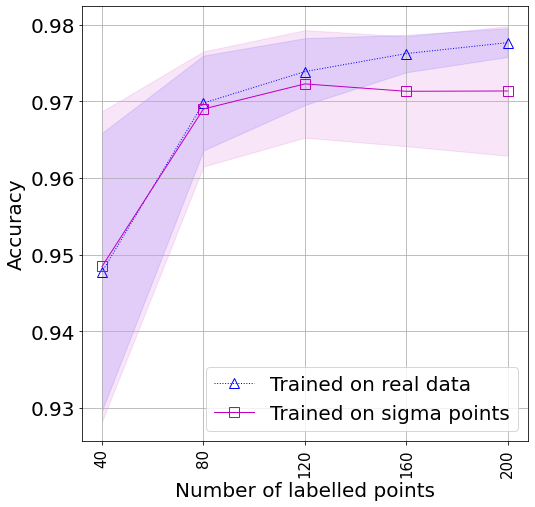

In [144]:
sigma_knn_mean = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST4_sigma_alpha_0_1_N_80.npy')
sigma_knn_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST4_sigma_alpha_0_1_N_80.npy')

mean_random = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST4_sigma_random_alpha_0_1_N_80.npy')[:5]
sd_random = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST4_sigma_random_alpha_0_1_N_80.npy')[:5]


number_of_labeled_data = range(40,235,40)
plt.figure(figsize=(8,8))

# plt.plot(number_of_labeled_data,uniform_ls,'go--',linewidth=1, markersize=10, mfc='none') 
# plt.plot(number_of_labeled_data,random_coreset_ls50,'r*-.',linewidth=1, markersize=10, mfc='none')
# plt.plot(number_of_labeled_data,sensitivity_ls50,'ms-',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sigma_knn_mean,'b^:',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,mean_random,'ms-',linewidth=1, markersize=10, mfc='none')

# plt.fill_between(number_of_labeled_data, (uniform_ls - uniform_ls_sd), (uniform_ls + uniform_ls_sd), alpha=.1, color = 'g')
# plt.fill_between(number_of_labeled_data, (random_coreset_ls50 - random_coreset_ls50_sd), (random_coreset_ls50 + random_coreset_ls50_sd), alpha=.1, color = 'r')
# plt.fill_between(number_of_labeled_data, (sensitivity_ls50 - sensitivity_ls50_sd), (sensitivity_ls50 + sensitivity_ls50_sd), alpha=.1, color = 'm')
plt.fill_between(number_of_labeled_data, (sigma_knn_mean - sigma_knn_sd), (sigma_knn_mean + sigma_knn_sd), alpha=.1, color = 'b')
plt.fill_between(number_of_labeled_data, (mean_random - sd_random), (mean_random + sd_random), alpha=.1, color = 'm')



plt.legend([         
#             'Uniform coreset sampling',
#             'Random coreset sampling',
#             'Sensitivity coreset sampling',
            'Trained on real data',  'Trained on sigma points'
           ], loc = 4, fontsize=20)
                 
plt.grid()
plt.xticks(number_of_labeled_data, fontsize = 15, rotation = 90)
plt.yticks(fontsize = 20)
plt.xlabel("Number of labelled points", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.savefig('/home/dsarkar/compute_canada/MNIST/analysis/MNIST4_0_1_N_80_comparison_of_real_vs_sigma.pdf', bbox_inches = 'tight')

In [194]:
kmeans = KMeans(n_clusters=40, random_state=0).fit(sigma_points)
labels = kmeans.labels_

In [195]:
print(Counter(labels))

Counter({18: 37, 27: 34, 7: 33, 39: 32, 19: 32, 38: 28, 1: 28, 2: 28, 23: 27, 31: 25, 14: 25, 24: 25, 35: 25, 6: 25, 4: 24, 26: 24, 8: 24, 11: 24, 15: 24, 36: 23, 17: 21, 12: 20, 20: 19, 22: 19, 3: 19, 33: 19, 25: 19, 10: 18, 16: 18, 28: 17, 13: 17, 21: 17, 0: 17, 32: 16, 5: 15, 37: 14, 34: 13, 29: 12, 9: 12, 30: 11})


# train a model to check

In [196]:
mean_random = []
sd_random = []

for coreset_size in range(40,441,40): # start from 1000 labeled points
    print("*********************** Training on {} points ***********************".format(coreset_size))

    accuracy = []
    m = int(coreset_size/40) # m=B/K, number of points from each cluster
    iterations = 0
    while iterations < 500: # run 100 simulations and take average 
        train_data = []
        train_labels = []
        indices_to_pick = []
        
        print("Choosing {} points from each cluster".format(m))
        for cluster_index in range(40):
            C_i = np.where(labels == cluster_index)[0].tolist()
            sample_i = random.sample(C_i, m)
            indices_to_pick.append(sample_i)
        
        indices_to_pick = list(chain.from_iterable(indices_to_pick)) # flatten the 2D list
        
        assert len(indices_to_pick)==coreset_size, "Sample size mismatch!!!!"
        
        for index in indices_to_pick:
            train_data.append(sigma_points[index])
            train_labels.append(prediction[index]) 
        
        train_x = np.array(train_data)
        train_y = np.array(train_labels)
        
        print()
        print("Distribution of data in the training points")
        print(Counter(train_y))

        clf.fit(train_x, train_y)
        print("Best parameters set found on {} data points:".format(coreset_size))
        print(clf.best_params_)
        print()
        y_true, y_pred = Y_test, clf.predict(latent_space_test)
        accuracy.append(accuracy_score(y_true, y_pred))
        iterations += 1

    accuracy = np.asarray(accuracy)
    mean_accuracy = accuracy.mean()
    sd_accuracy = accuracy.std()


    mean_random.append(mean_accuracy)
    sd_random.append(sd_accuracy)
    
mean_random = np.array(mean_random)
sd_random = np.array(sd_random)

*********************** Training on 40 points ***********************
Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   22.0s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totallin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 11, 1: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 11, 1: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kern

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'li

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'k

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 9: 10, 0: 10, 1: 9})
Fitting 5 folds for each of 8 candidates, totallin

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totallin

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 9: 9, 1: 8})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 9: 10, 0: 10, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kerne

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 11, 9: 8, 1: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fit

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({0: 11, 3: 10, 1: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel':

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 11, 1: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 11, 1: 10, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({0: 11, 3: 10, 1: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({0: 11, 3: 10, 1: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fit

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 9: 10, 0: 10, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 f

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel'

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linea

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 11, 1: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 1: 10, 0: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 11, 1: 9, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'li

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 1: 10, 3: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 1: 10, 3: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 9: 10, 0: 10, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
B

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 11, 1: 10, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 0: 11, 1: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 11, 1: 10, 0: 10, 3: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'line

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'r

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'r

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rb

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 9: 10, 0: 10, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 13, 0: 10, 1: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({9: 10, 3: 10, 1: 10, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 11, 1: 10, 0: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 1: 10, 0: 10, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 12, 0: 10, 9: 9, 1: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'k

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 1: 20, 0: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 20, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 1: 20, 0: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'ke

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 1: 20, 0: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totallin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 1: 20, 0: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totallin

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 1: 20, 0: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 1: 20, 0: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 26, 0: 21, 1: 19, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 20, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 20, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'ker

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totallin

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 1: 20, 0: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 1: 20, 0: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 9: 20, 0: 20, 1: 18})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 1: 20, 0: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 1: 20, 0: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 20, 9: 19, 1: 19})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'ker

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 1: 20, 0: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 22, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 9: 20, 0: 20, 1: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 26, 0: 20, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 20, 9: 19, 1: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 1: 20, 0: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 1: 20, 0: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 1: 20, 0: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 22, 1: 20, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 0: 21, 1: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 20, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 20, 9: 19, 1: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 22, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 20, 9: 19, 1: 19})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 1: 20, 0: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kern

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points fr

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 22, 1: 20, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 20, 9: 19, 1: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 22, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 1: 20, 0: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 21, 1: 19, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 0: 21, 1: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 22, 0: 21, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 21, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 21, 1: 20, 0: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 0: 20, 1: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 25, 0: 20, 1: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 21, 1: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 0: 20, 1: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 23, 1: 20, 0: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 24, 1: 20, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

*********************** Training on 120 points ***********************
Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 32, 0: 31, 1: 30, 9: 27})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 1: 30, 0: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 3

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 30, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 1: 30, 0: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C'

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 32, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 30, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 38, 0: 30, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 32, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 30, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1,

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 30, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 38, 0: 31, 1: 29, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 1: 30, 0: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 32, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 30, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 32, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 32, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 1: 30, 0: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 32, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 32, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 32, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 1: 30, 0: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 32, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 30, 9: 26})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 32, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 30, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 1: 30, 0: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'ke

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kern

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 30, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 32, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 1: 30, 0: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 32, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 32, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'k

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 0: 31, 1: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 30, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 32, 0: 31, 1: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 32, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 32, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 32, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kerne

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 38, 0: 31, 1: 30, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 30, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 32, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 33, 1: 30, 0: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 38, 0: 31, 1: 29, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'k

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 30, 1: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 32, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 38, 0: 30, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 32, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 30, 1: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 32, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 32, 1: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 30, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 32, 1: 29, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'ke

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 0: 31, 1: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 36, 1: 30, 0: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 37, 0: 31, 1: 30, 9: 22})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 1: 30, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 0: 31, 1: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 30, 1: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 35, 1: 30, 0: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 34, 0: 31, 1: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 160 points ***********************
Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 42, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Count

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 42, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 40, 1: 39, 9: 35})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 40, 1: 39, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 40, 1: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 38, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 0: 41, 1: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 1: 40, 0: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 38, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalli

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 50, 0: 40, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 1: 40, 0: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 1: 40, 0: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 0: 41, 1: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 1: 40, 0: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kerne

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'ke

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 0: 41, 1: 39, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 40, 1: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 0: 40, 1: 39, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 1: 40, 0: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 0: 41, 1: 40, 9: 35})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 40, 1: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 1: 40, 0: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C':

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 1: 40, 0: 40, 9: 31})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 0: 42, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 40, 1: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 42, 0: 41, 1: 39, 9: 38})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 50, 0: 40, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 40, 1: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 1: 40, 0: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 1: 40, 0: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 40, 9: 32})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 1: 40, 0: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 40, 1: 39, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 40, 1: 39, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 40, 1: 39, 9: 35})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 42, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'k

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 0: 41, 1: 40, 9: 35})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'ke

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 50, 0: 41, 1: 40, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 0: 40, 1: 39, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 1: 40, 0: 40, 9: 31})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 42, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 42, 1: 38, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 40, 1: 38, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 1: 40, 0: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kern

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 42, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 38, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 1: 40, 0: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 1: 40, 0: 40, 9: 32})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 40, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, total

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 40, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 38, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kern

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 40, 1: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 42, 1: 39, 9: 30})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 1: 40, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 41, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 42, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 39, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 44, 1: 40, 0: 40, 9: 36})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 42, 1: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 46, 0: 40, 1: 38, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 49, 0: 41, 1: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 42, 1: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 48, 0: 41, 1: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 47, 0: 41, 1: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 1: 40, 0: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 45, 0: 41, 1: 39, 9: 35})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

*********************** Training on 200 points ***********************
Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 50, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 52, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 50, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 62, 0: 52, 1: 49, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'k

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 48, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 48, 9: 40})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 52, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 52, 1: 50, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 62, 0: 51, 1: 49, 9: 38})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 52, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 1: 50, 0: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 52, 1: 50, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 62, 0: 51, 1: 49, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 1: 50, 0: 50, 9: 39})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 62, 0: 52, 1: 48, 9: 38})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 50, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 62, 0: 51, 1: 49, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C'

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 62, 0: 51, 1: 49, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 48, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 48, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 52, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 50, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 55, 0: 52, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 55, 0: 50, 1: 49, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 1: 50, 0: 50, 9: 44})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 55, 0: 50, 1: 49, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 52, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 50, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 50, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 55, 0: 51, 1: 50, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 50, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 50, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 48, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 50, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C'

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 50, 9: 38})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 52, 1: 49, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'k

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 50, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 62, 0: 51, 1: 49, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 50, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 62, 0: 50, 1: 48, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 50, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 50, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 1: 50, 0: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 50, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 1: 50, 0: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 1: 50, 0: 50, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 48, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 55, 1: 50, 0: 50, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 52, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 52, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 50, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 50, 9: 38})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 50, 9: 43})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 p

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 52, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 1: 50, 0: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 50, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 50, 1: 49, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C':

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 52, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 52, 1: 49, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 1: 50, 0: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 51, 1: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 55, 0: 51, 1: 50, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 50, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 51, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 55, 0: 51, 1: 50, 9: 44})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 61, 0: 50, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 50, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 1: 50, 0: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 51, 1: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 56, 0: 50, 1: 49, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 48, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 51, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 1: 50, 0: 50, 9: 40})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 52, 1: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 52, 1: 50, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 49, 9: 42})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 51, 1: 50, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 58, 0: 50, 1: 49, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 59, 0: 50, 1: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 57, 0: 51, 1: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 60, 0: 50, 1: 48, 9: 42})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

*********************** Training on 240 points ***********************
Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 1: 60, 0: 60, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 61, 1: 58, 9: 48})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 0: 61, 1: 60, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 60, 9: 49})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 68, 1: 60, 0: 60, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 58, 9: 49})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 60, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 1: 60, 0: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 62, 1: 58, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 58, 9: 50})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 1: 60, 0: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 60, 9: 50})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 66, 0: 61, 1: 60, 9: 53})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 1: 60, 0: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 67, 1: 60, 0: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 poi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 74, 0: 61, 1: 59, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 1: 60, 0: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 1: 60, 0: 60, 9: 51})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 60, 9: 50})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 58, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 74, 0: 61, 1: 58, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 60, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 58, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 1: 60, 0: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 1: 60, 0: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 62, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 60, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 0: 62, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 60, 9: 50})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 61, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 62, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 66, 0: 62, 1: 60, 9: 52})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 62, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 1: 60, 0: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 1: 60, 0: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 0: 61, 1: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1,

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 1: 60, 0: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 58, 9: 49})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 0: 61, 1: 60, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 59, 9: 49})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 0: 61, 1: 60, 9: 52})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 po

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 60, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 1: 60, 0: 60, 9: 51})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 61, 1: 60, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 1: 60, 0: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 0: 61, 1: 60, 9: 52})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 62, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 1: 60, 0: 60, 9: 51})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 0: 61, 1: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 0: 61, 1: 60, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 74, 0: 60, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 61, 1: 58, 9: 48})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 1: 60, 0: 60, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 61, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 62, 1: 59, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 58, 9: 51})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'k

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 60, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 62, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 60, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 1: 60, 0: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 59, 9: 48})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 60, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 74, 0: 61, 1: 59, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'k

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 58, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 60, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 58, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 1: 60, 0: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 62, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 1: 60, 0: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C':

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 1: 60, 0: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 74, 0: 62, 1: 59, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 60, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'k

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 1: 60, 0: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C'

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 61, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 0: 62, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 59, 9: 50})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 74, 0: 61, 1: 59, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 58, 9: 48})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 1: 60, 0: 60, 9: 52})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 1: 60, 0: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 66, 0: 62, 1: 59, 9: 53})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 1: 60, 0: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 60, 1: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 1: 60, 0: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 1: 60, 0: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 1: 60, 0: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 60,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 61, 1: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'k

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 60, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 61, 1: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 62, 1: 60, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 1: 60, 0: 60, 9: 52})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 67, 1: 60, 0: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 poin

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 71, 0: 60, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 62, 1: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 62, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 72, 0: 60, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 62, 1: 59, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 1: 60, 0: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 58, 9: 50})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 69, 0: 61, 1: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 62, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 62, 1: 59, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 71, 0: 61, 1: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 68, 0: 61, 1: 60, 9: 51})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 73, 0: 61, 1: 58, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({3: 70, 0: 61, 1: 59, 9: 50})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 72, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 70, 1: 69, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 70, 1: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 71, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 71, 1: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 1: 70, 0: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 78, 0: 72, 1: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 68, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 71, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 70, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 70, 1: 69, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 70, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 68, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 1: 70, 0: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 1: 70, 0: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 1: 70, 0: 70, 9: 59})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 71, 1: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 1: 70, 0: 70, 9: 59})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 71, 1: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 1: 70, 0: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 1: 70, 0: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 68, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 72, 1: 70, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, '

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 78, 0: 72, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 70, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 72, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 70, 9: 54})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 86, 0: 71, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 69, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 1: 70, 0: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 70, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 72, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 86, 0: 71, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 1: 70, 0: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 1: 70, 0: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 1: 70, 0: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 68, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 70, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 70, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 70, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 1: 70, 0: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 1: 70, 0: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 70, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 72, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 1: 70, 0: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 78, 0: 71, 1: 70, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 1: 70, 0: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 1: 70, 0: 70, 9: 61})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 71, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 68, 9: 57})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 69, 9: 60})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 78, 0: 71, 1: 70, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 72, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 71, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 1: 70, 0: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 1: 70, 0: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 72, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 72, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C':

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 72, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 70, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 70, 1: 69, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 78, 0: 71, 1: 69, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 69, 9: 55})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 1: 70, 0: 70, 9: 56})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 76, 0: 72, 1: 69, 9: 63})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 71, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 70, 1: 69, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 70, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 72, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 1: 70, 0: 70, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 69, 9: 60})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 1: 70, 0: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C':

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 70, 1: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 70, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, '

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 70, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 71, 1: 70, 9: 60})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 68, 9: 58})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 68, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'k

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 70, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 72, 1: 69, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 70, 1: 68, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 70, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 70, 1: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 72, 1: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 79, 0: 71, 1: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 68, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 71, 1: 68, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 70, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 69, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 85, 0: 70, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 70, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 84, 0: 71, 1: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 71, 1: 70, 9: 57})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 72, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 72, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 80, 0: 71, 1: 69, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 70, 1: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 71, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 82, 0: 72, 1: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 81, 0: 71, 1: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({3: 83, 0: 72, 1: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

*********************** Training on 320 points ***********************
Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 80, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 80, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 1: 80, 0: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 1: 80, 0: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 90, 0: 81, 1: 80, 9: 69})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 78, 9: 68})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 78, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 89, 0: 81, 1: 79, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 80, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 80, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 98, 0: 82, 1: 79, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 80, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 80, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 80, 1: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 80, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 80, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 80, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 1: 80, 0: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 90, 0: 82, 1: 79, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 98, 0: 82, 1: 78, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 78, 9: 64})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 98, 0: 82, 1: 79, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 80, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 80, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 80, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 98, 0: 81, 1: 79, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 1: 80, 0: 80, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 80, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 80, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 1: 80, 0: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 80, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 80, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 89, 0: 81, 1: 80, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 82, 1: 79, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 79, 9: 67})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 80, 1: 78, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 80, 1: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 99, 0: 81, 1: 79, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 80, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 80, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 80, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 1: 80, 0: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 80, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 80, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 78, 9: 68})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 1: 80, 0: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 78, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 80, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 1: 80, 0: 80, 9: 68})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 78, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 90, 0: 82, 1: 80, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kern

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 80, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 80, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 1: 80, 0: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 80, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 82, 1: 79, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 80, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 98, 0: 81, 1: 78, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 78, 9: 67})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 80, 1: 79, 9: 65})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 80, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 90, 0: 81, 1: 79, 9: 70})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 80, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 80, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 98, 0: 81, 1: 78, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 78, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 79, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 80, 1: 79, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 1: 80, 0: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 1: 80, 0: 80, 9: 67})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 80, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 79, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 78, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 82, 1: 79, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 82, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 80, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 1: 80, 0: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 80, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 79, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 80, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 80, 1: 78, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 80, 9: 64})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 80, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 81, 1: 80, 9: 67})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 81, 1: 80, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 82, 1: 79, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 80, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 90, 1: 80, 0: 80, 9: 70})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 80, 1: 79, 9: 68})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 80, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 80, 1: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 91, 0: 82, 1: 80, 9: 67})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 81, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 80, 1: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 92, 0: 82, 1: 80, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 97, 0: 81, 1: 79, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 96, 0: 81, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 81, 1: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 93, 0: 82, 1: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 94, 0: 82, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 81, 1: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({3: 95, 0: 82, 1: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 360 points ***********************
Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 1: 90, 0: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 102, 0: 91, 1: 88, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 88, 9: 74})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 89, 9: 76})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 90, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 90, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 90, 9: 75})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 102, 0: 91, 1: 89, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 89, 9: 77})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 90, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 c

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 101, 0: 92, 1: 90, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 90, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 1: 90, 0: 90, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 90, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 92, 1: 89, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 91, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 90, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 91, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C'

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 90, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 90, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 88, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 91, 1: 88, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 91, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 90, 1: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 110, 0: 91, 1: 89, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 102, 0: 90, 1: 89, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 90, 9: 73})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 90, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 102, 0: 91, 1: 90, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 88, 9: 76})
Fitting 5 folds for each of 8

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 90, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 92, 1: 89, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 88, 9: 78})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 89, 9: 77})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 1: 90, 0: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 102, 0: 92, 1: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 90, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 91, 1: 89, 9: 71})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 88, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 90, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 90, 9: 74})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 92, 1: 88, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 91, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 101, 0: 91, 1: 90, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 88, 9: 77})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 90, 1: 89, 9: 73})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 90, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 88, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 102, 0: 92, 1: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 88, 9: 73})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 90, 9: 76})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 88, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 91, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 90, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 89, 9: 76})
Fitting 5 folds for each of 8 c

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 90, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 90, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 92, 1: 89, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 90, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 89, 9: 76})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 90, 9: 75})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 91, 1: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 89, 9: 76})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 88, 9: 73})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 110, 0: 92, 1: 89, 9: 69})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 91, 1: 89, 9: 71})
Fitting 5 folds for each of 8 c

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 90, 9: 75})
Fitting 5 folds for each of 8 c

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 90, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 90, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 90, 9: 73})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 91, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 88, 9: 73})
Fitting 5 folds for each of 8 c

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 88, 9: 74})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 90, 1: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 c

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 90, 1: 89, 9: 76})
Fitting 5 folds for each of 8

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 1: 90, 0: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 110, 0: 91, 1: 89, 9: 70})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 89, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 90, 9: 75})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 102, 0: 92, 1: 88, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 91, 1: 89, 9: 76})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 92, 1: 90, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 104, 0: 92, 1: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 109, 0: 91, 1: 90, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 90, 9: 74})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 91, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 92, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 108, 0: 91, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 90, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 88, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 105, 0: 91, 1: 89, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 103, 0: 92, 1: 90, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 92, 1: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 88, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 91, 1: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 107, 0: 90, 1: 89, 9: 74})


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({3: 106, 0: 92, 1: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

*********************** Training on 400 points ***********************
Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 98, 9: 85})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 100, 9: 82})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 100, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 102, 1: 98, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 99, 9: 85})
Fitting 5 folds for each o

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 98, 9: 85})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 100, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 98, 9: 84})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 101, 1: 100, 9: 79})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 98, 9: 83})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 100, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 100, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each o

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 102, 1: 99, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 98, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 100, 9: 81})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 102, 1: 99, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 101, 1: 99, 9: 79})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 101, 1: 100, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 100, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 98, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 100, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 101, 1: 99, 9: 80})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 100, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 98, 9: 83})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 100, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 100, 9: 81})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 100, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 100, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 98, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 100, 9: 80})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 100, 1: 99, 9: 84})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 99, 9: 85})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 98, 9: 84})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 101, 1: 99, 9: 80})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 98, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 100, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 102, 1: 98, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 98, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 100, 9: 82})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 100, 9: 80})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 100, 9: 83})


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 100, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 98, 9: 84})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 98, 9: 86})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 100, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 102, 1: 99, 9: 78})
Fitting 5 folds for each of 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 98, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 113, 0: 101, 1: 100, 9: 86})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 101, 1: 98, 9: 80})
Fitting 5 folds for each of

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 98, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 100, 9: 82})
Fitting 5 folds for each o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 100, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 100, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 102, 1: 98, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 100, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 100, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 100, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 101, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 100, 9: 82})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 100, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 99, 9: 85})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 100, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 100, 9: 81})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 98, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 100, 9: 80})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 100, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 101, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 100, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 101, 1: 98, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 98, 9: 80})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 98, 9: 80})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 98, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 100, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 101, 1: 99, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 102, 1: 98, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 100, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 100, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 98, 9: 83})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 102, 1: 99, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 101, 1: 99, 9: 86})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 101, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 101, 1: 98, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 98, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 99, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 99, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 115, 0: 102, 1: 98, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 102, 1: 99, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 98, 9: 84})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 102, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 117, 0: 102, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 116, 0: 102, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 121, 0: 102, 1: 99, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 98, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 99, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 102, 1: 99, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 118, 0: 101, 1: 98, 9: 83})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 119, 0: 101, 1: 99, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 117, 0: 101, 1: 98, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 114, 0: 102, 1: 99, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({3: 120, 0: 101, 1: 99, 9: 80})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

*********************** Training on 440 points ***********************
Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 108, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 125, 0: 112, 1: 108, 9: 95})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 112, 1: 110, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 108, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 111, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 111, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 111, 1: 109, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 108, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 124, 0: 111, 1: 110, 9: 95})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 109, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 110, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 111, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 108, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 111, 1: 109, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 112, 1: 109, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 110, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 111, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 133, 0: 112, 1: 109, 9: 86})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 133, 0: 111, 1: 108, 9: 88})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 108, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 110, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 133, 0: 111, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 110, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 110, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 111, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 112, 1: 110, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 110, 9: 91})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 108, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 108, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 110, 9: 89})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 110, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 133, 0: 112, 1: 109, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 108, 9: 93})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 109, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 108, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 108, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 111, 1: 109, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 108, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 110, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'line

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 109, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 110, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 109, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 108, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 110, 9: 92})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 112, 1: 109, 9: 93})


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 108, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 108, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 110, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 108, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 112, 1: 109, 9: 93})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 108, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 110, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 133, 0: 112, 1: 108, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 111, 1: 109, 9: 89})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 110, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 111, 1: 108, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 112, 1: 108, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 108, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 110, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 112, 1: 110, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 108, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 110, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 110, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 109, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 112, 1: 108, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 108, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 112, 1: 109, 9: 93})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 110, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 110, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 110, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 111, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 108, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 110, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 108, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 133, 0: 112, 1: 108, 9: 87})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 110, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 133, 0: 112, 1: 109, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 108, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 110, 9: 91})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 111, 1: 110, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 108, 9: 89})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 134, 0: 112, 1: 109, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 133, 0: 112, 1: 109, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 112, 1: 110, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 126, 0: 111, 1: 109, 9: 94})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 111, 1: 109, 9: 89})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 111, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 111, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 108, 9: 91})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 108, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 108, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 108, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 108, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 109, 9: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 112, 1: 109, 9: 92})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 111, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 111, 1: 108, 9: 89})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each o

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 110, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 110, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 127, 0: 111, 1: 110, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 110, 9: 89})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 109, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 108, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 111, 1: 109, 9: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 131, 0: 112, 1: 109, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 132, 0: 112, 1: 108, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 109, 9: 89})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 108, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 111, 1: 109, 9: 90})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 129, 0: 112, 1: 109, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 130, 0: 112, 1: 108, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({3: 128, 0: 112, 1: 109, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [197]:
mean_random.shape

(11,)

In [198]:
np.save('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST4_sigma_KNN_alpha_0_9_N_80.npy',mean_random)
np.save('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST4_sigma_KNN_alpha_0_9_N_80.npy',sd_random)

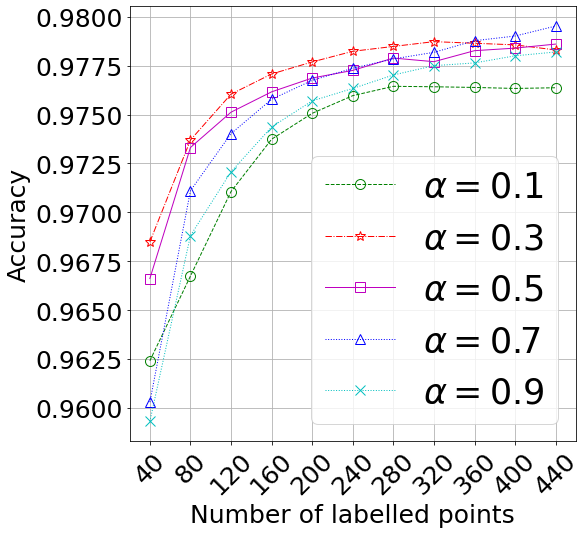

In [203]:
sigma_knn_mean1 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST4_sigma_KNN_alpha_0_1_N_80.npy')
sigma_knn_sd1 = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST4_sigma_KNN_alpha_0_1_N_80.npy')

sigma_knn_mean3 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST4_sigma_KNN_alpha_0_3_N_80.npy')
sigma_knn_sd3 = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST4_sigma_KNN_alpha_0_3_N_80.npy')

sigma_knn_mean5 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST4_sigma_KNN_alpha_0_5_N_80.npy')
sigma_knn_sd5 = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST4_sigma_KNN_alpha_0_5_N_80.npy')

sigma_knn_mean7 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST4_sigma_KNN_alpha_0_7_N_80.npy')
sigma_knn_sd7 = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST4_sigma_KNN_alpha_0_7_N_80.npy')

sigma_knn_mean9 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST4_sigma_KNN_alpha_0_9_N_80.npy')
sigma_knn_sd9 = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST4_sigma_KNN_alpha_0_9_N_80.npy')


number_of_labeled_data = range(40,441,40)
plt.figure(figsize=(8,8))

plt.plot(number_of_labeled_data,sigma_knn_mean1,'go--',linewidth=1, markersize=10, mfc='none') 
plt.plot(number_of_labeled_data,sigma_knn_mean3,'r*-.',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sigma_knn_mean5,'ms-',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sigma_knn_mean7,'b^:',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sigma_knn_mean9,'cx:',linewidth=1, markersize=10, mfc='none')

# plt.fill_between(number_of_labeled_data, (sigma_knn_mean1 - sigma_knn_sd1), (sigma_knn_mean1 + sigma_knn_sd1), alpha=.1, color = 'g')
# plt.fill_between(number_of_labeled_data, (sigma_knn_mean3 - sigma_knn_sd3), (sigma_knn_mean3 + sigma_knn_sd3), alpha=.1, color = 'r')
# plt.fill_between(number_of_labeled_data, (sigma_knn_mean5 - sigma_knn_sd5), (sigma_knn_mean5 + sigma_knn_sd5), alpha=.1, color = 'm')
# plt.fill_between(number_of_labeled_data, (sigma_knn_mean7 - sigma_knn_sd7), (sigma_knn_mean7 + sigma_knn_sd7), alpha=.1, color = 'b')
# plt.fill_between(number_of_labeled_data, (sigma_knn_mean9 - sigma_knn_sd9), (sigma_knn_mean9 + sigma_knn_sd9), alpha=.1, color = 'c')



plt.legend([         
            r'$\alpha = 0.1$',
            r'$\alpha = 0.3$',
            r'$\alpha = 0.5$',
            r'$\alpha = 0.7$',
            r'$\alpha = 0.9$'
           ], loc = 4, fontsize=35)
                 
plt.grid()
plt.xticks(number_of_labeled_data, fontsize = 25, rotation = 45)
plt.yticks(fontsize = 25)
plt.xlabel("Number of labelled points", fontsize = 25)
plt.ylabel("Accuracy", fontsize = 25)
plt.savefig('/home/dsarkar/compute_canada/MNIST/analysis/MNIST4_trained-on-sigma-with-kmeans_comparison_alpha_N_80_test.pdf', bbox_inches = 'tight')

In [26]:
# number_of_labeled_data = range(40,401,40)
# plt.figure(figsize=(20,10))


# plt.plot(number_of_labeled_data,mean_random, marker='^', markersize=10) 

# plt.fill_between(number_of_labeled_data, (mean_random - sd_random), (mean_random + sd_random), alpha=.1)


# plt.legend([
#           'latent space (Sigma Point Sampling)' 
#            ], loc = 4, fontsize=30)
# plt.grid()
# plt.xticks(number_of_labeled_data)
# plt.xlabel("Number of labelled points")
# plt.ylabel("Accuracy")
# plt.title("KNN | alpha= 0.4 | 80 components | z=5")

# 400 labeled points

In [8]:
uniform_is = [uniform_is[2*i+1] for i in range(11)]
uniform_is_sd = [uniform_is_sd[2*i+1] for i in range(11)]
uniform_is = np.array(uniform_is)
uniform_is_sd = np.array(uniform_is_sd)

uniform_ls = [uniform_ls[2*i+1] for i in range(11)]
uniform_ls_sd = [uniform_ls_sd[2*i+1] for i in range(11)]
uniform_ls = np.array(uniform_ls)
uniform_ls_sd = np.array(uniform_ls_sd)


random_coreset_is20 = [random_coreset_is20[2*i+1] for i in range(11)]
random_coreset_is20_sd = [random_coreset_is20_sd[2*i+1] for i in range(11)]
random_coreset_is20 = np.array(random_coreset_is20)
random_coreset_is20_sd = np.array(random_coreset_is20_sd)

random_coreset_ls20 = [random_coreset_ls20[2*i+1] for i in range(11)]
random_coreset_ls20_sd = [random_coreset_ls20_sd[2*i+1] for i in range(11)]
random_coreset_ls20 = np.array(random_coreset_ls20)
random_coreset_ls20_sd = np.array(random_coreset_ls20_sd)

sensitivity_ls20 = [sensitivity_ls20[2*i+1] for i in range(11)]
sensitivity_ls20_sd = [sensitivity_ls20_sd[2*i+1] for i in range(11)]
sensitivity_ls20 = np.array(sensitivity_ls20)
sensitivity_ls20_sd = np.array(sensitivity_ls20_sd)


# uniform_is = uniform_is[:20]
# uniform_is_sd = uniform_is_sd[:20]
# uniform_ls = uniform_ls[:20]
# uniform_ls_sd = uniform_ls_sd[:20]
# random_coreset_is20 = random_coreset_is20[:20]
# random_coreset_is20_sd = random_coreset_is20_sd[:20]
# random_coreset_ls20 = random_coreset_ls20[:20]
# random_coreset_ls20_sd = random_coreset_ls20_sd[:20]
# sensitivity_ls20 = sensitivity_ls20[:20]
# sensitivity_ls20_sd = sensitivity_ls20_sd[:20]

In [11]:
sigma_knn_mean

array([0.96394533, 0.97150992, 0.97359942, 0.97514949, 0.97559361,
       0.97621771, 0.9767523 , 0.97752879, 0.97800048, 0.97826802,
       0.97850847])

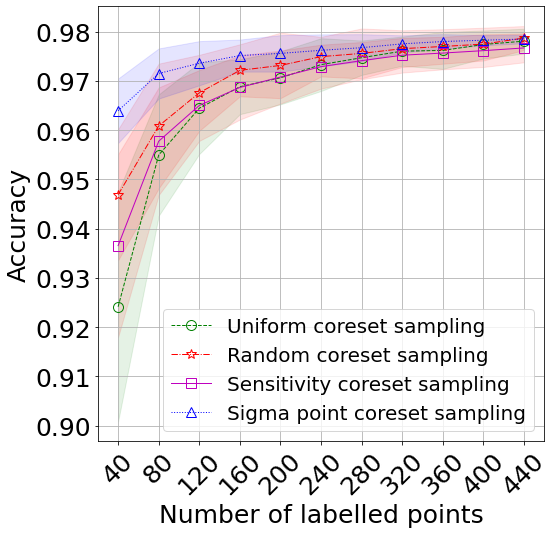

In [14]:
sigma_knn_mean = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST4_sigma_KNN_alpha_0_4_N_80.npy')
sigma_knn_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST4_sigma_KNN_alpha_0_4_N_80.npy')


number_of_labeled_data = range(40,441,40)
plt.figure(figsize=(8,8))

plt.plot(number_of_labeled_data,uniform_ls,'go--',linewidth=1, markersize=10, mfc='none') 
plt.plot(number_of_labeled_data,random_coreset_ls20,'r*-.',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sensitivity_ls20,'ms-',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sigma_knn_mean,'b^:',linewidth=1, markersize=10, mfc='none')

plt.fill_between(number_of_labeled_data, (uniform_ls - uniform_ls_sd), (uniform_ls + uniform_ls_sd), alpha=.1, color = 'g')
plt.fill_between(number_of_labeled_data, (random_coreset_ls20 - random_coreset_ls20_sd), (random_coreset_ls20 + random_coreset_ls20_sd), alpha=.1, color = 'r')
plt.fill_between(number_of_labeled_data, (sensitivity_ls20 - sensitivity_ls20_sd), (sensitivity_ls20 + sensitivity_ls20_sd), alpha=.1, color = 'r')
plt.fill_between(number_of_labeled_data, (sigma_knn_mean - sigma_knn_sd), (sigma_knn_mean + sigma_knn_sd), alpha=.1, color = 'b')



plt.legend([         
            'Uniform coreset sampling',
            'Random coreset sampling',
            'Sensitivity coreset sampling',
            'Sigma point coreset sampling' 
           ], loc = 4, fontsize=20)
                 
plt.grid()
plt.xticks(number_of_labeled_data, fontsize = 25, rotation = 45)
plt.yticks(fontsize = 25)
plt.xlabel("Number of labelled points", fontsize = 25)
plt.ylabel("Accuracy", fontsize = 25)
plt.savefig('/home/dsarkar/compute_canada/MNIST/analysis/MNIST4_0_4_N_80_trained-on-sigma-with-kmeans_comparison.pdf', bbox_inches = 'tight')

Text(0, 0.5, 'Accuracy')

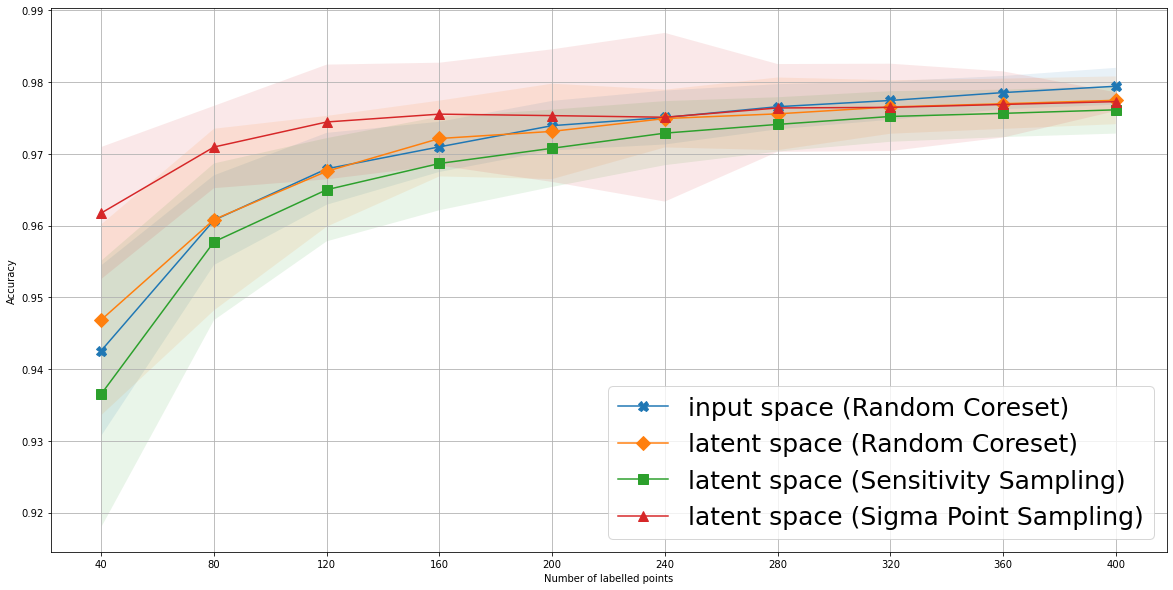

In [27]:
number_of_labeled_data = range(40,401,40)
plt.figure(figsize=(20,10))


# plt.plot(number_of_labeled_data, uniform_is, marker='o', markersize=10)
# plt.plot(number_of_labeled_data, uniform_ls, marker='*', markersize=10)
plt.plot(number_of_labeled_data, random_coreset_is20, marker='X', markersize=10)
plt.plot(number_of_labeled_data, random_coreset_ls20, marker='D', markersize=10) 
plt.plot(number_of_labeled_data, sensitivity_ls20, marker='s', markersize=10) 
plt.plot(number_of_labeled_data,mean_random, marker='^', markersize=10) 


# plt.fill_between(number_of_labeled_data, (uniform_is - uniform_is_sd), (uniform_is + uniform_is_sd), alpha=.1)
# plt.fill_between(number_of_labeled_data, (uniform_ls - uniform_ls_sd), (uniform_ls + uniform_ls_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (random_coreset_is20 - random_coreset_is20_sd), (random_coreset_is20 + random_coreset_is20_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (random_coreset_ls20 - random_coreset_ls20_sd), (random_coreset_ls20 + random_coreset_ls20_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (sensitivity_ls20 - sensitivity_ls20_sd), (sensitivity_ls20 + sensitivity_ls20_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (mean_random - sd_random), (mean_random + sd_random), alpha=.1)


plt.legend([#'input space (uniform)',         
            #'latent space (uniform)',
          'input space (Random Coreset)',
            'latent space (Random Coreset)'\
             ,'latent space (Sensitivity Sampling)'\
          ,'latent space (Sigma Point Sampling)' 
           ], loc = 4, fontsize=25)
plt.grid()
plt.xticks(number_of_labeled_data)
plt.xlabel("Number of labelled points")
plt.ylabel("Accuracy")
#plt.title("KNN | alpha= 0.1 | 80 components | z=5")